# Pet-project по теме: "Anti-fraud в банковских транзакциях"

## Выполнил: Сорочайкин Александр Ярославович

# Подключение необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score
from catboost import CatBoostClassifier

# Загрузка и первичный анализ данных

### Загрузим данные и проведем первичный анализ

In [2]:
df = pd.read_csv('transfers_fraud.csv')

In [3]:
df.sample(5)

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
82885,86764,108262565,33899382,2019-03-17 12:57:19,0,MOBILEAPI,2019-03-17,0.0,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,5.0,0.00,600097.00,0.00,0.0,0.0,0.0,0.0,69500.00,0.0,147107.00,0.0,550500.0,0.0,4.0,6.0,0.0,1.0,0.0,0.0,101.0,0.0,4.0,0.0,5.0,0.0,1064100.0,5180.24,0.0,3920.46,0.0,0.0,77833.62,0.0,36800.0,0.0,260002.0
61684,64585,33240540,49191068,2019-03-15 14:19:46,0,MOBILEAPI,2019-03-15,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,2.0,4762.84,20000.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,493547.00,0.0,135001.0,0.0,30.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,10.0,2.0,31.0,0.0,802751.0,1633.00,0.0,0.00,0.0,0.0,9299.29,0.0,316489.0,150.0,963659.0
71111,74525,92594204,52521627,2019-03-16 09:49:28,0,MOBILEAPI,2019-03-16,0.0,6.0,3.0,0.0,0.0,0.0,0.0,14.0,0.0,5.0,0.0,2.0,0.00,21418.82,390.95,0.0,0.0,0.0,0.0,4391.59,0.0,24578.82,0.0,1500.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,61215.0,0.00,0.0,0.00,0.0,0.0,609.10,0.0,0.0,0.0,161000.0
42428,44338,81373484,109391720,2019-03-14 11:46:29,0,WEBAPI,2019-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,6.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,22051.01,0.0,0.00,0.0,48500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,1000.0,0.0,1001.0
27299,28581,MBK6032401,4398250,2019-03-13 08:23:08,0,ATMAPI,2019-03-13,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.00,7400.00,0.00,0.0,0.0,0.0,0.0,2267.29,0.0,0.00,0.0,0.0,0.0,11.0,9.0,0.0,0.0,0.0,0.0,27.0,0.0,13.0,0.0,2.0,0.0,312639.0,1824.00,0.0,0.00,0.0,0.0,35581.71,0.0,141840.0,0.0,101500.0


In [4]:
df.isnull().sum()

Unnamed: 0     0
user_id        0
rec_user_id    0
date_time      0
resolution     0
sub_channel    0
idate          0
S_A_x          0
S_C_x          0
S_F_x          0
S_H_x          0
S_J_x          0
S_O_x          0
S_Q_x          0
S_R_x          0
S_T_x          0
S_U_x          0
S_X_x          0
S_Z_x          0
S_A_y          0
S_C_y          0
S_F_y          0
S_H_y          0
S_J_y          0
S_O_y          0
S_Q_y          0
S_R_y          0
S_T_y          0
S_U_y          0
S_X_y          0
S_Z_y          0
R_A_x          0
R_C_x          0
R_F_x          0
R_H_x          0
R_J_x          0
R_O_x          0
R_Q_x          0
R_R_x          0
R_T_x          0
R_U_x          0
R_X_x          0
R_Z_x          0
R_A_y          0
R_C_y          0
R_F_y          0
R_H_y          0
R_J_y          0
R_O_y          0
R_Q_y          0
R_R_y          0
R_T_y          0
R_U_y          0
R_X_y          0
R_Z_y          0
dtype: int64

In [5]:
df.columns

Index(['Unnamed: 0', 'user_id', 'rec_user_id', 'date_time', 'resolution',
       'sub_channel', 'idate', 'S_A_x', 'S_C_x', 'S_F_x', 'S_H_x', 'S_J_x',
       'S_O_x', 'S_Q_x', 'S_R_x', 'S_T_x', 'S_U_x', 'S_X_x', 'S_Z_x', 'S_A_y',
       'S_C_y', 'S_F_y', 'S_H_y', 'S_J_y', 'S_O_y', 'S_Q_y', 'S_R_y', 'S_T_y',
       'S_U_y', 'S_X_y', 'S_Z_y', 'R_A_x', 'R_C_x', 'R_F_x', 'R_H_x', 'R_J_x',
       'R_O_x', 'R_Q_x', 'R_R_x', 'R_T_x', 'R_U_x', 'R_X_x', 'R_Z_x', 'R_A_y',
       'R_C_y', 'R_F_y', 'R_H_y', 'R_J_y', 'R_O_y', 'R_Q_y', 'R_R_y', 'R_T_y',
       'R_U_y', 'R_X_y', 'R_Z_y'],
      dtype='object')

In [6]:
df.dtypes

Unnamed: 0       int64
user_id         object
rec_user_id     object
date_time       object
resolution       int64
sub_channel     object
idate           object
S_A_x          float64
S_C_x          float64
S_F_x          float64
S_H_x          float64
S_J_x          float64
S_O_x          float64
S_Q_x          float64
S_R_x          float64
S_T_x          float64
S_U_x          float64
S_X_x          float64
S_Z_x          float64
S_A_y          float64
S_C_y          float64
S_F_y          float64
S_H_y          float64
S_J_y          float64
S_O_y          float64
S_Q_y          float64
S_R_y          float64
S_T_y          float64
S_U_y          float64
S_X_y          float64
S_Z_y          float64
R_A_x          float64
R_C_x          float64
R_F_x          float64
R_H_x          float64
R_J_x          float64
R_O_x          float64
R_Q_x          float64
R_R_x          float64
R_T_x          float64
R_U_x          float64
R_X_x          float64
R_Z_x          float64
R_A_y      

In [7]:
df['sub_channel'].value_counts()

MOBILEAPI    70486
ATMAPI        9920
WEBAPI        5353
Name: sub_channel, dtype: int64

Проверим баланс классов в целевой переменной

In [8]:
df['resolution'].value_counts()

0    84563
1     1196
Name: resolution, dtype: int64

### Выводы:

- Пропущенные значения отсутствуют
- Видим, что признаки делятся на 2 вида - признаки отправителя и признаки получателя. В перспективе, необходимо проанализировать две этих группы по отдельности. 
- Также обратим внимание, что у нас присутстуют парные признаки - количество переводов и суммы переводов. Возможно стоит поработать с ними в паре
- Признаки user_id, rec_user_id, idate не имеют смысла использовать для обучения. Необходимо от них избавиться
- Признак date_time не подходит для обучения из-за своего типа данных. Данный признак может сильно помешать на этапе кластеризации, а также не является информативным в данной задаче с имеющимися данными
- Признак sub_channel является категориальным. Необходимо преобразовать его с помощью one hot encoding
- Видим явный дисбаланс классов. Это будет необходимо учесть: Либо выбрать модели, которые не зависимы от балансировки, либо поработать с объемом датасета

План дальнейших действий
- Анализ признаков отправителя
- Анализ признаков получателя
- feature engeneering (не забыть про дату и sub_channel)
- Написание функции для преобразования данных
- Попробовать посоздавать новые категории с помощью кластеризации. Поразбиваем наш датасет на кластеры, разными моделями и на разное количество. Тем самым, получим разные категориальные признаки.
- Анализ взаимосвязей между признаками. Выделение самых важных признаков
- Порассуждать, какие метрики будем использовать в данной задаче
- Поработать с количесвом представителей минорного класса. Попробовать нагенерить (либо другим методом) набрать достаточное кол-во данных
- Обучить различное модели


# Анализ признаков

### Первичная подготовка к анализу

Исследуем множества значений наших признаков, а также количество ненулевых значений. Тем самым мы можем определить выбросы и избавиться от них, а также выделить признакие, которые являются недостаточно информативными и их можно бинаризировать (1 - были переводы в данной категории, 0 - не было.) Если наличие переводов в категории никак не влияет на метку, то от данного признака имеет смысл избавиться. При обработке выбросов необходимо проверять, что аномальное значение не является мошенническим переводом (иначе это не выброс, а особенность данных)

In [9]:
features = ['S_A_x', 'S_C_x', 'S_F_x', 'S_H_x', 'S_J_x',
       'S_O_x', 'S_Q_x', 'S_R_x', 'S_T_x', 'S_U_x', 'S_X_x', 'S_Z_x', 'S_A_y',
       'S_C_y', 'S_F_y', 'S_H_y', 'S_J_y', 'S_O_y', 'S_Q_y', 'S_R_y', 'S_T_y',
       'S_U_y', 'S_X_y', 'S_Z_y', 'R_A_x', 'R_C_x', 'R_F_x', 'R_H_x', 'R_J_x',
       'R_O_x', 'R_Q_x', 'R_R_x', 'R_T_x', 'R_U_x', 'R_X_x', 'R_Z_x', 'R_A_y',
       'R_C_y', 'R_F_y', 'R_H_y', 'R_J_y', 'R_O_y', 'R_Q_y', 'R_R_y', 'R_T_y',
       'R_U_y', 'R_X_y', 'R_Z_y']

Разделим признаки для удобства в дальнейшем исследовании:

In [10]:
# Разделение признаков на группы 'S' и 'R'
s_features = [f for f in features if f.startswith('S')]
r_features = [f for f in features if f.startswith('R')]

# Разделение групп 'S' и 'R' на подгруппы 'x' и 'y'
s_x_features = [f for f in s_features if f.endswith('_x')]
s_y_features = [f for f in s_features if f.endswith('_y')]
r_x_features = [f for f in r_features if f.endswith('_x')]
r_y_features = [f for f in r_features if f.endswith('_y')]

# Функция для создания словаря пар признаков
def create_feature_dict(features):
    feature_dict = {}
    for f in features:
        base_feature = f[:-2]  # Убираем последние два символа (_x или _y)
        if base_feature not in feature_dict:
            feature_dict[base_feature] = {}
        feature_dict[base_feature][f[-1]] = f  # Последний символ 'x' или 'y'
    return feature_dict

# Создание словарей пар признаков для групп 'S' и 'R'
s_feature_dict = create_feature_dict(s_features)
r_feature_dict = create_feature_dict(r_features)

# Создание списков пар признаков для групп 'S' и 'R'
s_pairs = [(s_feature_dict[base]['x'], s_feature_dict[base]['y']) for base in s_feature_dict if 'x' in s_feature_dict[base] and 'y' in s_feature_dict[base]]
r_pairs = [(r_feature_dict[base]['x'], r_feature_dict[base]['y']) for base in r_feature_dict if 'x' in r_feature_dict[base] and 'y' in r_feature_dict[base]]

Подготовим функцию для отрисовки графика

In [11]:
def plot_histogram_and_boxplot(df, column):
    """
    Функция для построения гистограммы и диаграммы размаха для указанного столбца датафрейма.
    
    :param df: DataFrame, содержащий данные.
    :param column: str, название столбца, для которого нужно построить графики.
    """
    plt.figure(figsize=(14, 6))
    
    # Построение гистограммы
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=15, color='blue')
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.grid(True)
    
    # Построение диаграммы размаха
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='blue')
    plt.title(f'Диаграмма размаха {column}')
    plt.xlabel(column)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Анализ признаков отправителя

In [12]:
df_sender = df[s_features]

In [13]:
df[s_features].describe()

,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y
count,85759.000000,85759.000000,85759.000000,85759.00000,85759.000000,85759.000000,85759.000000,85759.000000,85759.000000,85759.000000,85759.000000,85759.000000,8.575900e+04,8.575900e+04,8.575900e+04,8.575900e+04,85759.000000,85759.000000,8.575900e+04,8.575900e+04,8.575900e+04,8.575900e+04,8.575900e+04,8.575900e+04
mean,0.192458,11.046992,1.980060,0.06376,0.048508,0.006530,0.005201,17.558215,0.256416,9.585385,0.480334,5.391656,1.292406e+02,1.293496e+05,2.037160e+03,1.747726e+03,227.904349,29.043109,2.037010e+02,7.375743e+04,2.610290e+02,1.560886e+05,1.911029e+03,1.229784e+05
std,2.915367,64.498095,4.228584,0.52547,0.363994,0.141553,0.106116,26.263121,1.282009,23.462392,2.307089,7.933813,6.769768e+03,5.074556e+05,5.810730e+04,2.893576e+05,3424.186761,2248.309784,9.863399e+03,3.083727e+06,6.358892e+03,6.225577e+05,5.516661e+04,4.555877e+05
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,1.703600e+03,0.000000e+00,1.400000e+03,0.000000e+00,0.000000e+00
50%,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,11.000000,0.000000,5.000000,0.000000,3.000000,0.000000e+00,1.300000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,7.699830e+03,0.000000e+00,1.590000e+04,0.000000e+00,1.175500e+04
75%,0.000000,9.000000,2.000000,0.00000,0.000000,0.000000,0.000000,23.000000,0.000000,11.000000,0.000000,7.000000,0.000000e+00,7.000970e+04,8.061700e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,2.450876e+04,0.000000e+00,8.880000e+04,0.000000e+00,7.300200e+04
max,373.000000,10989.000000,154.000000,31.00000,24.000000,16.000000,7.000000,2442.000000,104.000000,1412.000000,451.000000,185.000000,1.666000e+06,5.285540e+07,1.203092e+07,8.298692e+07,325604.920000,491400.000000,2.115000e+06,2.498713e+08,1.300000e+06,9.110500e+07,1.522500e+07,2.134999e+07


In [14]:
df[(df['S_T_y'] == 0) & (df['S_T_x'] != 0)][['S_T_y','S_T_x']]

,S_T_y,S_T_x
7,0.0,2.0
84,0.0,2.0
132,0.0,4.0
413,0.0,3.0
921,0.0,3.0
...,...,...
85548,0.0,3.0
85575,0.0,3.0
85622,0.0,2.0
85625,0.0,3.0


### S_A

#### S_A_x

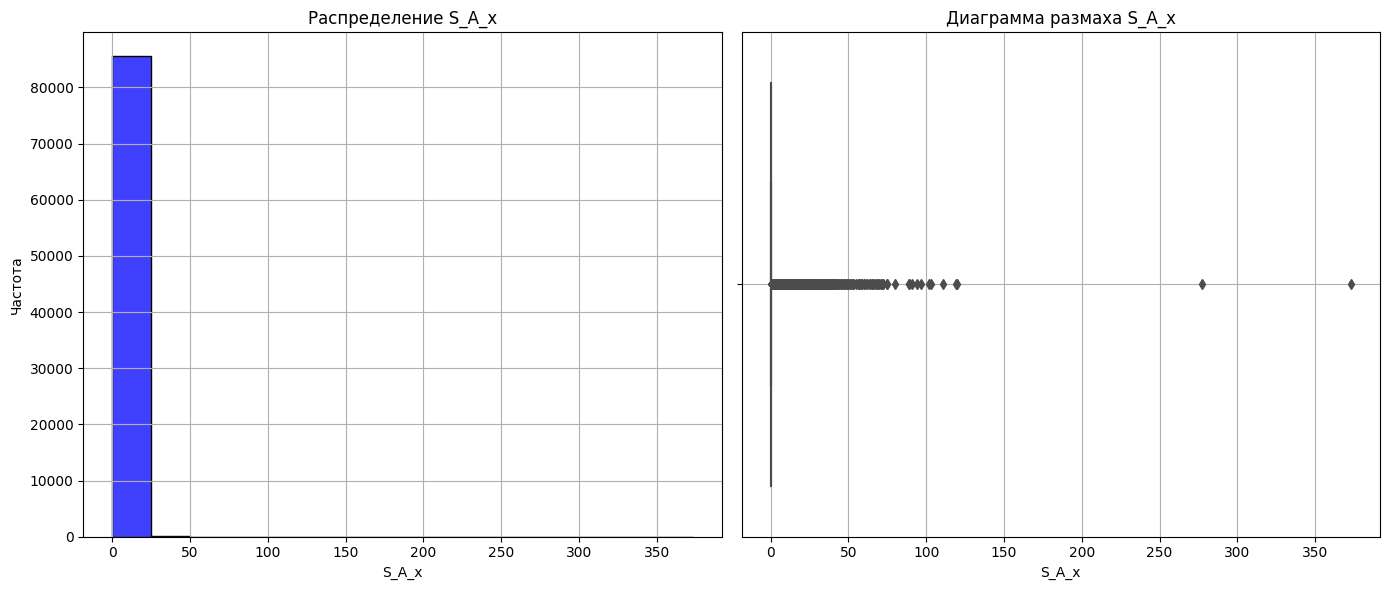

In [15]:
plot_histogram_and_boxplot(df_sender, 'S_A_x')

In [16]:
df[df['S_A_x'] > 60]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
104,106,40228617,75042088,2019-03-10 22:48:06,0,MOBILEAPI,2019-03-10,80.0,21.0,15.0,0.0,0.0,0.0,0.0,74.0,0.0,22.0,0.0,12.0,16618.63,58786.00,12002.98,0.0,0.00,0.0,0.0,26987.90,0.00,59308.00,0.00,38256.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.00,116131.99,0.00,0.0,0.0,0.0,0.0,290.00,0.00,68600.00,0.0,57700.0
155,158,CRM29076112,75042088,2019-03-10 23:30:23,0,MOBILEAPI,2019-03-10,68.0,30.0,4.0,0.0,0.0,0.0,0.0,89.0,3.0,14.0,0.0,3.0,388203.59,16362.52,1807.40,0.0,0.00,0.0,0.0,116019.50,1000.00,10173.10,0.00,4501.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.00,116131.99,0.00,0.0,0.0,0.0,0.0,290.00,0.00,68600.00,0.0,57700.0
8370,8698,106867811,96961522,2019-03-11 13:48:23,0,MOBILEAPI,2019-03-11,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,141000.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,600.00,301.0,0.0,14.0,6.0,0.0,0.0,0.0,0.0,76.0,1.0,17.0,0.0,22.0,0.00,20380.00,3876.00,0.0,0.0,0.0,0.0,30448.54,590.00,27580.00,0.0,56109.0
10393,10792,37317698,107233436,2019-03-11 16:07:06,0,MOBILEAPI,2019-03-11,68.0,9.0,2.0,0.0,0.0,0.0,0.0,46.0,1.0,12.0,1.0,2.0,78119.08,31058.18,1055.00,0.0,0.00,0.0,0.0,16988.36,100.00,32085.30,80.00,2800.0,0.0,450.0,0.0,0.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,37.0,0.00,946649.00,0.00,0.0,0.0,0.0,0.0,523979.49,0.00,0.00,0.0,1797300.0
10562,10967,66490555,107233436,2019-03-11 16:20:25,0,MOBILEAPI,2019-03-11,66.0,0.0,8.0,0.0,0.0,0.0,0.0,85.0,0.0,4.0,0.0,0.0,6492.36,0.00,2414.30,0.0,0.00,0.0,0.0,44172.17,0.00,16693.53,0.00,0.0,0.0,450.0,0.0,0.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,37.0,0.00,946649.00,0.00,0.0,0.0,0.0,0.0,523979.49,0.00,0.00,0.0,1797300.0
11313,11750,84974918,68136618,2019-03-11 17:22:41,0,MOBILEAPI,2019-03-11,66.0,22.0,13.0,0.0,0.0,0.0,0.0,60.0,0.0,49.0,2.0,15.0,12593.84,59681.00,8376.00,0.0,0.00,0.0,0.0,54434.53,0.00,96073.00,84.00,170357.0,0.0,163.0,6.0,0.0,0.0,0.0,0.0,104.0,0.0,52.0,0.0,0.0,0.00,496387.00,2487.00,0.0,0.0,0.0,0.0,310760.13,0.00,603621.60,0.0,0.0
11761,12209,43522991,MBK6410152,2019-03-11 18:05:22,0,MOBILEAPI,2019-03-11,119.0,75.0,5.0,0.0,0.0,0.0,0.0,60.0,0.0,10.0,1.0,27.0,31805.42,90115.00,1051.00,0.0,0.00,0.0,0.0,51632.83,0.00,155800.00,70.00,108913.0,0.0,405.0,0.0,0.0,0.0,0.0,0.0,26.0,2.0,144.0,3.0,0.0,0.00,1682641.45,0.00,0.0,0.0,0.0,0.0,18961.00,170.99,1649614.00,2800.0,0.0
12019,12477,84974918,103852295,2019-03-11 18:35:24,0,MOBILEAPI,2019-03-11,66.0,22.0,13.0,0.0,0.0,0.0,0.0,60.0,0.0,49.0,2.0,15.0,12593.84,59681.00,8376.00,0.0,0.00,0.0,0.0,54434.53,0.00,96073.00,84.00,170357.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,15.0,0.0,3.0,2.0,0.0,0.00,1950.00,211.00,0.0,0.0,0.0,0.0,2456.30,0.00,224.00,150.0,0.0
12342,12825,84974918,99537928,2019-03-11 19:27:18,0,MOBILEAPI,2019-03-11,66.0,22.0,13.0,0.0,0.0,0.0,0.0,60.0,0.0,49.0,2.0,15.0,12593.84,59681.00,8376.00,0.0,0.00,0.0,0.0,54434.53,0.00,96073.00,84.00,170357.0,0.0,3.0,7.0,0.0,0.0,0.0,0.0,36.0,0.0,6.0,4.0,7.0,0.00,2700.00,1150.00,0.0,0.0,0.0,0.0,20258.87,0.00,15000.00,400.0,174003.0
13033,13590,85983787,67713096,2019-03-12 00:39:07,0,MOBILEAPI,2019-03-12,61.0,7.0,1.0,0.0,0.0,0.0,0.0,13.0,0.0,2.0,1.0,0.0,35624.49,16500.00,160.00,0.0,0.00,0.0,0.0,15959.35,0.00,660.00,55.00,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,44.0,0.0,3.0,7.0,4.0,0.00,12000.00,1320.00,0.0,0.0,0.0,0.0,43933.27,0.00,16800.00,1300.0,2502.0


#### S_A_y

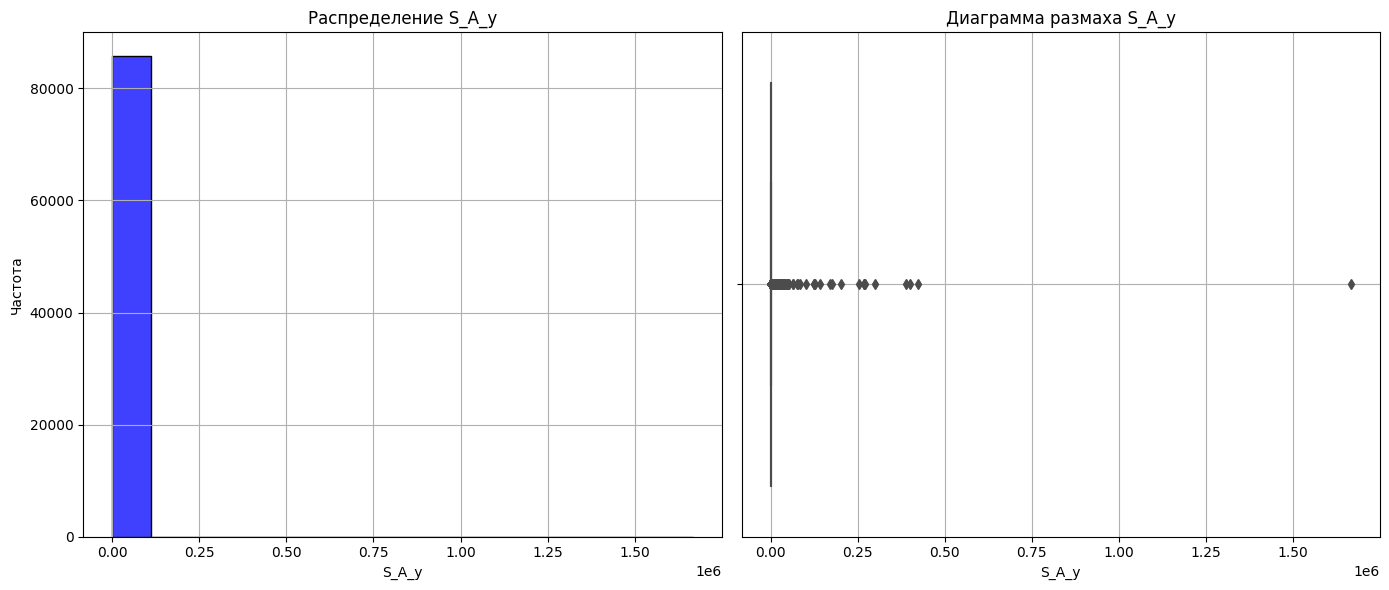

In [17]:
plot_histogram_and_boxplot(df_sender, 'S_A_y')

In [18]:
df[df['S_A_y'] > 100000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
155,158,CRM29076112,75042088,2019-03-10 23:30:23,0,MOBILEAPI,2019-03-10,68.0,30.0,4.0,0.0,0.0,0.0,0.0,89.0,3.0,14.0,0.0,3.0,388203.59,16362.52,1807.4,0.00,0.0,0.0,0.0,116019.50,1000.00,10173.10,0.0,4501.00,0.0,64.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,116131.99,0.0,0.0,0.0,0.0,0.0,290.00,0.0,68600.00,0.00,57700.0
183,186,105434759,26093443,2019-03-11 00:10:31,0,MOBILEAPI,2019-03-11,38.0,19.0,1.0,0.0,0.0,0.0,0.0,53.0,2.0,40.0,0.0,18.0,103019.29,225526.00,108.0,0.00,0.0,0.0,0.0,52380.52,2.10,118113.00,0.0,359354.00,0.0,564.0,0.0,0.0,0.0,0.0,0.0,157.0,0.0,0.0,0.0,16.0,0.0,1341346.00,0.0,0.0,0.0,0.0,0.0,374369.00,0.0,0.00,0.00,1665400.0
2425,2512,97418594,26093443,2019-03-11 07:35:31,0,MOBILEAPI,2019-03-11,43.0,16.0,8.0,0.0,0.0,0.0,0.0,208.0,0.0,29.0,1.0,6.0,203365.20,155126.00,3218.0,0.00,0.0,0.0,0.0,456957.97,0.00,107884.00,138.0,18102.00,0.0,564.0,0.0,0.0,0.0,0.0,0.0,157.0,0.0,0.0,0.0,16.0,0.0,1341346.00,0.0,0.0,0.0,0.0,0.0,374369.00,0.0,0.00,0.00,1665400.0
2730,2827,34958838,16533440,2019-03-11 07:59:13,0,MOBILEAPI,2019-03-11,1.0,1.0,2.0,1.0,0.0,0.0,0.0,33.0,2.0,1.0,2.0,1.0,175017.17,110.00,553.2,30.00,0.0,0.0,0.0,9957.00,929.00,100000.00,23.5,25.99,0.0,6.0,8.0,0.0,0.0,0.0,0.0,48.0,0.0,16.0,4.0,5.0,0.0,116500.00,1606.0,0.0,0.0,0.0,0.0,25308.28,0.0,58090.00,184.00,129402.0
4394,4557,69227624,82377037,2019-03-11 09:44:38,0,MOBILEAPI,2019-03-11,28.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1666000.00,0.00,100.0,0.00,0.0,0.0,0.0,122.00,0.00,11000.00,100.0,0.00,0.0,33.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,21.0,0.0,7.0,0.0,81631.00,0.0,0.0,0.0,0.0,0.0,3547.00,0.0,49989.00,0.00,18000.0
6005,6231,38438625,83335933,2019-03-11 11:23:29,0,MOBILEAPI,2019-03-11,34.0,23.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,19.0,0.0,0.0,401400.00,23549.90,0.0,0.00,0.0,0.0,0.0,101295.96,0.00,23883.72,0.0,0.00,0.0,57.0,4.0,0.0,0.0,0.0,0.0,21.0,0.0,2.0,9.0,3.0,0.0,475018.00,1717.0,0.0,0.0,0.0,0.0,5703.67,0.0,155155.00,1305.00,252800.0
8370,8698,106867811,96961522,2019-03-11 13:48:23,0,MOBILEAPI,2019-03-11,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,141000.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,600.0,301.00,0.0,14.0,6.0,0.0,0.0,0.0,0.0,76.0,1.0,17.0,0.0,22.0,0.0,20380.00,3876.0,0.0,0.0,0.0,0.0,30448.54,590.0,27580.00,0.00,56109.0
14870,15529,89076366,104506205,2019-03-12 06:52:08,0,MOBILEAPI,2019-03-12,111.0,16.0,1.0,0.0,0.0,0.0,0.0,23.0,0.0,8.0,0.0,2.0,127920.79,105996.00,392.0,0.00,0.0,0.0,0.0,13829.63,0.00,39000.00,0.0,30000.00,0.0,202.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,16.0,0.0,2.0,0.0,279652.57,0.0,0.0,0.0,0.0,0.0,532821.28,0.0,19035.20,0.00,0.0
15377,16064,64824042,106495572,2019-03-12 07:31:12,0,MOBILEAPI,2019-03-12,36.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,3.0,0.0,8.0,125444.40,0.00,0.0,0.00,0.0,0.0,0.0,31800.50,0.00,11000.00,0.0,31504.00,0.0,25.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0,8.0,0.0,41.0,0.0,330385.02,160.0,0.0,0.0,0.0,0.0,42375.73,0.0,25800.04,0.00,871855.0
22656,23753,7062843,VSP20923971,2019-03-12 16:00:49,0,MOBILEAPI,2019-03-12,1.0,14.0,8.0,2.0,0.0,0.0,0.0,53.0,13.0,21.0,2.0,17.0,270543.42,477300.00,14533.0,78870.58,0.0,0.0,0.0,196587.03,51946.98,445825.00,18509.0,641405.70,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,2.0,0.0,0.00,1130.0,0.0,0.0,0.0,0.0,10435.00,0.0,770.00,0.00,60001.0


In [19]:
df[(df['S_A_x'] > 0) & (df['resolution'] == 1)].shape[0]

6

In [20]:
df[df['S_A_x'] > 0].shape[0]/df.shape[0]*100

1.5123777096281439

In [21]:
df[(df['S_A_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

0.5016722408026756

Выводы:
Данный признак является инaормативным лишь для 1 процента датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### S_С

#### S_C_x

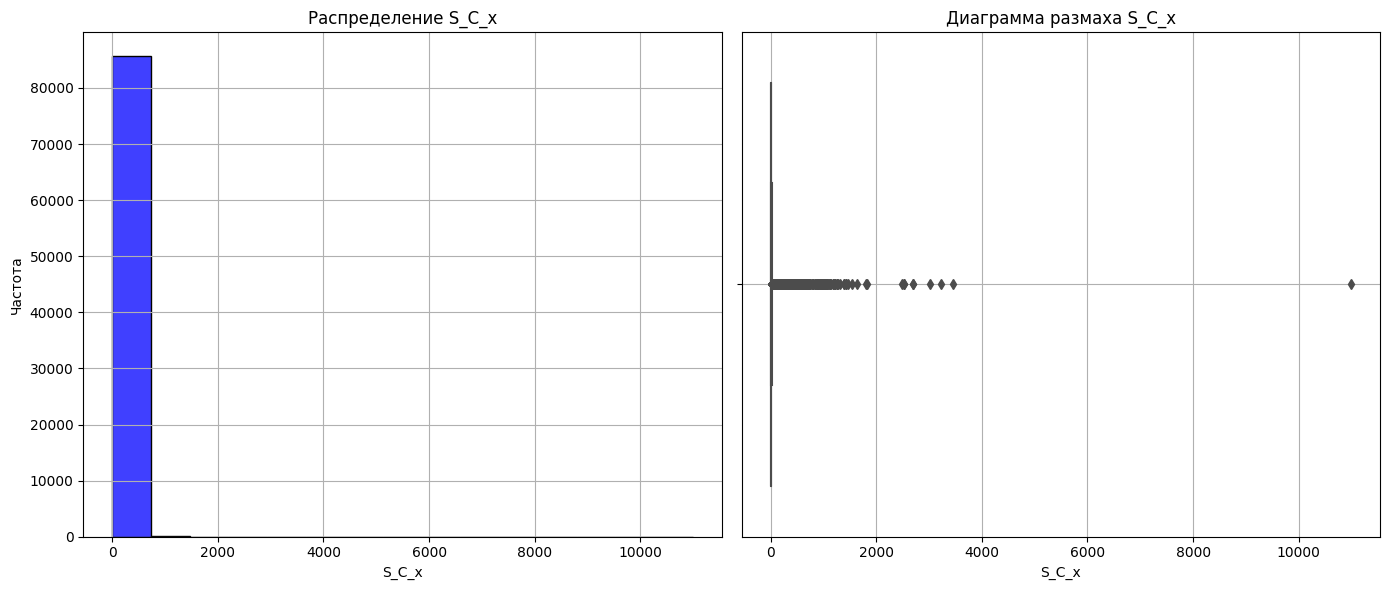

In [22]:
plot_histogram_and_boxplot(df_sender, 'S_C_x')

In [23]:
df[df['S_C_x'] > 4000] 

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
34495,36055,86867920,76080826,2019-03-13 16:38:30,0,ATMAPI,2019-03-13,0.0,10989.0,4.0,0.0,0.0,0.0,0.0,511.0,0.0,12.0,0.0,5.0,0.0,5941681.57,2762.0,0.0,0.0,0.0,0.0,313456.55,0.0,2910452.0,0.0,22600.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,15.0,0.0,6.0,0.0,9.0,0.0,213000.0,1905.0,0.0,0.0,0.0,0.0,35176.0,0.0,19140.0,0.0,130801.0


#### S_C_y

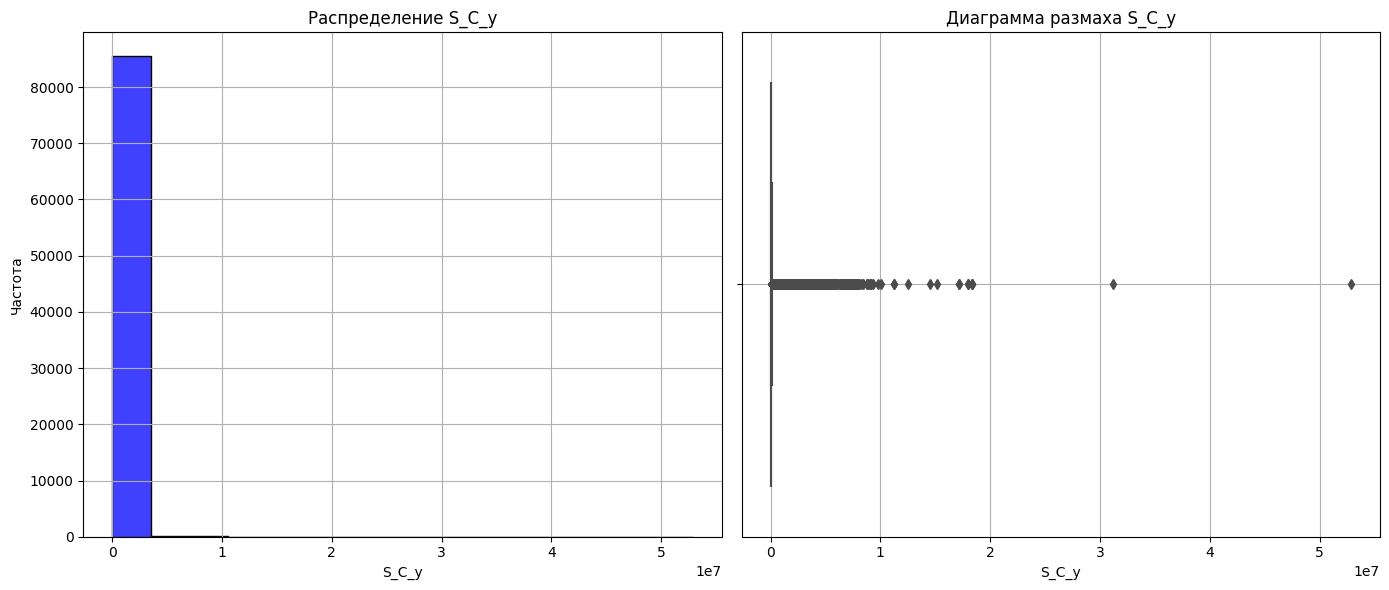

In [24]:
plot_histogram_and_boxplot(df_sender, 'S_C_y')

In [25]:
df[df['S_C_y'] > 20000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
1042,1086,4969662,72056198,2019-03-11 05:16:59,0,WEBAPI,2019-03-11,0.0,6.0,2.0,3.0,0.0,4.0,0.0,10.0,0.0,9.0,0.0,0.0,0.0,31224998.0,2586.7,2330.2,0.0,3481.31,0.0,21877.48,0.0,91104998.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,5701.0
50384,52771,75413532,20628402,2019-03-15 05:20:01,0,MOBILEAPI,2019-03-15,0.0,9.0,2.0,0.0,0.0,0.0,0.0,25.0,0.0,9.0,1.0,12.0,0.0,52855400.0,2781.2,0.0,0.0,0.00,0.0,30388.47,0.0,52623400.0,4.7,4331.55,0.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,12.0,0.0,20.0,0.0,220552.77,0.0,0.0,0.0,0.0,0.0,17189.09,316.28,913402.77,0.0,890009.0


In [26]:
df[(df['S_C_x'] > 0)].shape[0]

69624

Признак достатоточно информативен, нужно будет лишь учесть наличие выбросов

### S_F

#### S_F_x

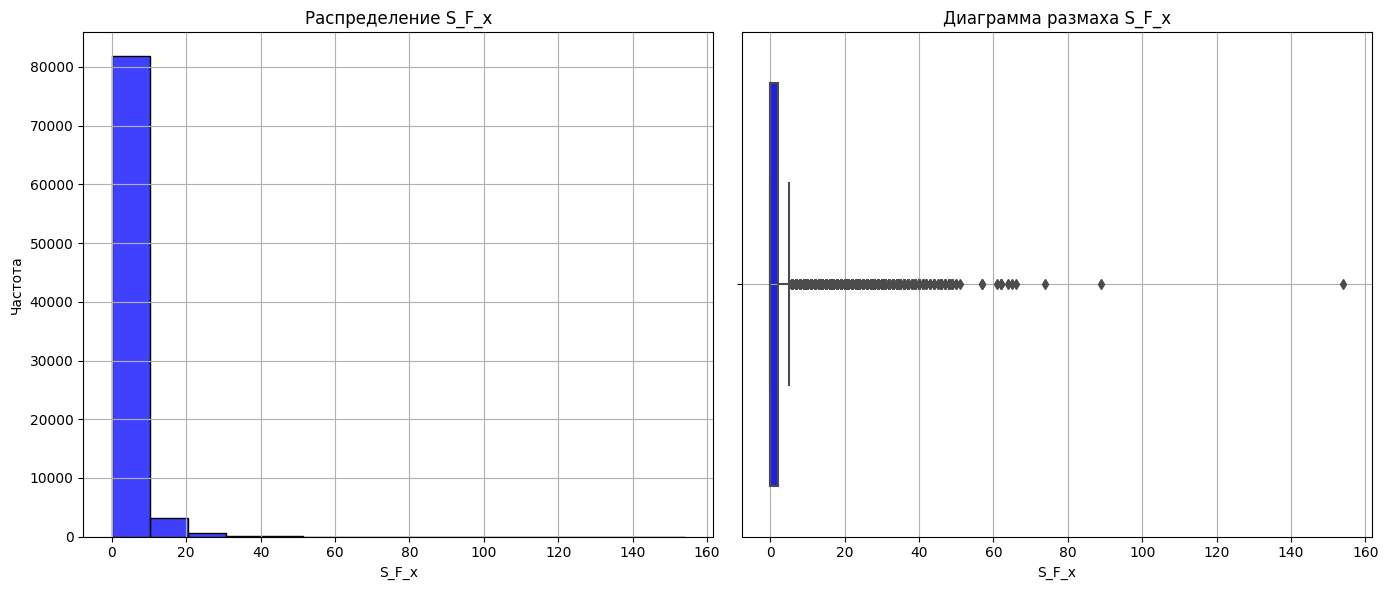

In [27]:
plot_histogram_and_boxplot(df_sender, 'S_F_x')

In [28]:
df[df['S_F_x'] > 80]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
18014,18844,67839300,58346508,2019-03-12 10:12:41,0,MOBILEAPI,2019-03-12,0.0,27.0,89.0,8.0,0.0,0.0,0.0,63.0,0.0,47.0,4.0,0.0,0.0,1731800.0,377310.00,45295.0,0.0,0.0,0.0,536151.72,0.0,951066.00,25256.96,0.0,0.0,3.0,12.0,2.0,0.0,0.0,0.0,18.0,0.0,6.0,2.0,0.0,0.0,10095.0,27720.1,6000.0,0.0,0.0,0.0,28518.71,0.0,35780.0,350.0,0.0
75596,79191,88308798,MBK10283630,2019-03-16 15:01:56,0,MOBILEAPI,2019-03-16,0.0,13.0,154.0,0.0,0.0,0.0,0.0,64.0,0.0,22.0,0.0,7.0,0.0,6369.0,29669.13,0.0,0.0,0.0,0.0,11820.09,0.0,45174.01,0.00,84003.0,0.0,253.0,38.0,0.0,0.0,0.0,0.0,195.0,0.0,26.0,0.0,1.0,0.0,1259348.0,72234.0,0.0,0.0,0.0,0.0,1252841.71,0.0,1249950.0,0.0,500.0


In [29]:
df[df['S_F_x'] > 1].shape[0]

25420

#### S_F_y

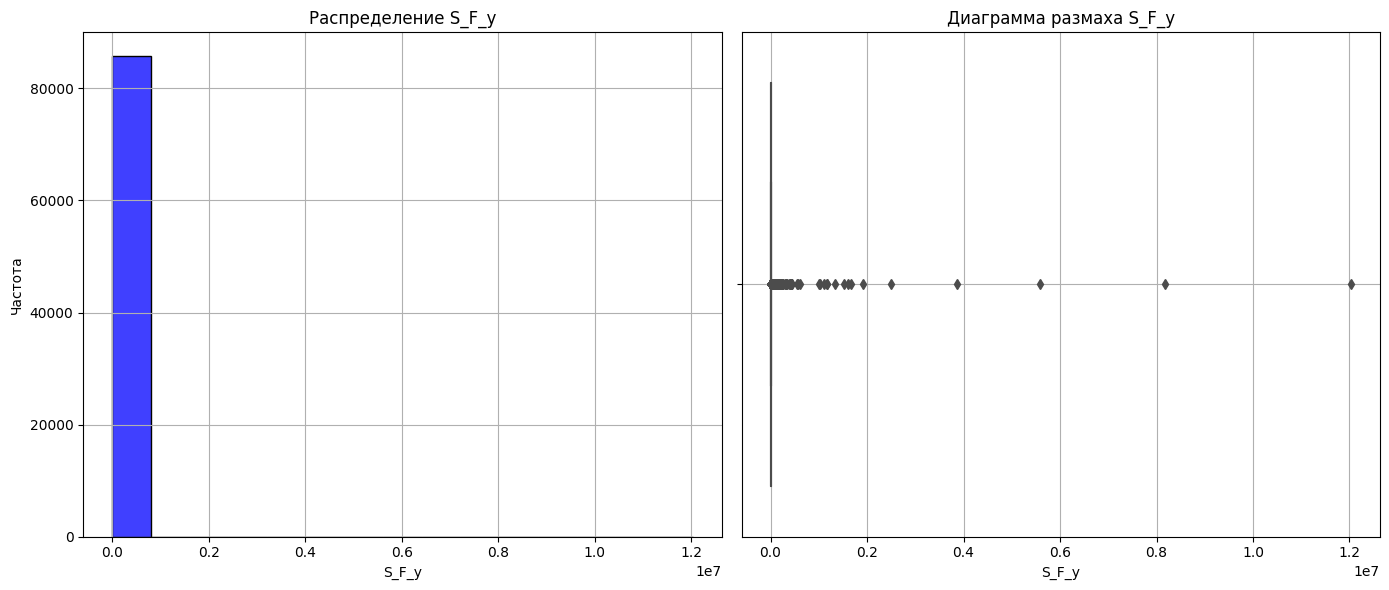

In [30]:
plot_histogram_and_boxplot(df_sender, 'S_F_y')

In [31]:
df[df['S_F_y'] > 2000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
21392,22417,103142170,70354846,2019-03-12 14:09:48,0,ATMAPI,2019-03-12,0.0,1.0,18.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,9.0,0.0,300000.0,12030916.00,0.00,0.0,0.0,0.0,8550.00,0.0,150000.0,0.0,125200.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,13.0,0.0,15.0,0.0,40700.0,0.0,0.0,0.0,0.0,0.0,247431.69,0.0,93700.0,0.0,138007.0
23429,24560,6765135,8739597,2019-03-12 17:14:26,0,WEBAPI,2019-03-12,0.0,1.0,19.0,13.0,0.0,0.0,0.0,31.0,0.0,0.0,2.0,1.0,0.0,3500.0,3859907.43,15060659.88,0.0,0.0,0.0,2157613.05,0.0,0.0,154.2,20.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,14.0,4.0,10.0,0.0,4.0,0.0,11110.6,1858.0,0.0,0.0,0.0,0.0,8953.44,1370.0,24010.6,0.0,35003.0
24718,25913,41331713,1081842,2019-03-12 23:41:24,0,MOBILEAPI,2019-03-12,0.0,8.0,12.0,0.0,0.0,0.0,0.0,20.0,0.0,9.0,0.0,3.0,0.0,23180.0,2493124.00,0.00,0.0,0.0,0.0,8611.94,0.0,31150.0,0.0,11901.0,0.0,44.0,8.0,0.0,0.0,0.0,0.0,149.0,8.0,32.0,0.0,11.0,0.0,1333600.0,5182.0,0.0,0.0,0.0,0.0,99530.96,14660.0,134414.0,0.0,675301.0
37308,38989,18920849,11397361,2019-03-14 05:46:46,0,MOBILEAPI,2019-03-14,0.0,7.0,24.0,1.0,0.0,0.0,0.0,17.0,0.0,9.0,0.0,3.0,0.0,423600.0,5575587.00,211750.00,0.0,0.0,0.0,2772510.50,0.0,190050.0,0.0,5549999.0,0.0,14.0,19.0,4.0,0.0,0.0,0.0,71.0,0.0,24.0,0.0,9.0,0.0,256940.0,13858.2,6359.0,0.0,0.0,0.0,63189.46,0.0,180740.0,0.0,291101.0
59032,61794,53557966,92704841,2019-03-15 12:09:30,0,MOBILEAPI,2019-03-15,0.0,2.0,10.0,3.0,0.0,0.0,0.0,12.0,1.0,3.0,1.0,1.0,0.0,350000.0,8177001.68,3542880.00,0.0,0.0,0.0,11058862.00,114.0,46700.0,15225000.0,3000000.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,7.0,0.0,229951.0,0.0,0.0,0.0,0.0,0.0,50055.60,0.0,0.0,0.0,534000.0


In [32]:
df[df['S_F_x'] > 0].shape[0]

36105

### S_H

#### S_H_x

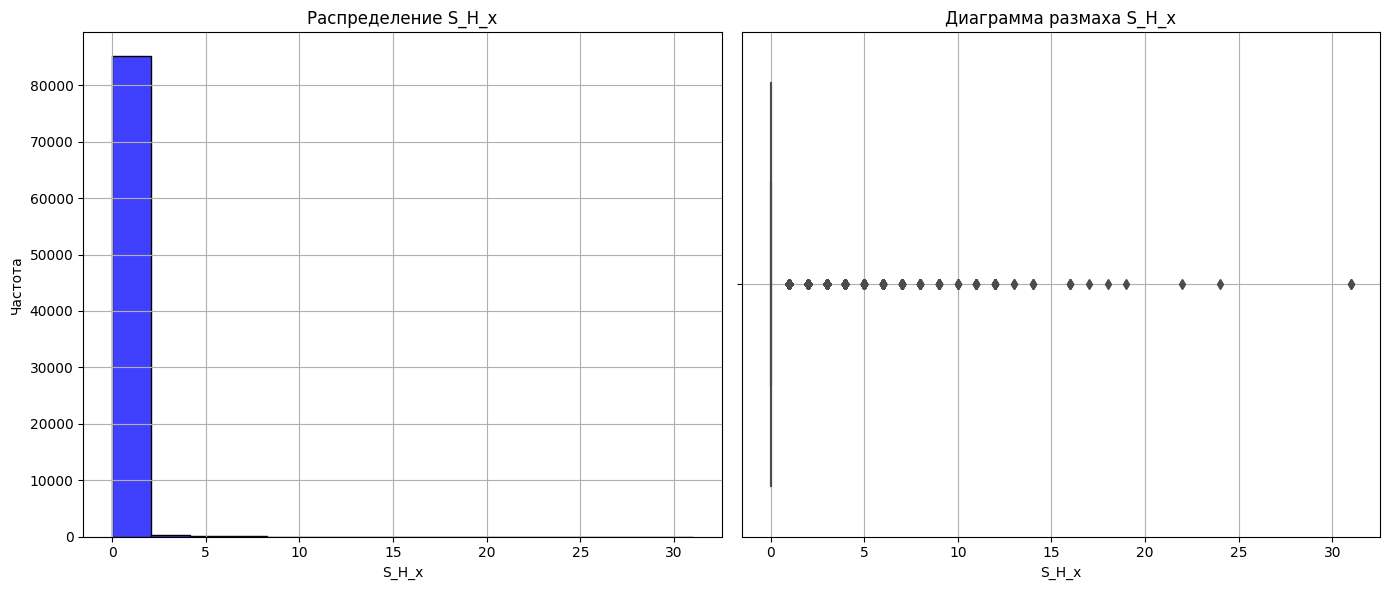

In [33]:
plot_histogram_and_boxplot(df_sender, 'S_H_x') 

#### S_H_y

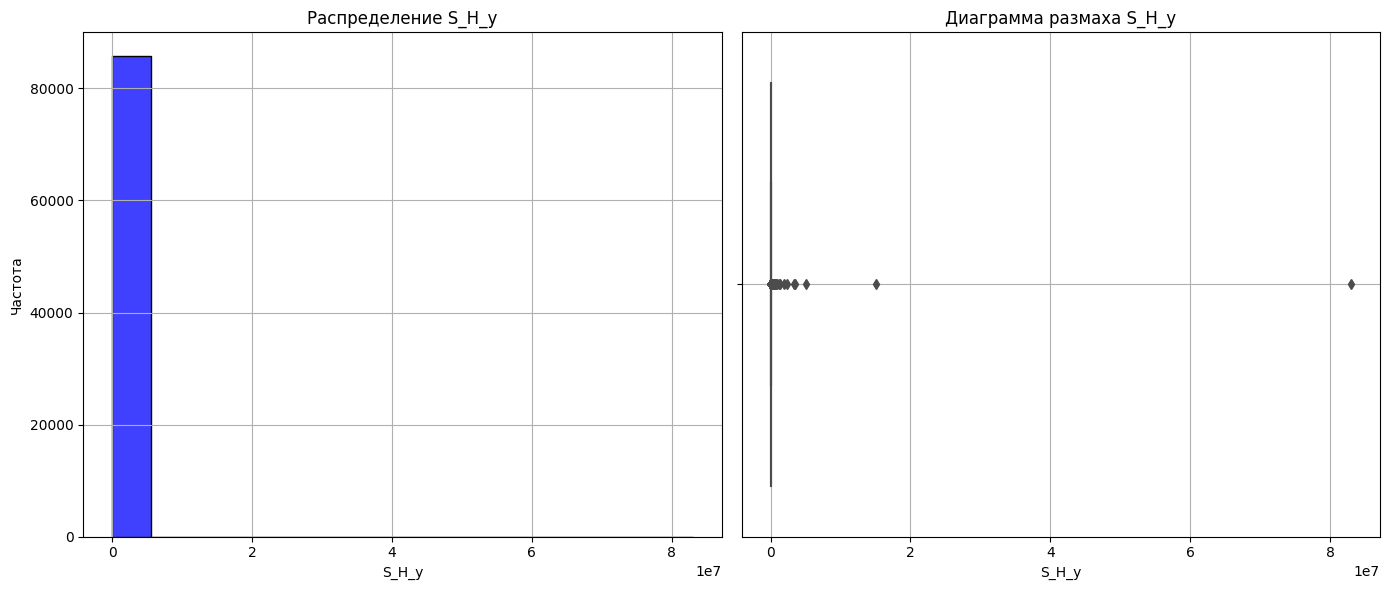

In [34]:
plot_histogram_and_boxplot(df_sender, 'S_H_y') 

In [35]:
df[(df['S_H_x'] > 0) & (df['resolution'] == 1)].shape[0]

13

In [36]:
df[df['S_H_x'] > 0].shape[0]/df.shape[0]*100  

3.0119287771545844

In [37]:
df[(df['S_H_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

1.0869565217391304

Выводы:
Данный признак является инaормативным лишь для 1 процента датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### S_J

#### S_J_x

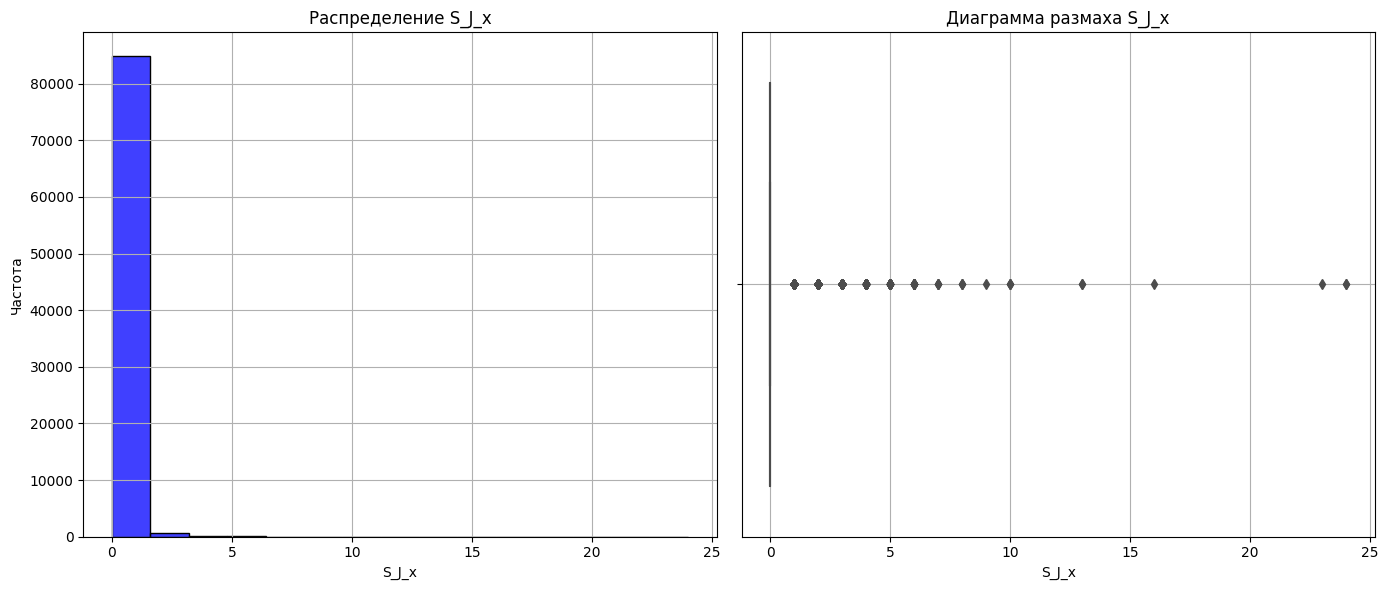

In [38]:
plot_histogram_and_boxplot(df_sender, 'S_J_x') 

In [39]:
df[df['S_J_x'] > 0].shape[0]

2554

#### S_J_y

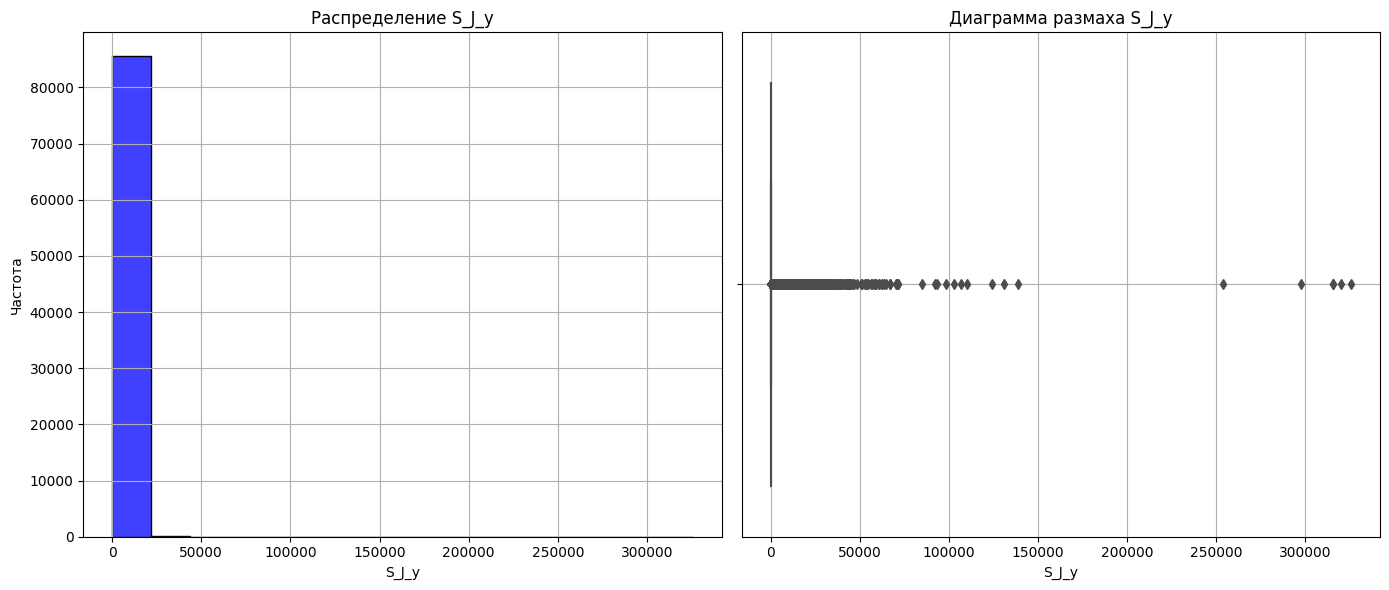

In [40]:
plot_histogram_and_boxplot(df_sender, 'S_J_y') 

In [41]:
df[(df['S_J_x'] > 0) & (df['resolution'] == 1)].shape[0]

26

In [42]:
df[df['S_J_x'] > 0].shape[0]/df.shape[0]*100 

2.978113084341002

In [43]:
df[(df['S_J_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

2.1739130434782608

Выводы:
Данный признак является инaормативным лишь для 3 процентов датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### S_O

#### S_O_x

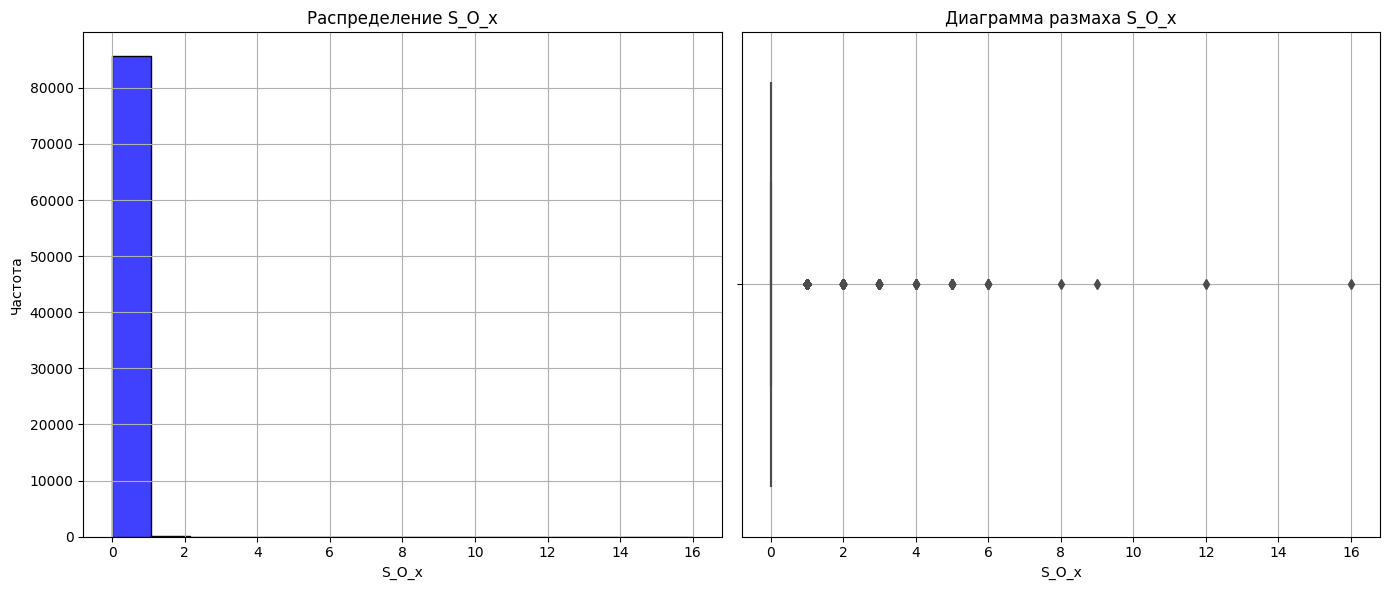

In [44]:
plot_histogram_and_boxplot(df_sender, 'S_O_x') 

In [45]:
df[df['S_O_x'] > 0].shape[0]

328

#### S_O_y

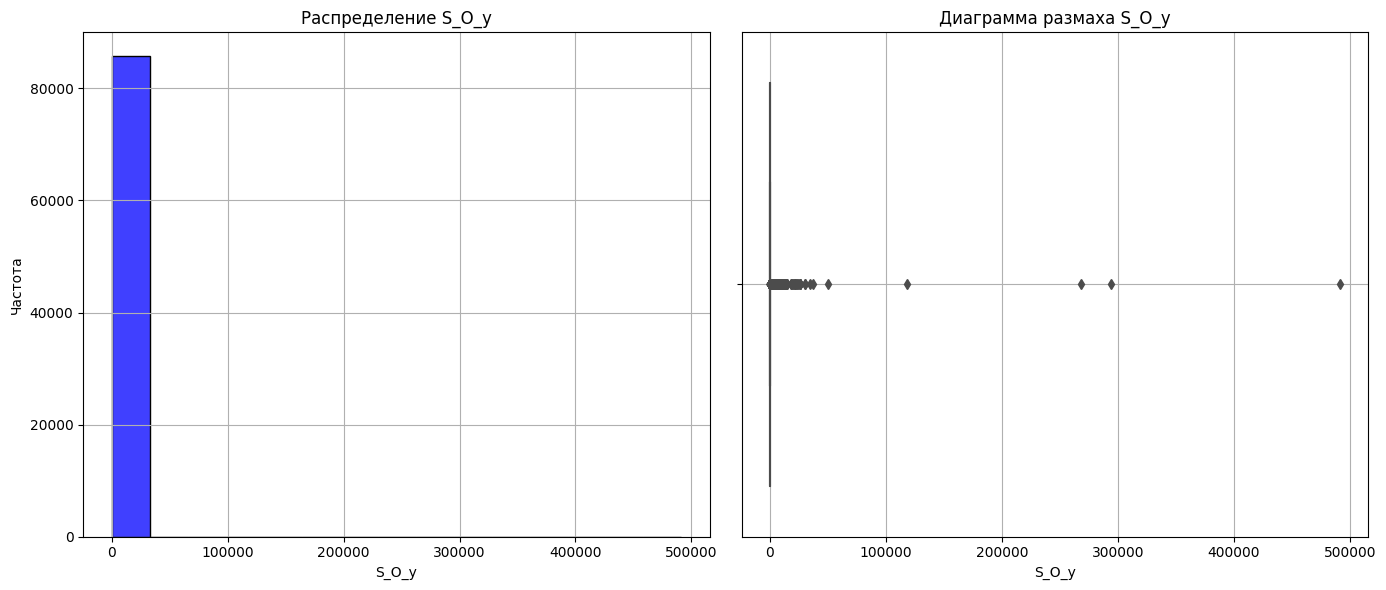

In [46]:
plot_histogram_and_boxplot(df_sender, 'S_O_y') 

In [47]:
df[(df['S_O_x'] > 0) & (df['resolution'] == 1)].shape[0]

0

In [48]:
df[df['S_O_x'] > 0].shape[0]/df.shape[0]*100 

0.38246714630534406

In [49]:
df[(df['S_O_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

0.0

Данный признак не имеет смысла. Его стоит отбросить

### S_Q

#### S_Q_x

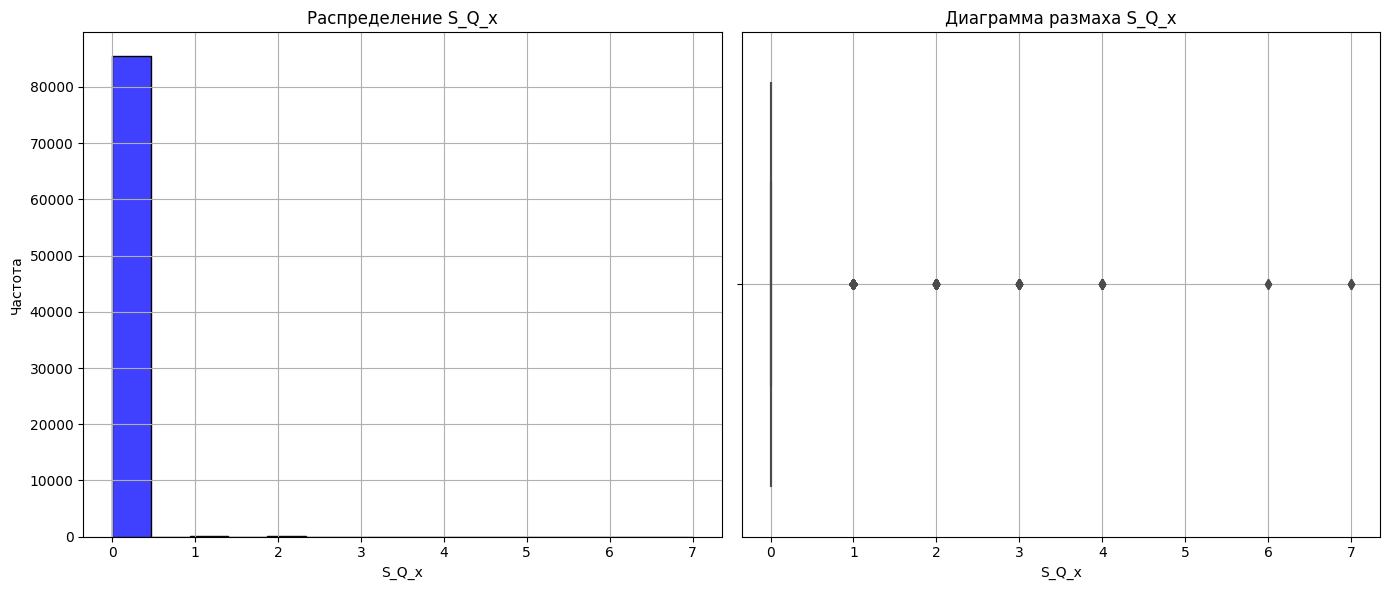

In [50]:
plot_histogram_and_boxplot(df_sender, 'S_Q_x') 

In [51]:
df[df['S_Q_x'] > 0].shape[0]

296

#### S_Q_y

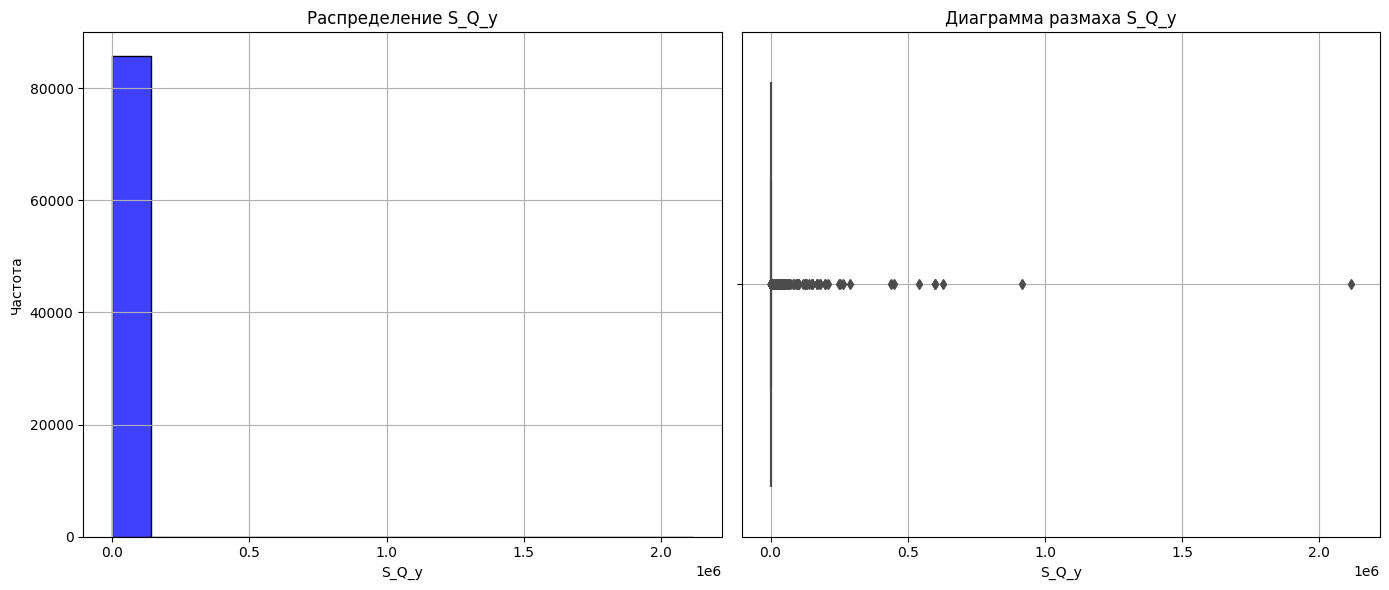

In [52]:
plot_histogram_and_boxplot(df_sender, 'S_Q_y') 

In [53]:
df[(df['S_Q_x'] > 0) & (df['resolution'] == 1)].shape[0]

2

In [54]:
df[df['S_Q_x'] > 0].shape[0]/df.shape[0]*100 

0.3451532783731154

In [55]:
df[(df['S_Q_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

0.16722408026755853

Данный признак имеет смысл бинаризировать

### S_R

#### S_R_x

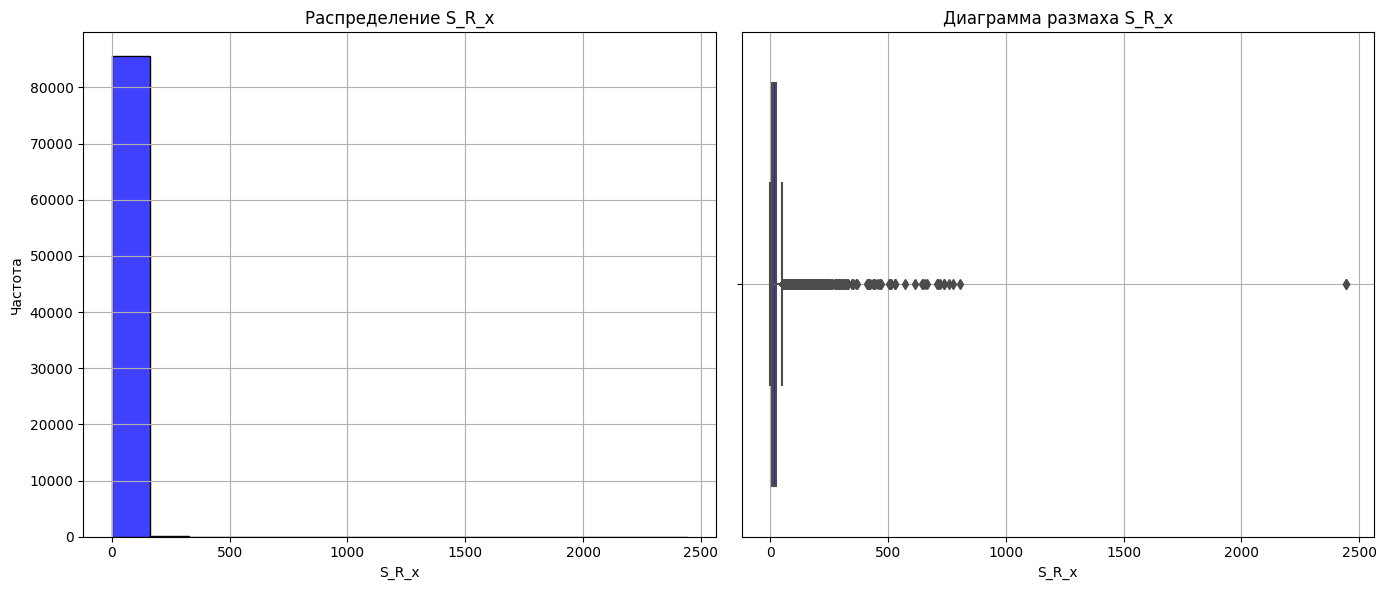

In [56]:
plot_histogram_and_boxplot(df_sender, 'S_R_x') 

In [57]:
df[df['S_R_x'] > 1000] 

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
41093,42935,MBK5646955,26024246,2019-03-14 10:31:14,0,MOBILEAPI,2019-03-14,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2442.0,0.0,4.0,0.0,4.0,0.0,14950.0,0.0,0.0,0.0,0.0,0.0,6788393.57,0.0,30100.0,0.0,10602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4596.0,0.0,512.0,0.0,12001.0
41122,42965,MBK5646955,26024246,2019-03-14 10:33:02,0,MOBILEAPI,2019-03-14,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2442.0,0.0,4.0,0.0,4.0,0.0,14950.0,0.0,0.0,0.0,0.0,0.0,6788393.57,0.0,30100.0,0.0,10602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4596.0,0.0,512.0,0.0,12001.0


#### S_R_y

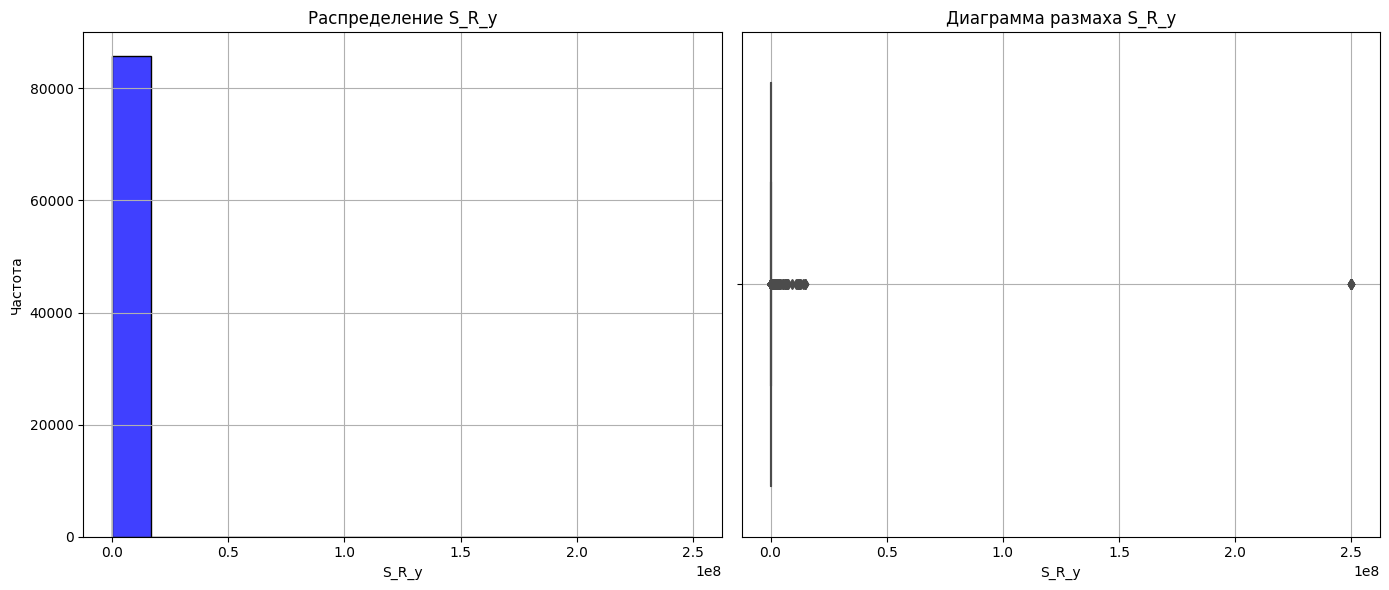

In [58]:
plot_histogram_and_boxplot(df_sender, 'S_R_y') 

In [59]:
df[df['S_R_y'] > 100000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
12211,12683,80307100,36141126,2019-03-11 19:03:09,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12215,12688,80307100,36141126,2019-03-11 19:03:37,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12222,12695,80307100,36141126,2019-03-11 19:04:06,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12230,12703,80307100,36141126,2019-03-11 19:05:07,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12238,12711,80307100,36141126,2019-03-11 19:06:26,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12241,12714,80307100,108711575,2019-03-11 19:07:12,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12249,12723,80307100,108711575,2019-03-11 19:08:15,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12256,12730,80307100,108711575,2019-03-11 19:09:25,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12259,12734,80307100,108711575,2019-03-11 19:10:06,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12431,12925,80307100,68232648,2019-03-11 19:43:32,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Данный признак не имеет выбросов по y

### S_T

#### S_T_x

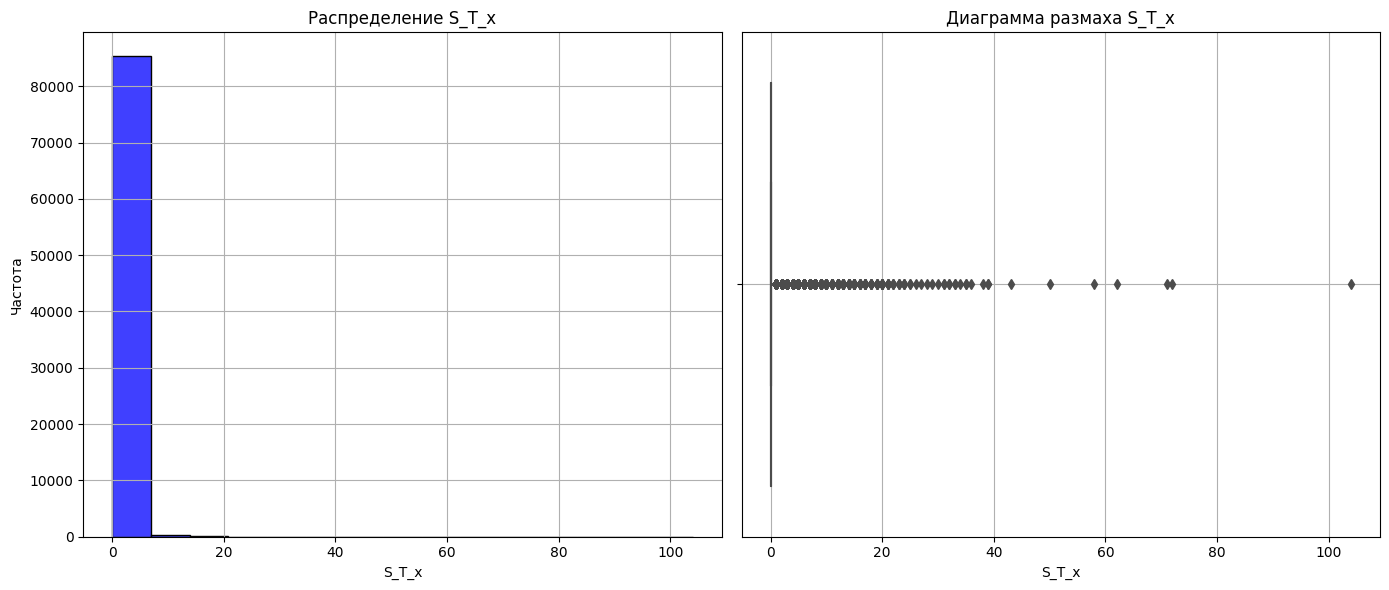

In [60]:
plot_histogram_and_boxplot(df_sender, 'S_T_x') 

In [61]:
df[df['S_T_x'] > 65] 

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
39402,41173,96605476,48032651,2019-03-14 08:49:14,0,MOBILEAPI,2019-03-14,0.0,2.0,0.0,0.0,0.0,0.0,0.0,11.0,72.0,3.0,0.0,1.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0,12108.74,3377.00,27800.0,0.0,3000.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,10.0,0.0,4.0,0.0,12000.0,773.0,0.0,0.0,0.0,37000.0,200.00,0.0,22980.0,0.0,17001.0
49821,52182,45470563,5402523,2019-03-15 03:38:15,0,MOBILEAPI,2019-03-15,0.0,28.0,0.0,0.0,0.0,0.0,0.0,15.0,104.0,14.0,0.0,16.0,0.0,193705.0,0.0,0.0,0.0,0.0,0.0,25785.00,70942.53,115825.0,0.0,101507.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,41.0,18.0,22.0,0.0,11.0,0.0,39150.0,0.0,0.0,0.0,0.0,0.0,102098.11,2970.0,119271.0,0.0,133505.0
78119,81814,53165169,109550059,2019-03-16 19:09:53,0,ATMAPI,2019-03-16,0.0,4.0,0.0,0.0,0.0,0.0,0.0,47.0,71.0,4.0,0.0,96.0,0.0,14500.0,0.0,0.0,0.0,0.0,0.0,190509.00,168850.00,33700.0,0.0,220298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


#### S_T_y

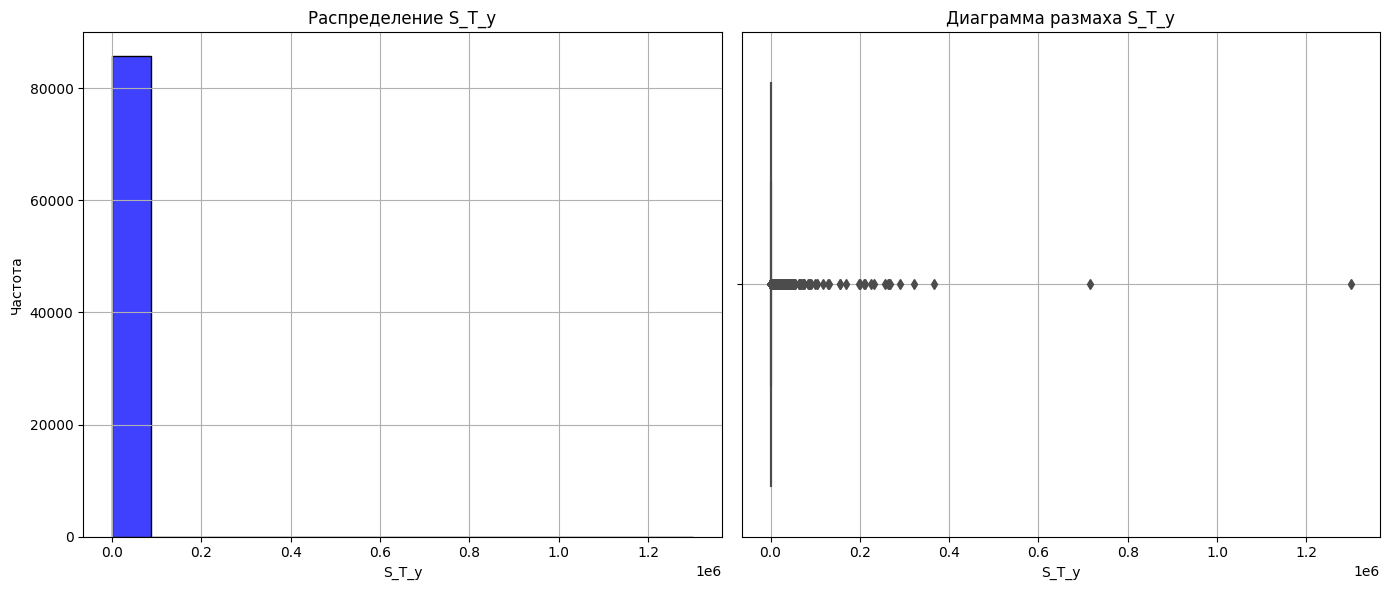

In [62]:
plot_histogram_and_boxplot(df_sender, 'S_T_y') 

In [63]:
df[df['S_T_y'] > 400000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
60742,63590,108621034,92932055,2019-03-15 13:33:43,0,MOBILEAPI,2019-03-15,0.0,35.0,6.0,0.0,0.0,0.0,0.0,74.0,15.0,56.0,0.0,3.0,0.0,1033440.00,971.96,0.0,0.0,0.0,0.0,388746.00,1300000.0,1836808.00,0.0,97501.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0,100.0,78.0,0.0,0.0,0.0,0.0,719.9,0.0,0.0,0.0,495000.0
70379,73754,10531494,63272135,2019-03-16 09:02:37,0,MOBILEAPI,2019-03-16,0.0,13.0,2.0,0.0,0.0,0.0,0.0,64.0,3.0,16.0,2.0,18.0,0.0,76042.38,1075.00,0.0,0.0,0.0,0.0,323943.31,715200.0,128092.38,610.0,1153509.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,8.0,0.0,14.0,0.0,55500.0,0.0,0.0,0.0,0.0,0.0,1900.0,0.0,48180.0,0.0,79306.0


### S_U

#### S_U_x

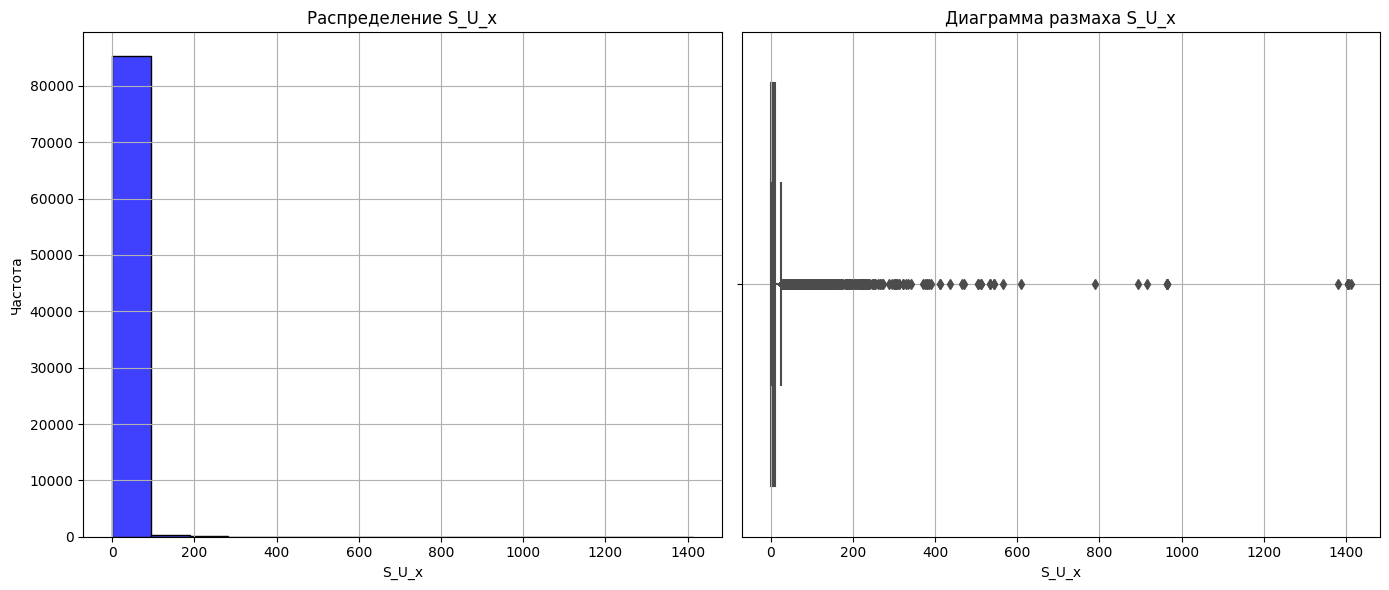

In [64]:
plot_histogram_and_boxplot(df_sender, 'S_U_x') 

In [65]:
df[df['S_U_x'] > 1000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
2117,2199,44199041,31454463,2019-03-11 07:11:49,0,MOBILEAPI,2019-03-11,0.0,66.0,2.0,0.0,0.0,0.0,0.0,281.0,0.0,1381.0,2.0,9.0,0.0,1737474.0,800.0,0.0,0.0,0.0,0.0,203922.03,0.00,1513994.0,11318.0,15503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.00,0.00,0.0,0.0,0.0
15242,15926,44199041,75593039,2019-03-12 07:22:52,0,MOBILEAPI,2019-03-12,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1405.0,2.0,11.0,0.0,1714402.0,800.0,0.0,0.0,0.0,0.0,200589.28,3.56,1571505.0,11318.0,15754.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,1.0,0.0,2000.0,0.0,0.0,0.0,0.0,0.0,1517.44,0.00,0.0,0.0,1500.0
17844,18669,44199041,66049569,2019-03-12 10:02:46,0,MOBILEAPI,2019-03-12,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1405.0,2.0,11.0,0.0,1714402.0,800.0,0.0,0.0,0.0,0.0,200589.28,3.56,1571505.0,11318.0,15754.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0,6.0,0.0,8.0,0.0,37329.0,0.0,0.0,0.0,0.0,0.0,15456.08,208.33,4700.0,0.0,22700.0
17982,18809,44199041,29904538,2019-03-12 10:10:26,0,MOBILEAPI,2019-03-12,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1405.0,2.0,11.0,0.0,1714402.0,800.0,0.0,0.0,0.0,0.0,200589.28,3.56,1571505.0,11318.0,15754.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,28.0,0.0,4.0,0.0,4.0,0.0,0.0,515.0,0.0,0.0,0.0,0.0,8038.56,0.00,5950.0,0.0,15900.0
18208,19059,44199041,VSP15877066,2019-03-12 10:25:49,0,MOBILEAPI,2019-03-12,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1405.0,2.0,11.0,0.0,1714402.0,800.0,0.0,0.0,0.0,0.0,200589.28,3.56,1571505.0,11318.0,15754.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1440.00,0.00,0.0,0.0,0.0
22543,23635,44199041,100569042,2019-03-12 15:50:01,0,MOBILEAPI,2019-03-12,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1405.0,2.0,11.0,0.0,1714402.0,800.0,0.0,0.0,0.0,0.0,200589.28,3.56,1571505.0,11318.0,15754.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,0.0,10.0,0.0,698.2,0.0,0.0,0.0,0.0,0.0,1046.79,0.00,6000.0,0.0,9903.0
27437,28726,44199041,77950834,2019-03-13 08:32:07,0,MOBILEAPI,2019-03-13,0.0,68.0,2.0,0.0,0.0,0.0,0.0,279.0,3.0,1412.0,2.0,8.0,0.0,1780930.0,800.0,0.0,0.0,0.0,0.0,200941.53,3.56,1560547.0,11318.0,7353.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,7.0,0.0,2.0,0.0,7025.0,179.0,0.0,0.0,0.0,0.0,2226.00,0.00,4900.0,0.0,501.0


#### S_U_y

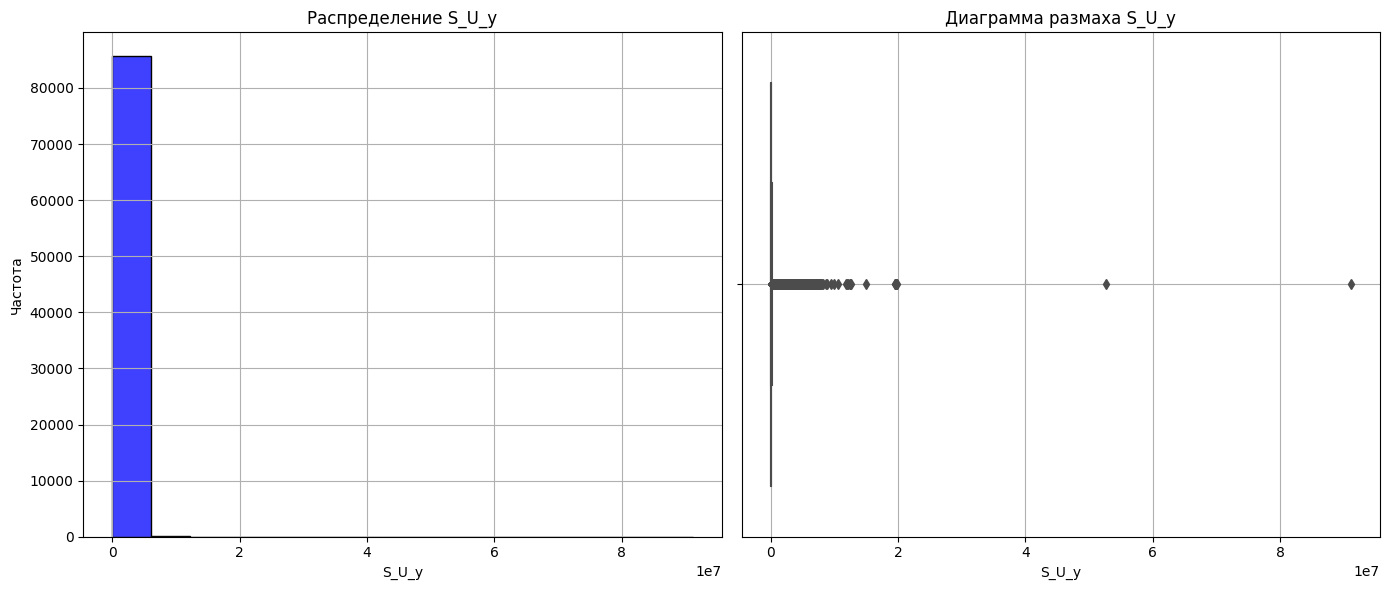

In [66]:
plot_histogram_and_boxplot(df_sender, 'S_U_y') 

In [67]:
df[df['S_U_y'] > 20000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
1042,1086,4969662,72056198,2019-03-11 05:16:59,0,WEBAPI,2019-03-11,0.0,6.0,2.0,3.0,0.0,4.0,0.0,10.0,0.0,9.0,0.0,0.0,0.0,31224998.0,2586.7,2330.2,0.0,3481.31,0.0,21877.48,0.0,91104998.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,5701.0
50384,52771,75413532,20628402,2019-03-15 05:20:01,0,MOBILEAPI,2019-03-15,0.0,9.0,2.0,0.0,0.0,0.0,0.0,25.0,0.0,9.0,1.0,12.0,0.0,52855400.0,2781.2,0.0,0.0,0.00,0.0,30388.47,0.0,52623400.0,4.7,4331.55,0.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,12.0,0.0,20.0,0.0,220552.77,0.0,0.0,0.0,0.0,0.0,17189.09,316.28,913402.77,0.0,890009.0


### S_X

#### S_X_x

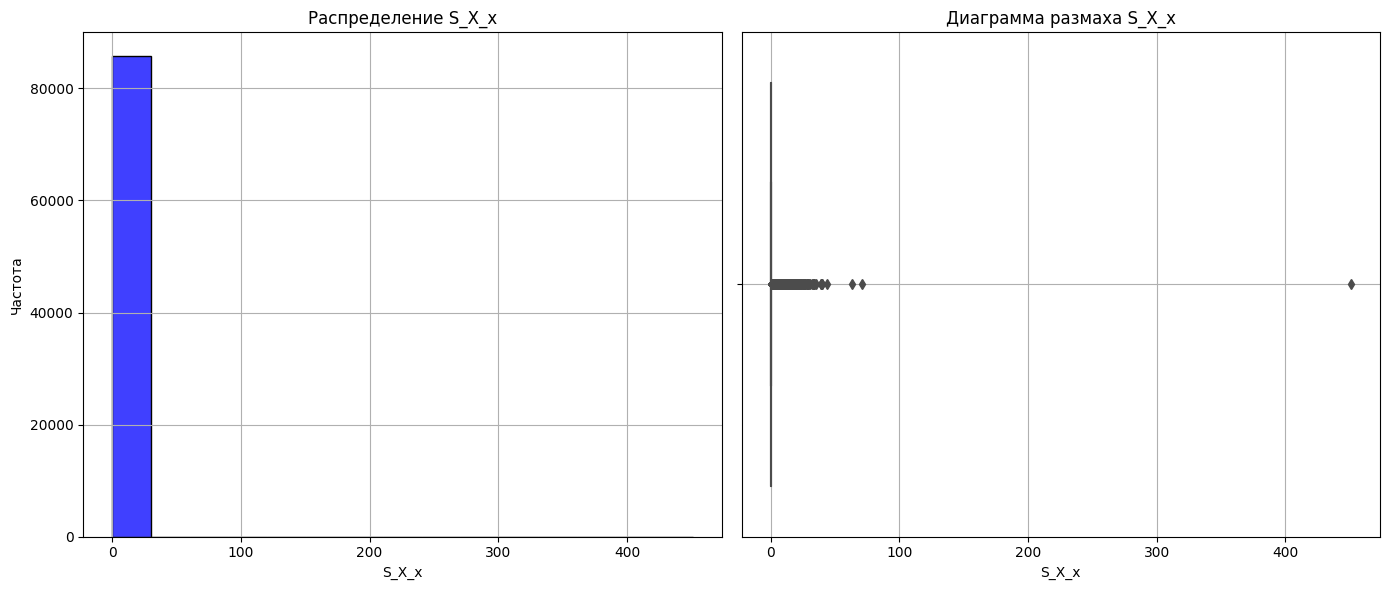

In [68]:
plot_histogram_and_boxplot(df_sender, 'S_X_x') 

In [69]:
df[df['S_X_x'] > 40]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
1138,1186,12328061,58424480,2019-03-11 05:30:49,0,MOBILEAPI,2019-03-11,0.0,74.0,1.0,0.0,0.0,0.0,0.0,54.0,0.0,49.0,44.0,0.0,0.0,846547.0,385.0,0.0,0.0,0.0,0.0,363938.46,0.0,346927.0,277361.87,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,2.0,2.0,1.0,0.0,2000.00,0.0,0.0,0.0,0.0,0.0,5295.81,0.0,137.0,600.0,13000.0
3070,3177,35665413,107156949,2019-03-11 08:25:55,0,ATMAPI,2019-03-11,0.0,7.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,63.0,26.0,0.0,4310.0,0.0,0.0,0.0,0.0,0.0,280.00,0.0,5600.0,1766.00,15408.0,0.0,264.0,0.0,0.0,0.0,0.0,0.0,147.0,0.0,30.0,0.0,0.0,0.0,557461.00,0.0,0.0,0.0,0.0,0.0,442342.50,0.0,601200.0,0.0,0.0
5935,6157,23341099,21832289,2019-03-11 11:20:04,0,MOBILEAPI,2019-03-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,71.0,6.0,0.0,27000.0,0.0,0.0,0.0,0.0,0.0,4080.00,0.0,81500.0,215000.00,56504.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,3.0,0.0,2.0,0.0,9000.00,0.0,0.0,0.0,0.0,0.0,38910.88,0.0,14900.0,0.0,19001.0
9252,9617,32263106,80600800,2019-03-11 14:47:48,0,MOBILEAPI,2019-03-11,0.0,1.0,3.0,0.0,0.0,0.0,0.0,13.0,1.0,3.0,451.0,0.0,0.0,20000.0,1623.0,0.0,0.0,0.0,0.0,16755.45,1100.0,3911.0,315500.00,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,19.0,0.0,7.0,0.0,912465.88,0.0,0.0,0.0,0.0,0.0,99217.74,0.0,408558.0,0.0,1043000.0


#### S_X_y

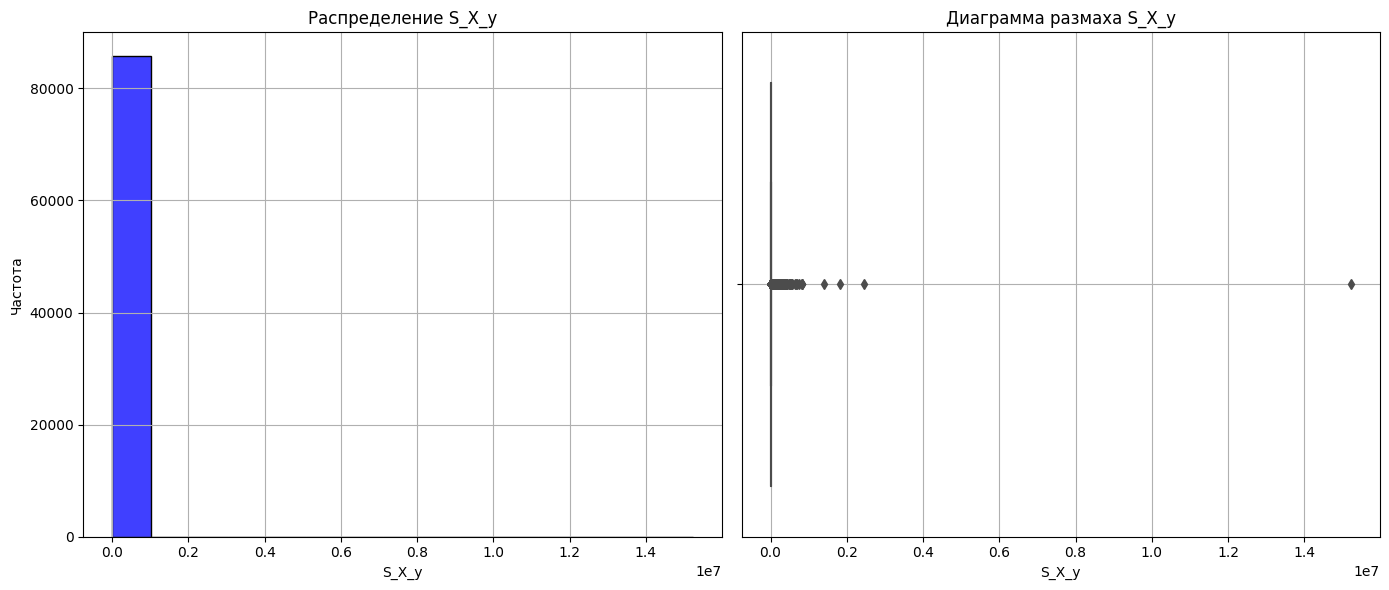

In [70]:
plot_histogram_and_boxplot(df_sender, 'S_X_y') 

In [71]:
df[df['S_X_y'] > 1000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
36327,37968,1137941,62728967,2019-03-13 22:20:11,0,MOBILEAPI,2019-03-13,0.0,2.0,13.0,1.0,0.0,0.0,0.0,23.0,4.0,24.0,4.0,0.0,0.0,100000.0,178637.00,5900.00,0.0,0.0,0.0,12448.90,922.46,656000.0,1834580.14,0.0,0.0,13.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,23.0,1.0,8.0,0.0,104140.0,934.00,0.00,0.0,0.0,0.0,975.00,0.0,66200.0,5892.0,85302.0
59032,61794,53557966,92704841,2019-03-15 12:09:30,0,MOBILEAPI,2019-03-15,0.0,2.0,10.0,3.0,0.0,0.0,0.0,12.0,1.0,3.0,1.0,1.0,0.0,350000.0,8177001.68,3542880.00,0.0,0.0,0.0,11058862.00,114.00,46700.0,15225000.00,3000000.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,7.0,0.0,229951.0,0.00,0.00,0.0,0.0,0.0,50055.60,0.0,0.0,0.0,534000.0
65664,68774,1686103,46277501,2019-03-15 18:07:25,0,MOBILEAPI,2019-03-15,0.0,20.0,3.0,2.0,0.0,0.0,0.0,23.0,1.0,7.0,15.0,0.0,0.0,973829.0,5496.80,310.17,0.0,0.0,0.0,107604.65,25867.43,94019.0,1399297.55,0.0,0.0,1.0,39.0,4.0,0.0,0.0,0.0,63.0,1.0,4.0,5.0,3.0,0.0,10000.0,20942.12,621.22,0.0,0.0,0.0,155579.34,2000.0,9200.0,387.8,19901.0
77028,80679,27792,15235400,2019-03-16 16:49:32,0,MOBILEAPI,2019-03-16,0.0,2.0,1.0,3.0,0.0,0.0,0.0,42.0,0.0,6.0,17.0,2.0,0.0,110000.0,146.00,7635.93,0.0,0.0,0.0,67225.28,0.00,171500.0,2464053.44,300001.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,4.0,0.0,1.0,0.0,6700.0,0.00,0.00,0.0,0.0,0.0,65513.42,0.0,48300.0,0.0,50000.0


### S_Z

#### S_Z_x

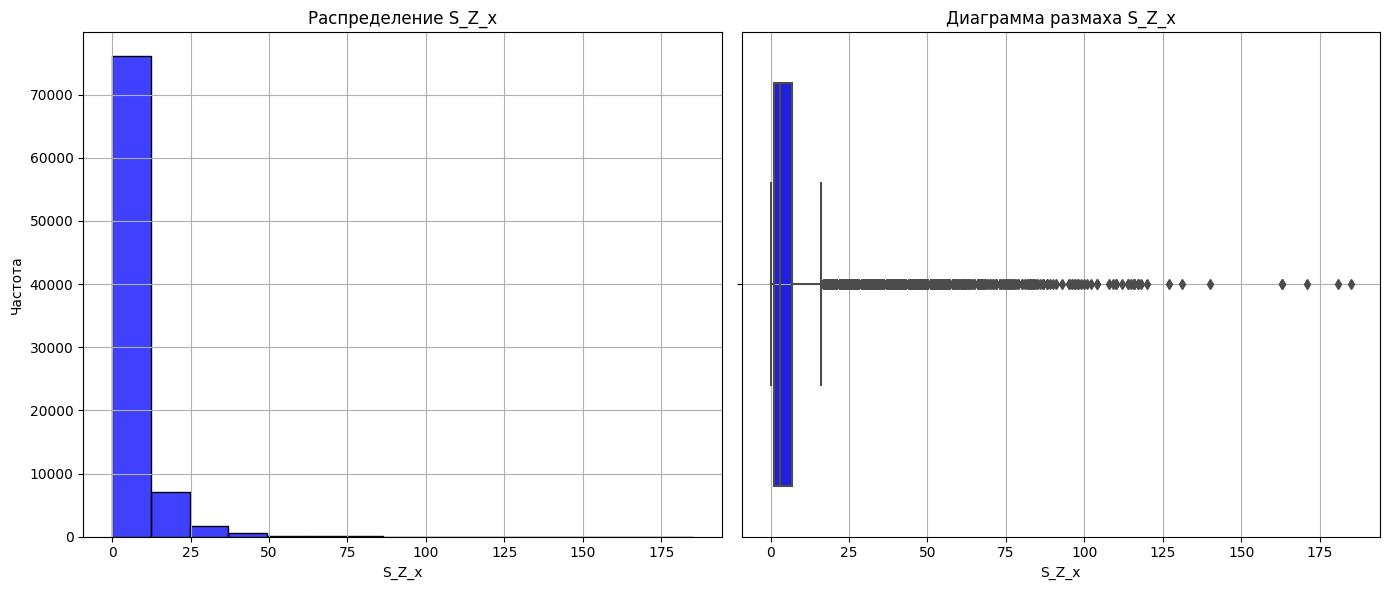

In [72]:
plot_histogram_and_boxplot(df_sender, 'S_Z_x') 

In [73]:
df[df['S_Z_x'] > 150]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
4802,4982,101711623,98323583,2019-03-11 10:10:21,0,ATMAPI,2019-03-11,0.0,12.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,44.0,0.0,181.0,0.0,445088.00,0.0,0.0,0.0,0.0,0.0,1797.35,0.0,1598500.00,0.0,1480974.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,0.0,55000.00,0.0,0.0,0.0,0.0,0.0,18643.80,0.0,0.00,0.0,800000.0
11238,11671,74712941,43314339,2019-03-11 17:16:09,0,MOBILEAPI,2019-03-11,0.0,44.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,62.0,0.0,185.0,0.0,3590843.10,181.0,0.0,0.0,0.0,0.0,948.00,0.0,4385929.70,0.0,10166168.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,27.0,0.0,1.0,0.0,1.0,0.0,28500.00,210.0,0.0,0.0,0.0,0.0,47398.33,0.0,500.00,0.0,1000.0
11499,11938,103894236,50226382,2019-03-11 17:36:57,0,MOBILEAPI,2019-03-11,0.0,122.0,1.0,0.0,0.0,0.0,0.0,60.0,1.0,52.0,0.0,163.0,0.0,1429194.00,940.0,0.0,0.0,0.0,0.0,150164.79,149.0,712725.69,0.0,741203.0,0.0,84.0,2.0,0.0,0.0,0.0,0.0,30.0,0.0,57.0,0.0,5.0,0.0,636043.17,1755.0,0.0,0.0,0.0,0.0,46204.46,0.0,355963.17,0.0,23300.0
23365,24495,10457057,93655524,2019-03-12 17:06:28,0,MOBILEAPI,2019-03-12,0.0,236.0,0.0,0.0,0.0,0.0,0.0,54.0,1.0,140.0,0.0,163.0,0.0,3125469.58,0.0,0.0,0.0,0.0,0.0,832867.00,6700.0,4006395.45,0.0,2981135.0,0.0,16.0,7.0,3.0,0.0,0.0,0.0,15.0,0.0,4.0,0.0,0.0,0.0,577200.00,9414.0,7000.0,0.0,0.0,0.0,52930.29,0.0,66500.00,0.0,0.0
42706,44629,74712941,58786253,2019-03-14 12:03:15,0,ATMAPI,2019-03-14,0.0,42.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,63.0,0.0,171.0,0.0,3152243.10,181.0,0.0,0.0,0.0,0.0,948.00,0.0,4043778.70,0.0,8273666.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,37.0,0.0,11.0,0.0,2.0,0.0,2750.00,965.0,0.0,0.0,0.0,0.0,88928.84,0.0,28000.00,0.0,22000.0


#### S_Z_y

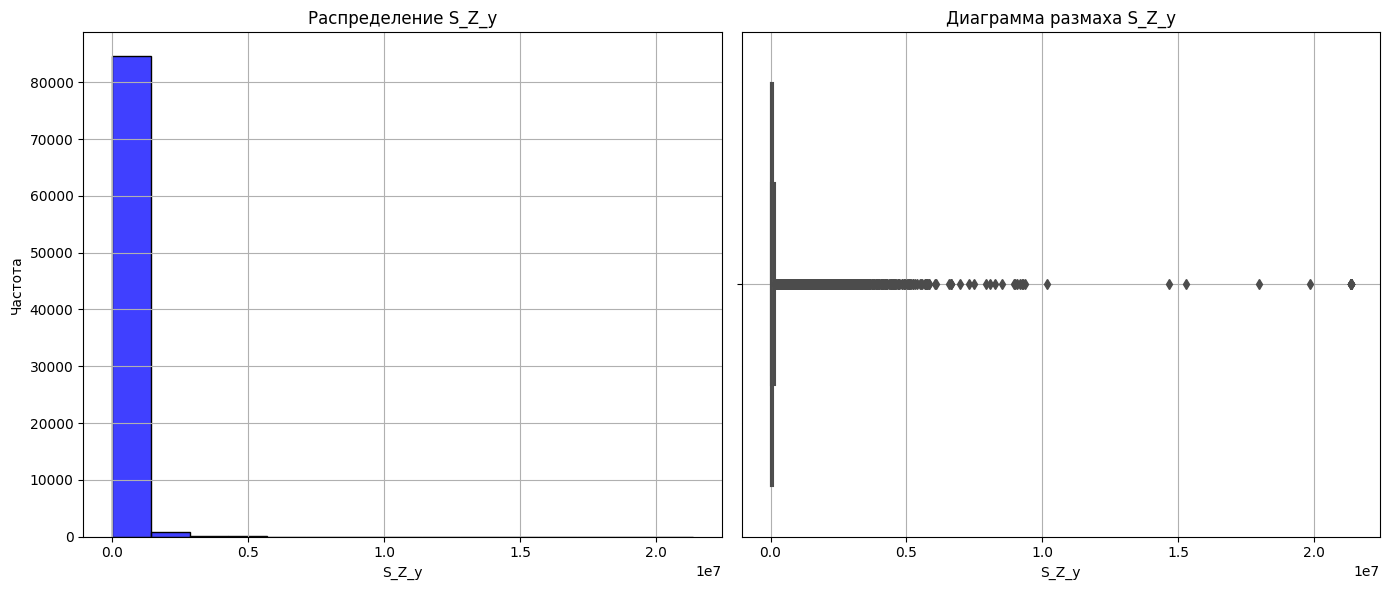

In [74]:
plot_histogram_and_boxplot(df_sender, 'S_Z_y') 

In [75]:
df[df['S_Z_y'] > 20000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
12211,12683,80307100,36141126,2019-03-11 19:03:09,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12215,12688,80307100,36141126,2019-03-11 19:03:37,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12222,12695,80307100,36141126,2019-03-11 19:04:06,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12230,12703,80307100,36141126,2019-03-11 19:05:07,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12238,12711,80307100,36141126,2019-03-11 19:06:26,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,74940.0,0.0,0.0,0.0,0.0,0.0,13050.0,0.0,73970.0,0.0,0.0
12241,12714,80307100,108711575,2019-03-11 19:07:12,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12249,12723,80307100,108711575,2019-03-11 19:08:15,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12256,12730,80307100,108711575,2019-03-11 19:09:25,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12259,12734,80307100,108711575,2019-03-11 19:10:06,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,24676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21693.0,0.0,0.0
12431,12925,80307100,68232648,2019-03-11 19:43:32,1,MOBILEAPI,2019-03-11,0.0,17.0,2.0,0.0,0.0,0.0,0.0,37.0,0.0,46.0,0.0,7.0,0.0,382928.0,424875.0,0.0,0.0,0.0,0.0,2.498713e+08,0.0,137750.0,0.0,21349993.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выбросов по y - нет

### Выводы по рассмотрению признаков отправителя

1. Убрать выбросы по Х - S_Z, S_R
2. Убрать выбросы по Х и У - S_X, S_U, S_T, S_F, S_C
3. Бинаризировать - S_Q (м.б отбросить), S_J (мб. оставить), S_H, S_A
4. Удалить - S_O

## Анализ признаков получателя

In [76]:
df_recipient = df[r_features]

### R_A

#### R_A_x

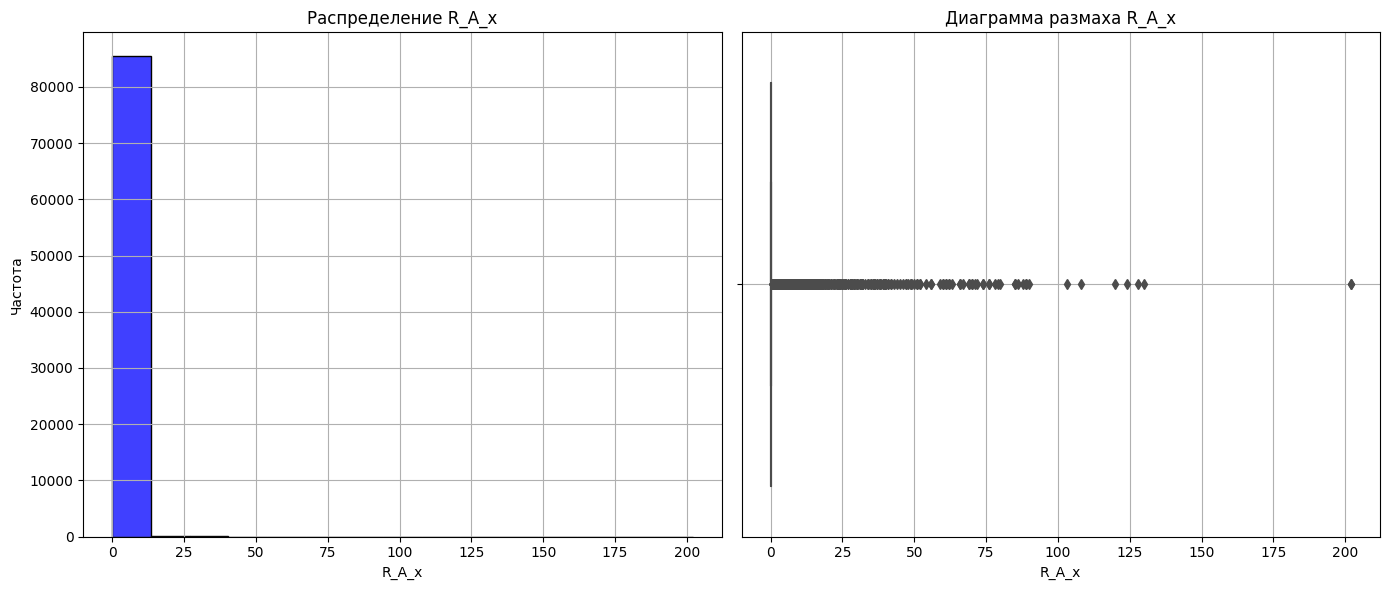

In [77]:
plot_histogram_and_boxplot(df_recipient, 'R_A_x')

In [78]:
df[df['R_A_x'] > 0].shape[0]

1334

#### R_A_y

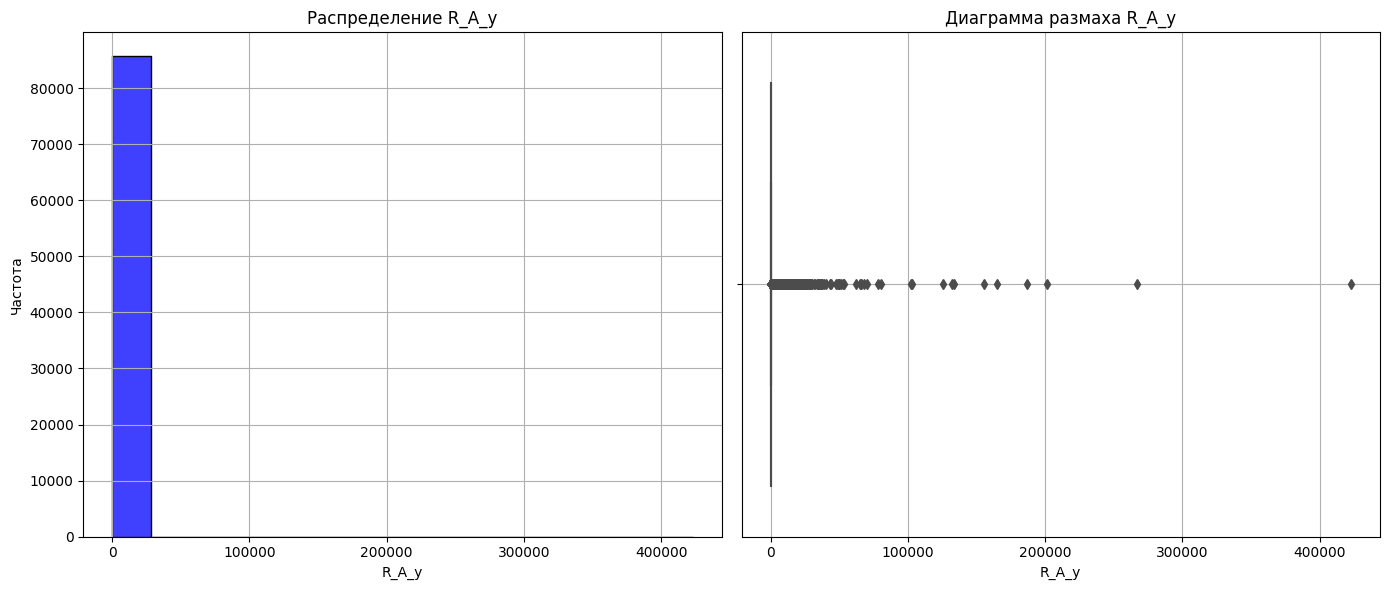

In [79]:
plot_histogram_and_boxplot(df_recipient, 'R_A_y')

In [80]:
df[df['R_A_y'] > 200000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
19147,20049,98747025,20576183,2019-03-12 11:30:25,0,MOBILEAPI,2019-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,400.00,0.0,0.0,0.0,8500.0,7.0,18.0,2.0,0.0,0.0,0.0,0.0,26.0,2.0,19.0,3.0,12.0,201130.58,23873.58,1800.0,0.0,0.0,0.0,0.0,15926.32,0.0,24112.58,479.0,51353.0
34716,36283,47472759,13049854,2019-03-13 16:59:46,0,MOBILEAPI,2019-03-13,0.0,6.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,12.0,0.0,19.0,0.00,9030.0,0.0,0.0,0.0,0.0,0.0,4871.02,0.0,76050.0,0.0,108305.0,22.0,36.0,22.0,2.0,0.0,0.0,0.0,171.0,0.0,14.0,0.0,19.0,422839.67,373490.23,73075.0,11000.0,0.0,0.0,0.0,682721.97,0.0,232527.23,0.0,234009.0
47880,50163,96774001,81230176,2019-03-14 17:50:50,0,MOBILEAPI,2019-03-14,28.0,31.0,1.0,0.0,0.0,0.0,0.0,18.0,0.0,34.0,2.0,2.0,5966.92,606080.0,3688.0,0.0,0.0,0.0,0.0,60791.00,0.0,444750.0,5249.0,70000.0,120.0,8.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,11.0,0.0,6.0,267189.48,8350.00,0.0,0.0,0.0,0.0,0.0,93815.25,0.0,13850.00,0.0,28003.0


In [81]:
df[(df['R_A_x'] > 0) & (df['resolution'] == 1)].shape[0]

2

In [82]:
df[df['R_A_x'] > 0].shape[0]/df.shape[0]*100

1.5555218694247834

In [83]:
df[(df['R_A_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

0.16722408026755853

Выводы:
Данный признак является инaормативным лишь для 1 процента датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### R_С

#### R_C_x

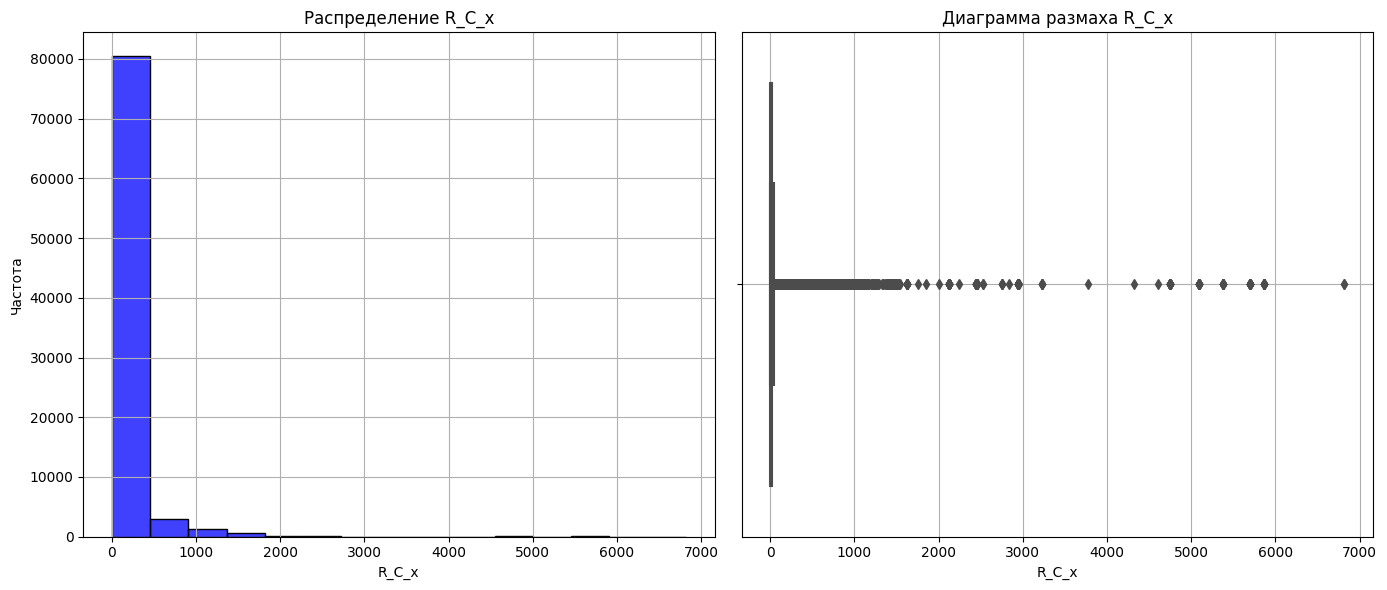

In [84]:
plot_histogram_and_boxplot(df_recipient, 'R_C_x')

In [85]:
df[df['R_C_x'] > 6000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
71705,75146,19208016,48032377,2019-03-16 10:30:35,0,MOBILEAPI,2019-03-16,0.0,5.0,10.0,0.0,0.0,0.0,0.0,48.0,1.0,18.0,0.0,24.0,0.0,12700.0,8485.0,0.0,0.0,0.0,0.0,128005.12,1450.0,151065.0,0.0,284512.0,0.0,6817.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,36.0,0.0,0.0,0.0,1934231.32,0.0,0.0,0.0,0.0,0.0,35227.86,0.0,1651900.0,0.0,0.0
78390,82091,CRM27511531,48032377,2019-03-16 19:51:33,0,MOBILEAPI,2019-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1495.0,0.0,232000.0,0.0,6817.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,36.0,0.0,0.0,0.0,1934231.32,0.0,0.0,0.0,0.0,0.0,35227.86,0.0,1651900.0,0.0,0.0


#### R_C_y

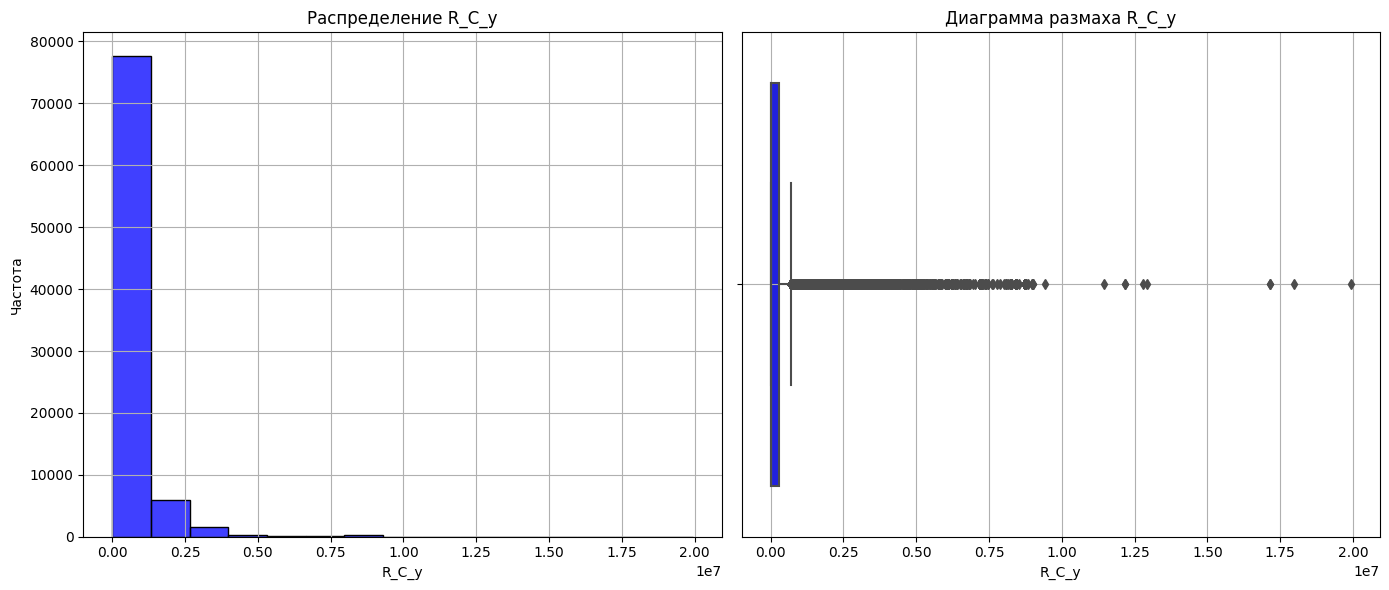

In [86]:
plot_histogram_and_boxplot(df_recipient, 'R_C_y')

In [87]:
df[df['R_C_y'] > 15000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
10361,10759,96496440,40041433,2019-03-11 16:05:01,0,MOBILEAPI,2019-03-11,0.0,5.0,16.0,0.0,0.0,0.0,0.0,42.0,0.0,40.0,0.0,0.0,0.0,390500.00,8664.0,0.0,0.0,0.0,0.0,123174.52,0.0,358584.00,0.0,0.0,0.0,142.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,70.0,0.0,37.0,0.0,19927728.73,109.00,0.0,0.0,0.0,0.0,516696.02,0.0,16091375.00,0.0,7900013.0
58355,61079,MBK5829314,103519358,2019-03-15 11:37:44,0,MOBILEAPI,2019-03-15,0.0,9.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,24.0,0.0,14.0,0.0,865923.08,45.0,0.0,0.0,0.0,0.0,50639.54,0.0,411534.04,0.0,1168602.0,0.0,288.0,7.0,0.0,0.0,0.0,0.0,15.0,0.0,511.0,0.0,14.0,0.0,17966223.62,6333.24,0.0,0.0,0.0,0.0,284903.41,0.0,19492605.59,0.0,1139706.0
58730,61476,95770089,28619329,2019-03-15 11:54:37,0,MOBILEAPI,2019-03-15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,200000.00,0.0,0.0,0.0,0.0,0.0,6370.62,0.0,312250.00,0.0,300002.0,0.0,125.0,6.0,0.0,0.0,0.0,0.0,47.0,0.0,156.0,5.0,0.0,0.0,17163668.00,5792.50,0.0,0.0,0.0,0.0,506124.50,0.0,17750698.00,330.0,0.0
58817,61571,95599735,28619329,2019-03-15 11:59:01,0,MOBILEAPI,2019-03-15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,90000.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,444800.00,0.0,200001.0,0.0,125.0,6.0,0.0,0.0,0.0,0.0,47.0,0.0,156.0,5.0,0.0,0.0,17163668.00,5792.50,0.0,0.0,0.0,0.0,506124.50,0.0,17750698.00,330.0,0.0


In [88]:
df[(df['R_C_x'] > 0)].shape[0]

74161

Признак достатоточно информативен, нужно будет лишь учесть наличие выбросов

### R_F

#### R_F_x

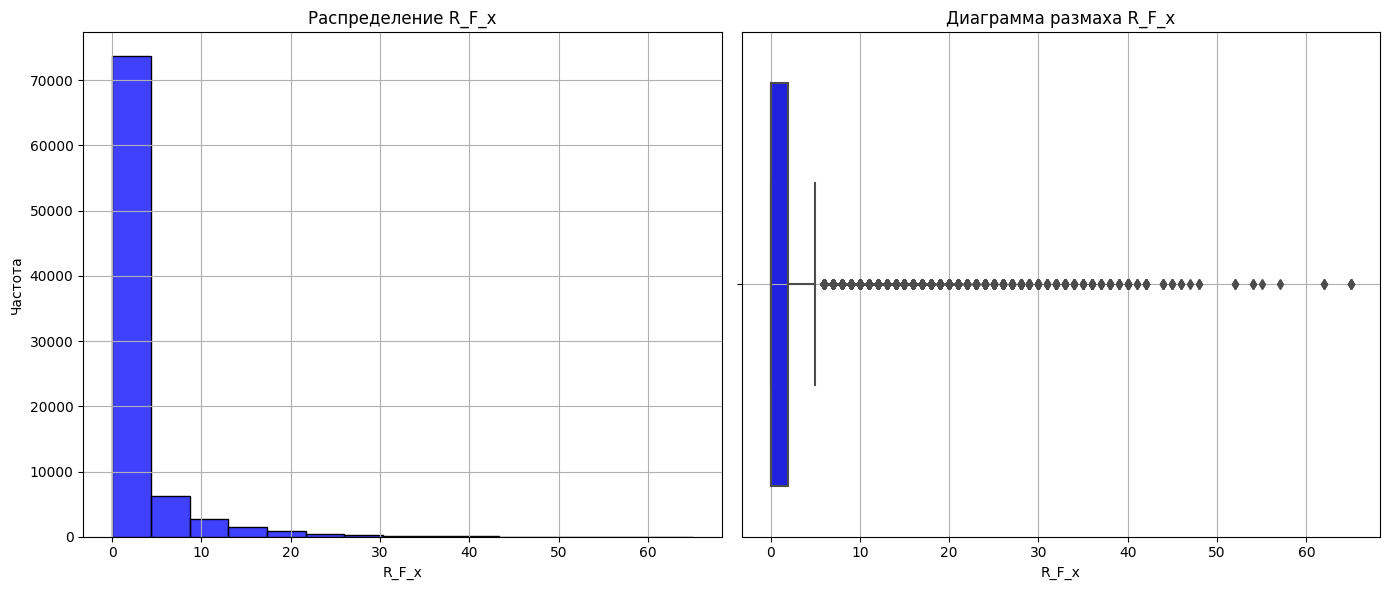

In [89]:
plot_histogram_and_boxplot(df_recipient, 'R_F_x')

In [90]:
df[df['R_F_x'] > 60]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
21601,22642,79019175,27887752,2019-03-12 14:25:14,0,MOBILEAPI,2019-03-12,0.0,6.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,6.0,0.0,5450.0,33.0,0.0,0.0,0.0,0.0,3180.00,0.0,16458.6,0.0,19202.0,0.0,23.0,65.0,3.0,0.0,0.0,0.0,42.0,1.0,42.0,0.0,27.0,0.0,3506872.56,119982.0,18000.0,0.0,0.0,0.0,1276436.11,1500.0,1101672.56,0.0,3006502.0
25232,26444,10196826,27887752,2019-03-13 04:30:48,0,MOBILEAPI,2019-03-13,0.0,7.0,15.0,0.0,0.0,0.0,0.0,27.0,0.0,15.0,2.0,29.0,0.0,58000.0,6466.0,0.0,0.0,0.0,0.0,24296.61,0.0,1358880.0,170552.0,1046504.0,0.0,20.0,65.0,4.0,0.0,0.0,0.0,44.0,0.0,39.0,1.0,27.0,0.0,3154272.56,113254.0,22525.0,0.0,0.0,0.0,1371893.73,0.0,1010172.56,330.0,3205503.0
55708,58314,52263880,86492513,2019-03-15 10:02:57,0,MOBILEAPI,2019-03-15,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,2.0,0.0,27000.0,65.0,0.0,0.0,0.0,0.0,399.00,0.0,55500.0,0.0,5001.0,0.0,60.0,65.0,0.0,0.0,0.0,0.0,108.0,2.0,74.0,0.0,22.0,0.0,4636449.00,143699.0,0.0,0.0,0.0,0.0,152262.97,0.0,4466899.00,0.0,1151600.0
58139,60853,2716600,53536306,2019-03-15 11:28:15,0,MOBILEAPI,2019-03-15,0.0,14.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,13.0,0.0,4.0,0.0,102307.0,380.0,0.0,0.0,0.0,0.0,4368.76,0.0,129087.0,0.0,36001.0,0.0,20.0,62.0,0.0,0.0,0.0,0.0,55.0,0.0,15.0,1.0,6.0,0.0,646152.92,112997.0,0.0,0.0,0.0,0.0,468370.75,0.0,145716.00,100.0,650000.0
81410,85241,MBK7405022,39748177,2019-03-17 10:11:58,0,MOBILEAPI,2019-03-17,0.0,4.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,9.0,0.0,1.0,0.0,5650.0,659.0,0.0,0.0,0.0,0.0,5399.90,0.0,153900.0,0.0,1000.0,0.0,18.0,62.0,1.0,0.0,0.0,0.0,67.0,0.0,24.0,0.0,13.0,0.0,22374.00,49734.0,3080.0,0.0,0.0,0.0,38069.55,0.0,42349.00,0.0,116102.0


In [91]:
df[df['R_F_x'] > 1].shape[0]

24337

#### R_F_y

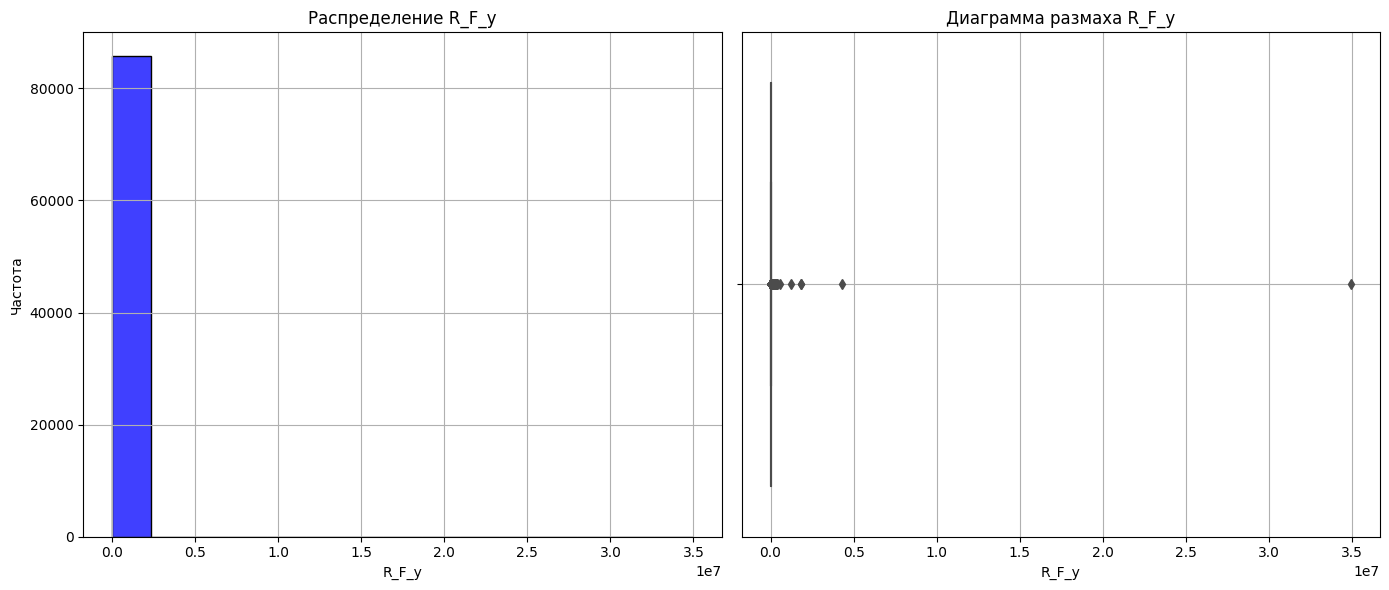

In [92]:
plot_histogram_and_boxplot(df_recipient, 'R_F_y')

In [93]:
df[df['R_F_y'] > 500000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
6657,6915,37722642,2773150,2019-03-11 12:03:01,0,MOBILEAPI,2019-03-11,0.0,8.0,21.0,0.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0,26.0,0.0,521885.00,1604113.00,0.0,0.0,0.0,0.0,120821.36,0.0,140500.00,0.0,1825012.0,0.0,85.0,6.0,0.0,0.0,0.0,0.0,16.0,0.0,39.0,2.0,0.0,0.0,4304573.78,1860000.0,0.00,0.0,0.0,0.0,326700.00,0.0,4436078.00,23107.00,0.0
26463,27720,73782639,6840521,2019-03-13 07:16:04,0,MOBILEAPI,2019-03-13,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,3100.00,0.00,0.0,0.0,0.0,0.0,1800.00,0.0,13200.00,0.0,0.0,0.0,6.0,9.0,5.0,0.0,0.0,0.0,37.0,0.0,3.0,23.0,0.0,0.0,711560.89,549564.4,1525888.12,0.0,0.0,0.0,157920.66,0.0,223000.00,171993.68,0.0
27623,28922,81916544,4666713,2019-03-13 08:45:06,0,MOBILEAPI,2019-03-13,0.0,215.0,5.0,0.0,0.0,0.0,0.0,52.0,1.0,96.0,0.0,1.0,0.0,7891799.79,4892.82,0.0,0.0,0.0,0.0,76516.02,499.0,7184248.60,0.0,500.0,0.0,22.0,17.0,0.0,0.0,0.0,0.0,11.0,0.0,16.0,0.0,66.0,0.0,1927900.00,4297320.0,0.00,0.0,0.0,0.0,6345284.00,0.0,1313000.00,0.00,197199936.0
37063,38739,64478914,61454259,2019-03-14 05:11:10,0,MOBILEAPI,2019-03-14,0.0,79.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,59.0,0.0,3.0,0.0,2049219.00,0.00,0.0,0.0,0.0,0.0,100852.00,0.0,1325888.68,0.0,58001.0,0.0,77.0,8.0,2.0,0.0,0.0,0.0,14.0,0.0,17.0,1.0,0.0,0.0,503986.70,1210280.0,555161.28,0.0,0.0,0.0,90640.19,0.0,798457.22,12162.43,0.0
50049,52418,MBK11899339,93982428,2019-03-15 04:28:17,0,MOBILEAPI,2019-03-15,0.0,9.0,3.0,0.0,0.0,0.0,0.0,31.0,1.0,12.0,0.0,4.0,0.0,41637.00,2980.00,0.0,0.0,0.0,0.0,21814.14,210.0,16394.00,0.0,14000.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,4.0,0.0,0.00,34948198.0,0.00,0.0,0.0,0.0,4937.09,0.0,50300.00,0.00,61000.0
81900,85743,26004959,2773150,2019-03-17 11:03:49,0,MOBILEAPI,2019-03-17,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,50.0,0.0,0.0,0.0,49000.00,0.00,0.0,0.0,0.0,0.0,419.00,0.0,7051450.00,0.0,0.0,0.0,96.0,6.0,0.0,0.0,0.0,0.0,24.0,0.0,59.0,1.0,0.0,0.0,5471270.21,1860000.0,0.00,0.0,0.0,0.0,478929.00,0.0,5815948.00,64952.00,0.0


In [94]:
df[df['R_F_x'] > 0].shape[0]

35025

### R_H

#### R_H_x

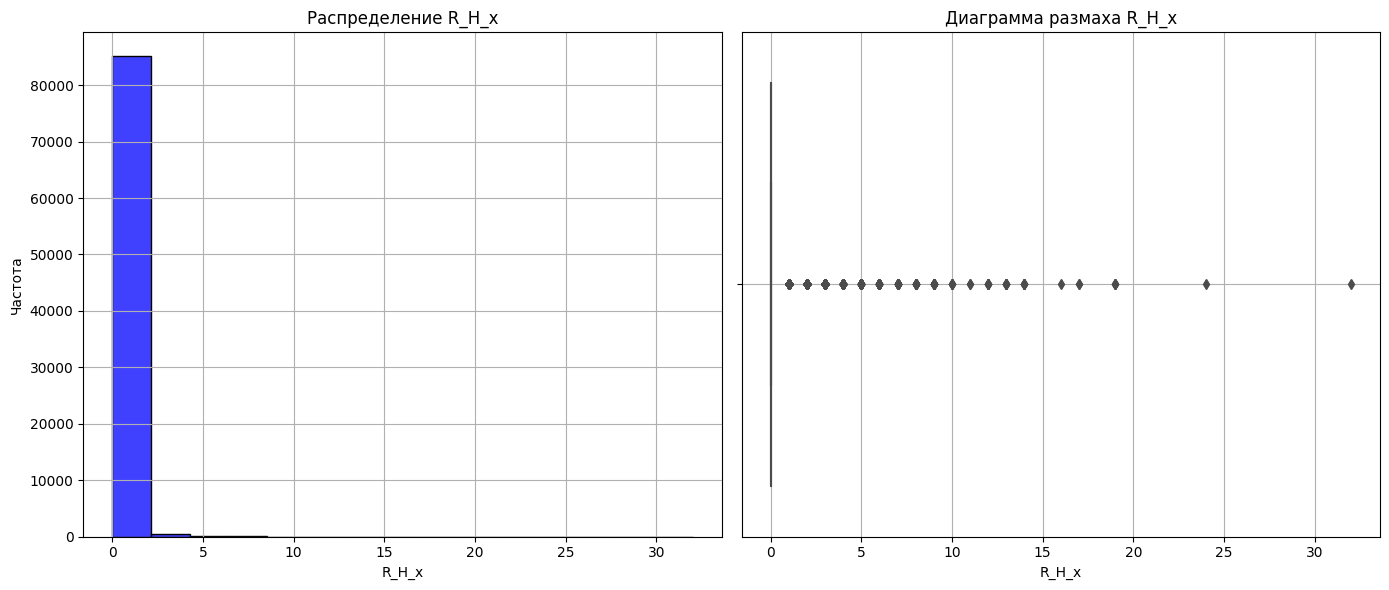

In [95]:
plot_histogram_and_boxplot(df_recipient, 'R_H_x') 

#### R_H_y

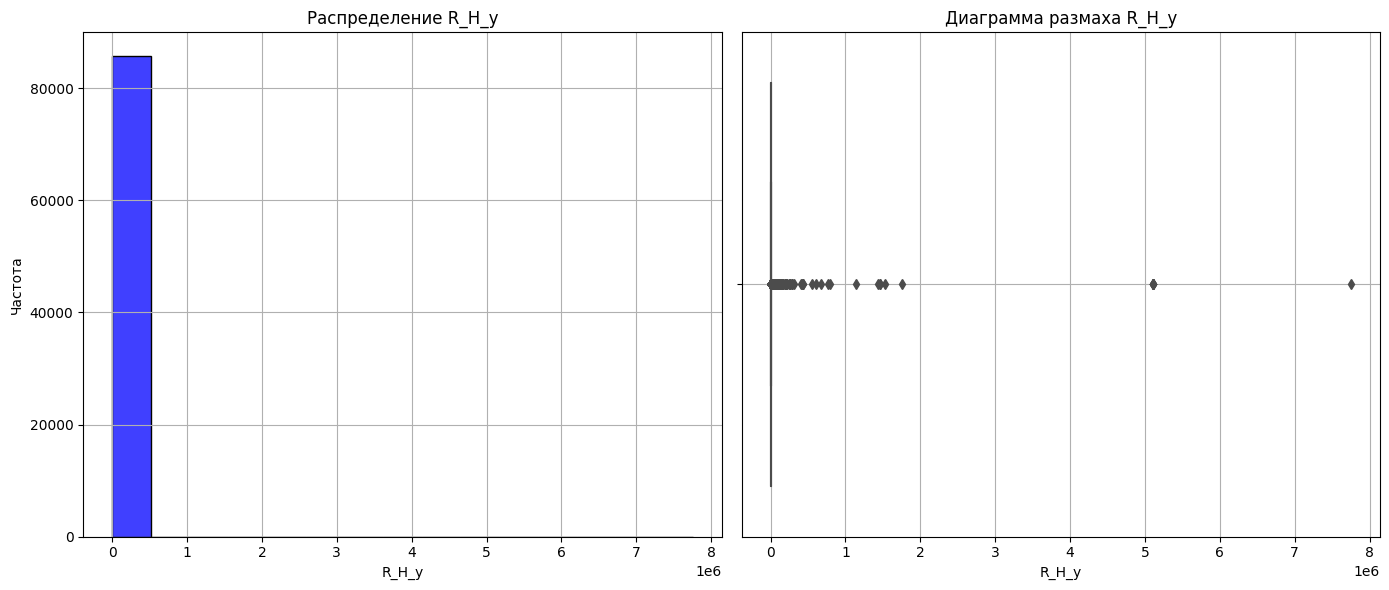

In [96]:
plot_histogram_and_boxplot(df_recipient, 'R_H_y') 

In [97]:
df[(df['R_H_x'] > 0) & (df['resolution'] == 1)].shape[0]

15

In [98]:
df[df['R_H_x'] > 0].shape[0]/df.shape[0]*100  

3.2078265837987847

In [99]:
df[(df['R_H_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

1.254180602006689

Выводы:
Данный признак является инaормативным лишь для 3 процентов датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### R_J

#### R_J_x

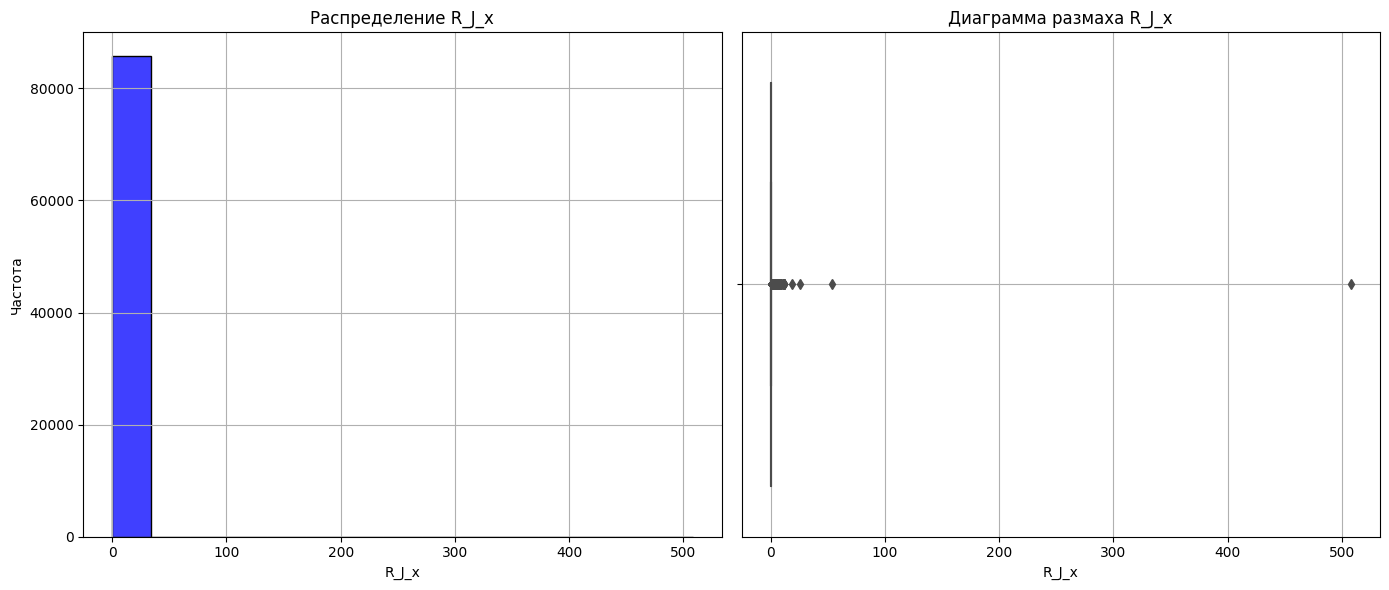

In [100]:
plot_histogram_and_boxplot(df_recipient, 'R_J_x') 

In [101]:
df[df['R_J_x'] > 0].shape[0]

2113

#### R_J_y

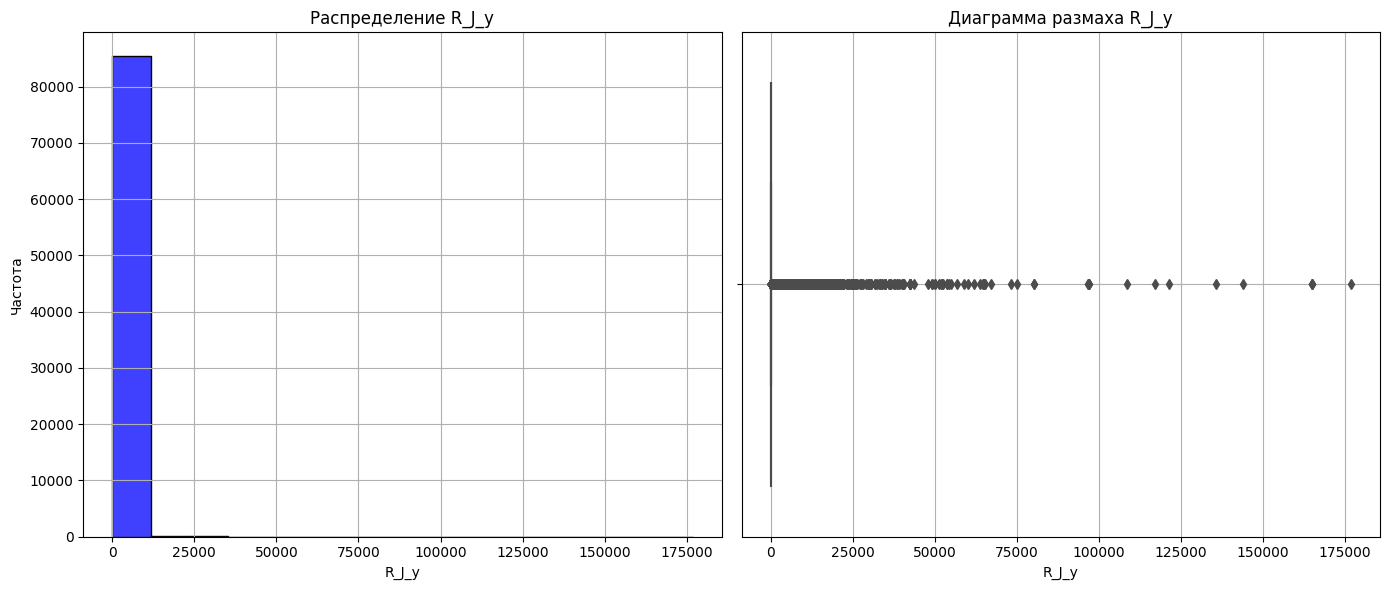

In [102]:
plot_histogram_and_boxplot(df_recipient, 'R_J_y') 

In [103]:
df[(df['R_J_x'] > 0) & (df['resolution'] == 1)].shape[0]

19

In [104]:
df[df['R_J_x'] > 0].shape[0]/df.shape[0]*100 

2.463881341899975

In [105]:
df[(df['R_J_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

1.588628762541806

Выводы:
Данный признак является инaормативным лишь для 2 процентов датасета. Возможно, имеет смысл приобразовать его в бинарный (есть ли переводы данного типа или нет, и не учитывать именно количество и сумму переводов)

### R_O

#### R_O_x

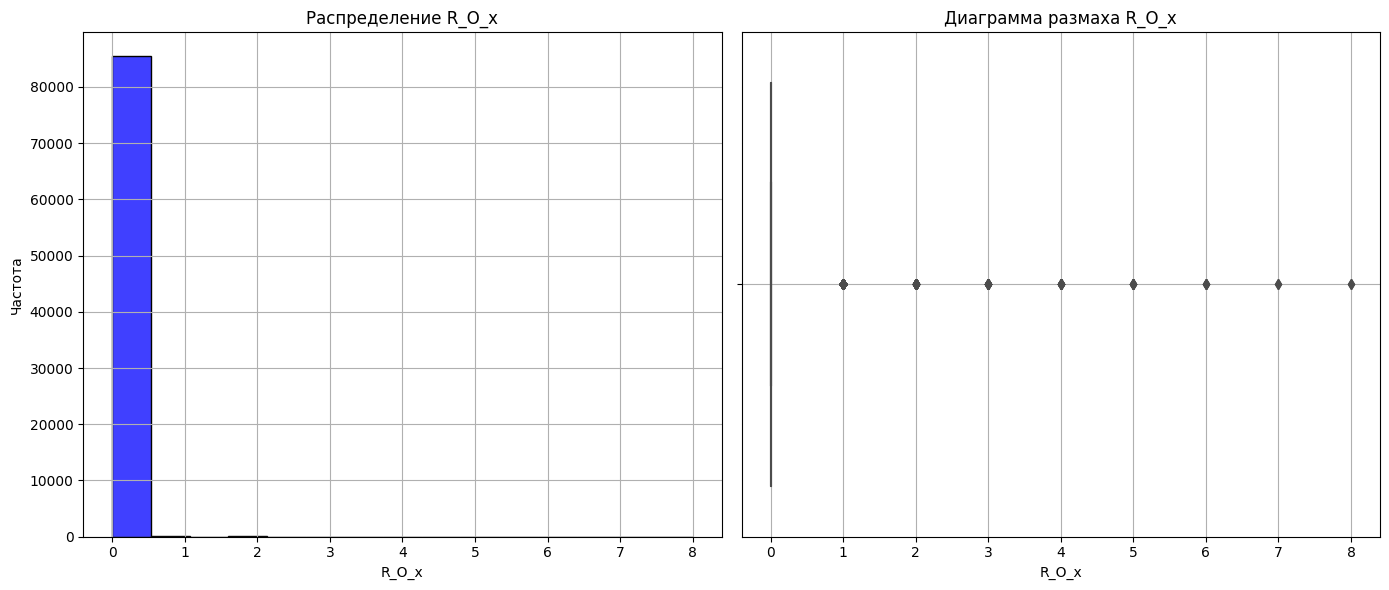

In [106]:
plot_histogram_and_boxplot(df_recipient, 'R_O_x') 

In [107]:
df[df['R_O_x'] > 0].shape[0]

280

#### R_O_y

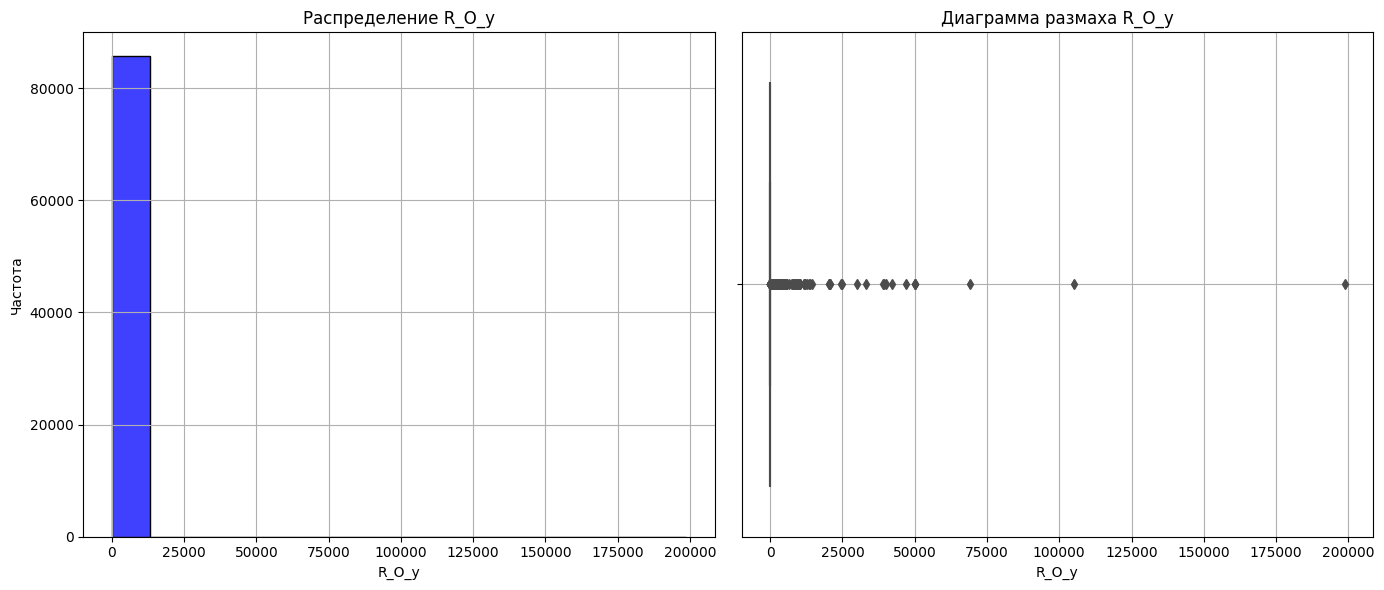

In [108]:
plot_histogram_and_boxplot(df_recipient, 'R_O_y') 

In [109]:
df[(df['R_O_x'] > 0) & (df['resolution'] == 1)].shape[0]

0

In [110]:
df[df['R_O_x'] > 0].shape[0]/df.shape[0]*100 

0.326496344407001

In [111]:
df[(df['R_O_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

0.0

Данный признак не имеет смысла. Его стоит отбросить

### R_Q

#### R_Q_x

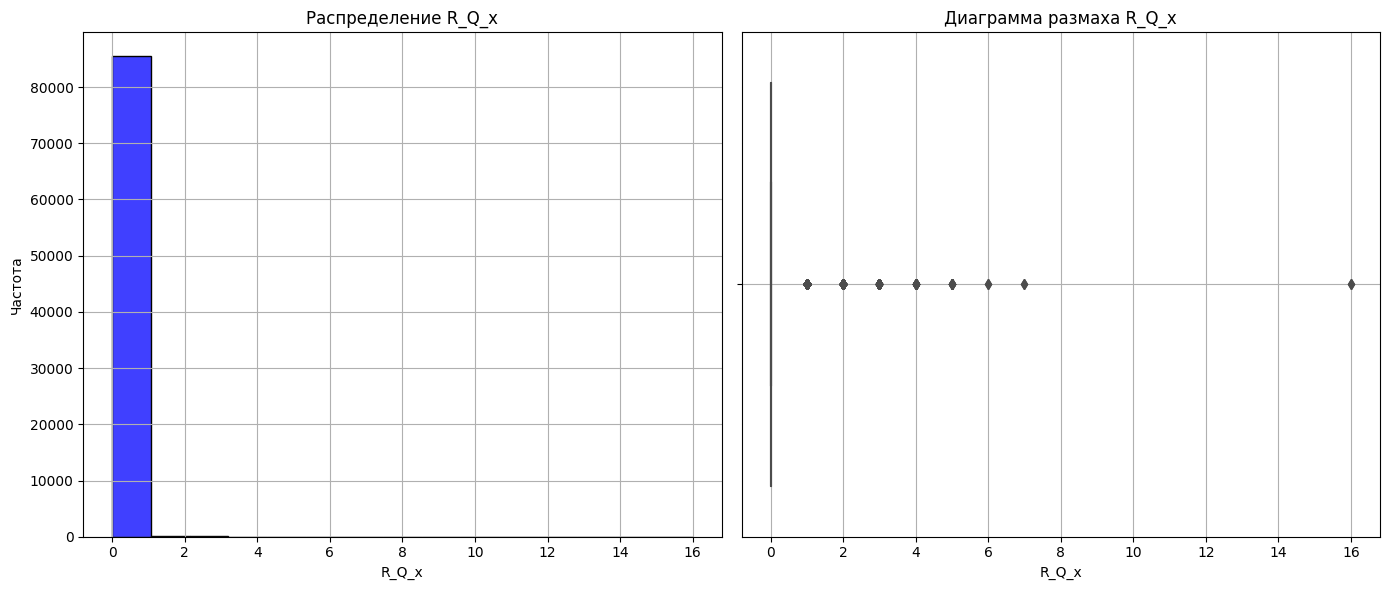

In [112]:
plot_histogram_and_boxplot(df_recipient, 'R_Q_x') 

In [113]:
df[df['R_Q_x'] > 0].shape[0]

958

#### R_Q_y

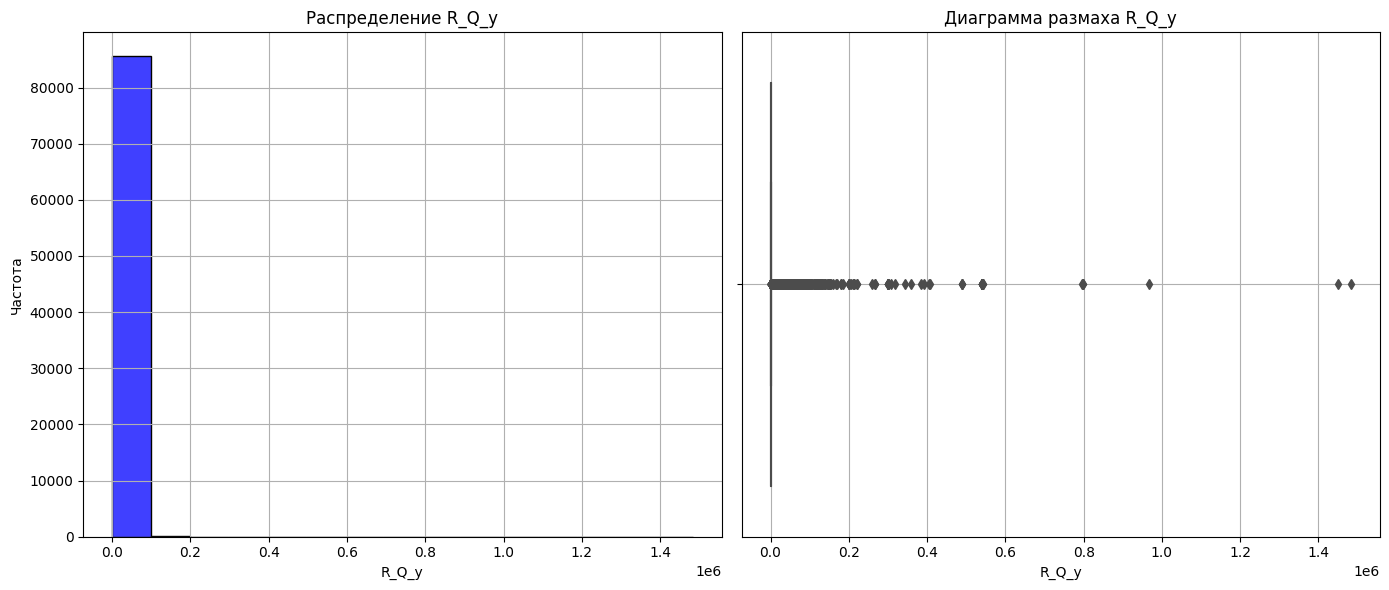

In [114]:
plot_histogram_and_boxplot(df_recipient, 'R_Q_y') 

In [115]:
df[(df['R_Q_x'] > 0) & (df['resolution'] == 1)].shape[0]

39

In [116]:
df[df['R_Q_x'] > 0].shape[0]/df.shape[0]*100 

1.1170839212210963

In [117]:
df[(df['R_Q_x'] > 0) & (df['resolution'] == 1)].shape[0]/df[df['resolution'] == 1].shape[0]*100

3.260869565217391

Данный признак имеет смысл бинаризировать

### R_R

#### R_R_x

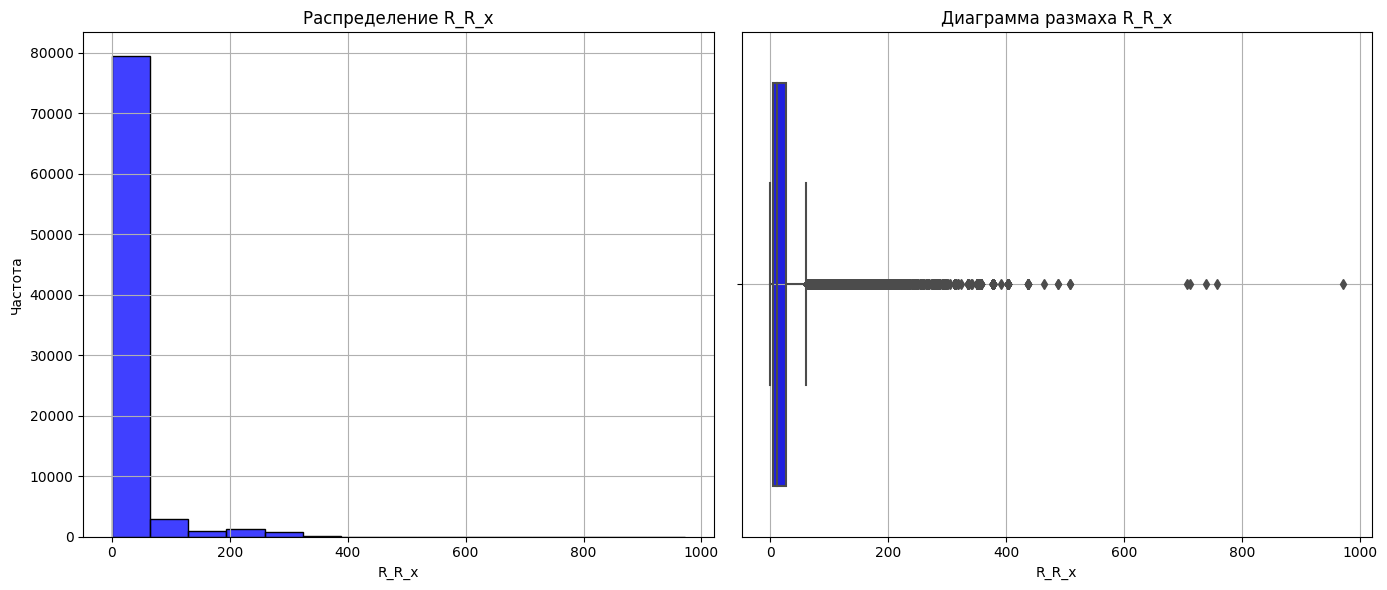

In [118]:
plot_histogram_and_boxplot(df_recipient, 'R_R_x') 

In [119]:
df[df['R_R_x'] > 600]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
2926,3025,2501530,74897061,2019-03-11 08:13:34,0,MOBILEAPI,2019-03-11,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2248.0,0.0,0.0,0.0,0.0,0.0,1518.08,0.0,10000.00,0.0,14001.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,972.0,0.0,0.0,0.0,41.0,0.0,47590.00,0.00,0.0,0.0,0.0,0.0,1762768.00,0.0,0.00,0.0,1775000.0
10687,11093,58351286,60221583,2019-03-11 16:29:10,0,MOBILEAPI,2019-03-11,0.0,3.0,1.0,0.0,0.0,0.0,0.0,21.0,0.0,9.0,0.0,4.0,0.0,34780.0,100.0,0.0,0.0,0.0,0.0,11558.50,0.0,153950.00,0.0,17502.0,0.0,362.0,5.0,1.0,1.0,0.0,0.0,707.0,0.0,28.0,2.0,53.0,0.0,2323451.11,1919.93,1650.0,600.0,0.0,0.0,1061241.03,0.0,1147132.11,8888.0,4277600.0
68292,71558,107321538,5875941,2019-03-16 06:18:07,0,MOBILEAPI,2019-03-16,0.0,634.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,68.0,0.0,1.0,0.0,1722100.4,0.0,0.0,0.0,0.0,0.0,10496.00,0.0,1348430.79,0.0,17000.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,757.0,0.0,2.0,0.0,5.0,0.0,48000.00,0.00,0.0,0.0,0.0,0.0,419846.79,0.0,33900.00,0.0,116603.0
77402,81068,104490566,78527657,2019-03-16 17:29:18,0,MOBILEAPI,2019-03-16,0.0,41.0,0.0,3.0,0.0,0.0,0.0,64.0,0.0,4.0,0.0,8.0,0.0,60292.0,0.0,286.0,0.0,0.0,0.0,78717.80,0.0,60069.27,0.0,9500.0,0.0,335.0,3.0,0.0,0.0,0.0,0.0,739.0,0.0,48.0,0.0,3.0,0.0,701397.00,1282.00,0.0,0.0,0.0,0.0,1104951.06,0.0,1544148.00,0.0,5500.0
82559,86421,96626114,60221583,2019-03-17 12:21:06,0,MOBILEAPI,2019-03-17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,10.0,0.0,2.0,0.0,220.0,0.0,0.0,0.0,0.0,0.0,11603.24,0.0,3999.00,0.0,100001.0,0.0,378.0,6.0,1.0,1.0,0.0,0.0,712.0,0.0,34.0,0.0,37.0,0.0,1656840.00,3009.93,1650.0,600.0,0.0,0.0,974264.23,0.0,1211970.00,0.0,2618000.0


#### R_R_y

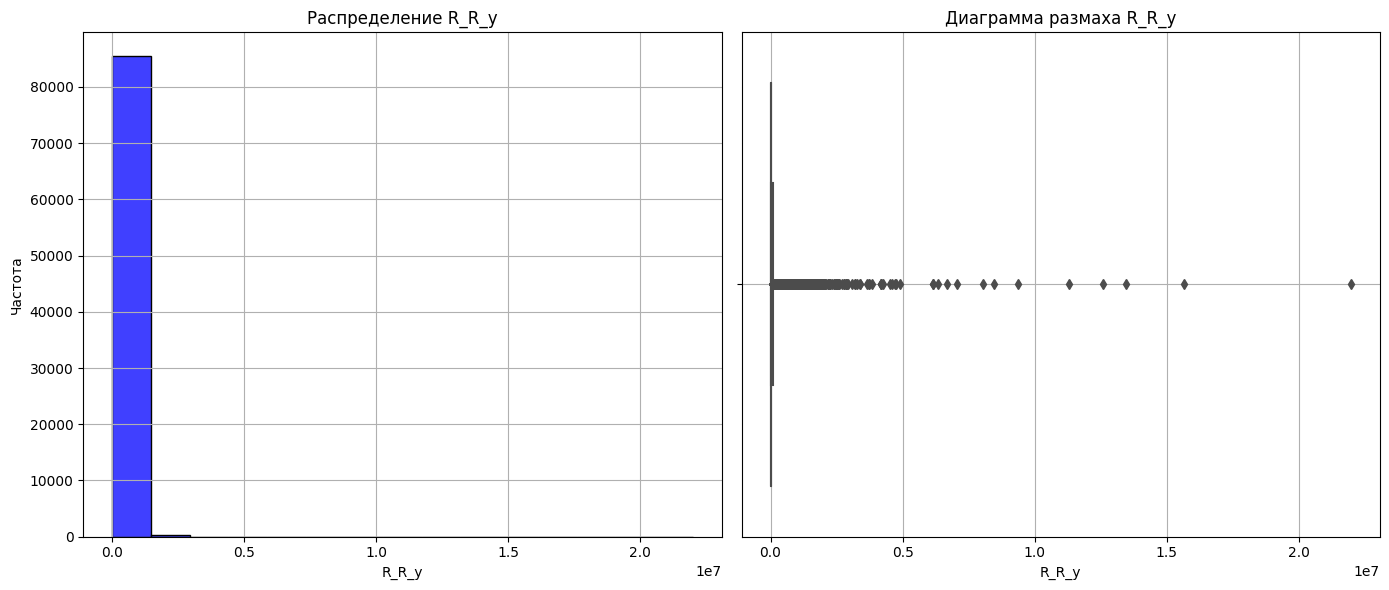

In [120]:
plot_histogram_and_boxplot(df_recipient, 'R_R_y') 

In [121]:
df[df['R_R_y'] > 10000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
2699,2796,108487759,107641492,2019-03-11 07:57:19,0,MOBILEAPI,2019-03-11,0.0,8.0,4.0,0.0,0.0,0.0,3.0,36.0,2.0,6.0,0.0,0.0,0.0,16695.0,2228.0,0.0,0.0,0.0,70500.0,9385.00,5.36,2340.0,0.0,0.0,0.0,66.0,2.0,0.0,0.0,0.0,0.0,318.0,2.0,137.0,0.0,3.0,0.0,612150.00,1894.00,0.0,0.0,0.0,0.0,15672501.93,398.0,2665634.00,0.00,43002.0
18190,19035,1041862,26485329,2019-03-12 10:24:33,0,WEBAPI,2019-03-12,0.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,7.0,0.0,4.0,0.0,7811.0,0.0,0.0,0.0,0.0,0.0,5088.24,0.00,6427.0,0.0,15002.0,0.0,18.0,15.0,1.0,0.0,0.0,0.0,78.0,0.0,17.0,5.0,16.0,0.0,99665.00,10821.60,80.0,0.0,0.0,0.0,11314907.89,0.0,114156.00,27095.43,145004.0
32176,33636,MBK13005271,39528383,2019-03-13 13:37:48,0,MOBILEAPI,2019-03-13,0.0,104.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,0.0,3.0,0.0,133531.0,0.0,0.0,0.0,0.0,0.0,5279.30,0.00,36192.0,0.0,33101.0,0.0,73.0,6.0,0.0,0.0,0.0,0.0,25.0,0.0,86.0,0.0,13.0,0.0,1719535.91,404051.00,0.0,0.0,0.0,0.0,21979443.04,0.0,549221.74,0.00,1222000.0
36968,38636,76998485,22830031,2019-03-14 04:48:07,0,MOBILEAPI,2019-03-14,0.0,4.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,3.0,0.0,5500.0,555.0,0.0,0.0,0.0,0.0,304609.37,0.00,10.0,0.0,1400.0,0.0,25.0,27.0,0.0,0.0,0.0,0.0,126.0,0.0,35.0,3.0,18.0,0.0,2212849.87,13976.85,0.0,0.0,0.0,0.0,13477813.16,0.0,2386740.00,6200.00,2985002.0
68774,72067,58871023,107641492,2019-03-16 07:08:54,0,MOBILEAPI,2019-03-16,0.0,13.0,4.0,0.0,0.0,0.0,0.0,30.0,0.0,7.0,0.0,2.0,0.0,10534.0,1280.0,0.0,0.0,0.0,0.0,8090.93,0.00,2000.0,0.0,2100.0,0.0,67.0,1.0,0.0,0.0,0.0,0.0,250.0,3.0,134.0,0.0,1.0,0.0,1010975.00,1374.00,0.0,0.0,0.0,0.0,12576493.60,547.0,2576542.00,0.00,1.0


### R_T

#### R_T_x

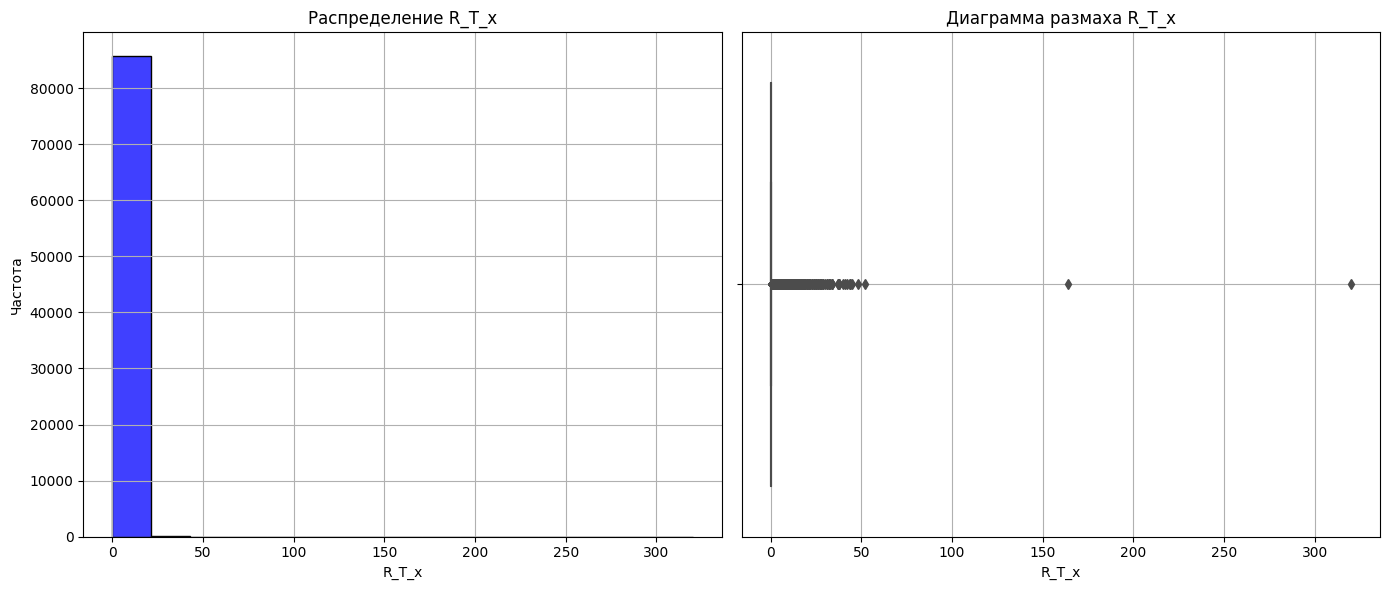

In [122]:
plot_histogram_and_boxplot(df_recipient, 'R_T_x') 

In [123]:
df[df['R_T_x'] > 100]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
10038,10422,3993602,41507689,2019-03-11 15:42:40,0,MOBILEAPI,2019-03-11,0.0,24.0,10.0,0.0,0.0,0.0,0.0,29.0,0.0,15.0,2.0,0.0,0.0,127594.2,5015.0,0.0,0.0,0.0,0.0,23236.89,0.0,78835.0,260.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,30.0,320.0,6.0,1.0,1.0,0.0,42143.0,1000.0,0.0,0.0,0.0,0.0,11878.40,357005.4,18350.0,4712.04,52000.0
12635,13145,13377064,28213942,2019-03-11 20:31:18,0,ATMAPI,2019-03-11,0.0,2.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,2.0,0.0,10000.0,2014.0,0.0,0.0,0.0,0.0,780.39,0.0,0.0,52.0,14100.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,8.0,164.0,15.0,0.0,9.0,0.0,500.0,499.0,0.0,0.0,0.0,0.0,16184.66,191924.0,197828.0,0.00,425004.0


#### R_T_y

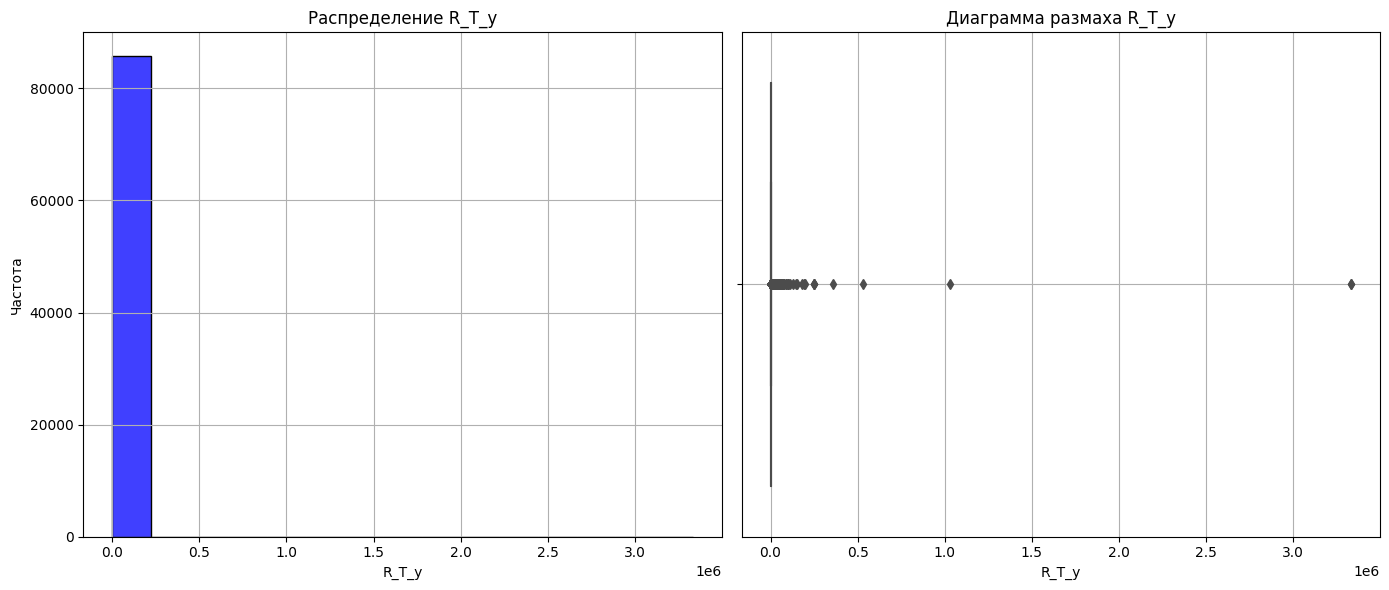

In [124]:
plot_histogram_and_boxplot(df_recipient, 'R_T_y') 

In [125]:
df[df['R_T_y'] > 500000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
18668,19548,57037655,21836183,2019-03-12 10:55:50,0,MOBILEAPI,2019-03-12,0.0,13.0,6.0,0.0,0.0,0.0,0.0,6.0,7.0,9.0,0.0,0.0,0.0,36604.0,1061.6,0.0,0.0,0.0,0.0,5218.51,199.0,41300.0,0.0,0.0,0.0,30.0,18.0,0.0,0.0,0.0,0.0,80.0,28.0,31.0,0.0,2.0,0.0,343481.00,20807.20,0.0,0.0,0.0,0.0,1720114.56,530024.0,468756.60,0.0,54001.0
69886,73238,6900701,100666498,2019-03-16 08:28:26,0,MOBILEAPI,2019-03-16,0.0,13.0,12.0,0.0,0.0,0.0,0.0,34.0,0.0,4.0,1.0,6.0,0.0,120700.0,2451.0,0.0,0.0,0.0,0.0,14901.44,0.0,33100.0,516.0,20903.0,0.0,88.0,11.0,0.0,0.0,0.0,0.0,30.0,41.0,80.0,1.0,20.0,0.0,3883531.55,6239.47,0.0,0.0,0.0,0.0,14932.04,1031029.0,2161859.17,8250.0,1099701.0
78934,82654,38768660,28683286,2019-03-16 22:31:58,0,MOBILEAPI,2019-03-16,0.0,6.0,6.0,0.0,0.0,0.0,0.0,16.0,1.0,4.0,0.0,1.0,0.0,74500.0,10327.0,0.0,0.0,0.0,0.0,18874.44,775.0,26640.0,0.0,500.0,0.0,15.0,5.0,0.0,0.0,0.0,1.0,23.0,44.0,16.0,0.0,6.0,0.0,131609.50,2833.00,0.0,0.0,0.0,105000.0,58070.01,3331573.0,325001.00,0.0,278504.0
79018,82739,58622990,28683286,2019-03-16 23:19:30,0,MOBILEAPI,2019-03-16,0.0,20.0,3.0,0.0,0.0,0.0,0.0,24.0,0.0,14.0,0.0,2.0,0.0,31930.0,995.0,0.0,0.0,0.0,0.0,17439.81,0.0,39407.0,0.0,3701.0,0.0,15.0,5.0,0.0,0.0,0.0,1.0,23.0,44.0,16.0,0.0,6.0,0.0,131609.50,2833.00,0.0,0.0,0.0,105000.0,58070.01,3331573.0,325001.00,0.0,278504.0


### R_U

#### R_U_x

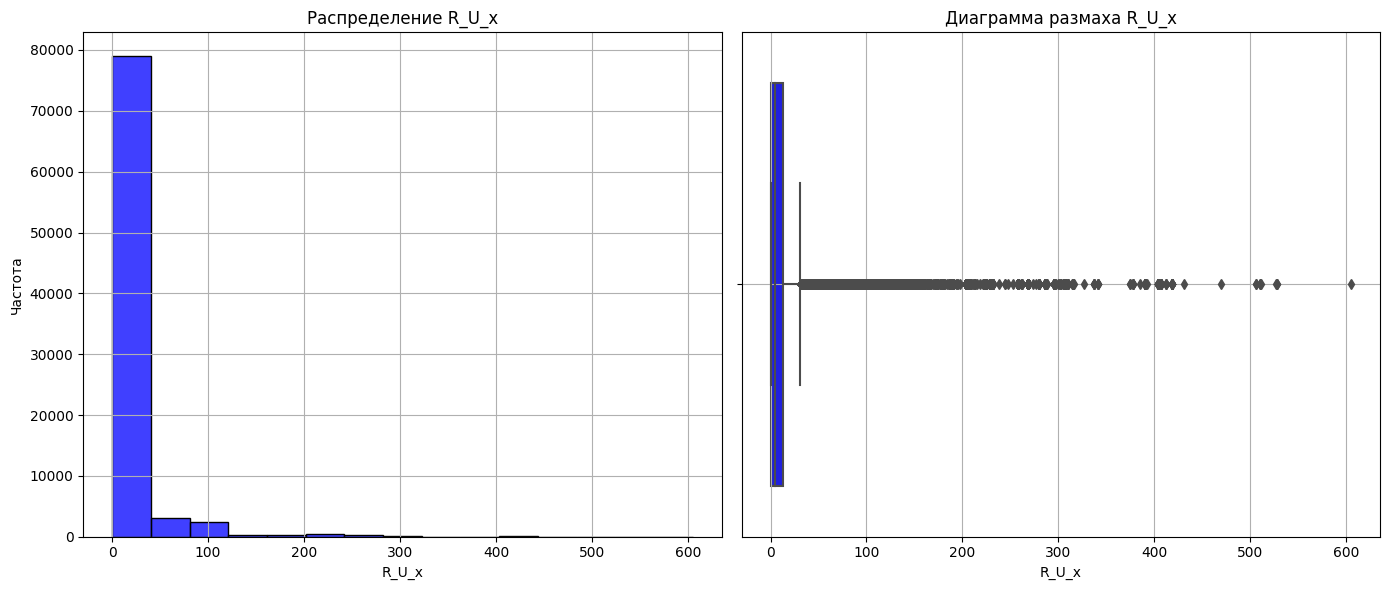

In [126]:
plot_histogram_and_boxplot(df_recipient, 'R_U_x') 

In [127]:
df[df['R_U_x'] > 500]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
5199,5395,48544029,45778918,2019-03-11 10:35:01,0,MOBILEAPI,2019-03-11,0.0,43.0,0.0,0.0,0.0,0.0,1.0,24.0,0.0,25.0,0.0,0.0,0.0,238988.00,0.0,0.0,0.0,0.0,47800.0,290692.00,0.0,260492.00,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,528.0,0.0,6.0,0.0,970000.00,0.00,0.0,0.0,0.0,0.0,120720.00,0.0,624108.50,0.0,577000.0
6325,6568,101351331,45778918,2019-03-11 11:43:28,0,WEBAPI,2019-03-11,0.0,144.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,69.0,0.0,6.0,0.0,1102103.00,0.0,0.0,0.0,0.0,0.0,373744.64,0.0,969381.00,0.0,510000.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,528.0,0.0,6.0,0.0,970000.00,0.00,0.0,0.0,0.0,0.0,120720.00,0.0,624108.50,0.0,577000.0
17943,18770,MBK6412870,35453522,2019-03-12 10:07:57,0,ATMAPI,2019-03-12,0.0,8.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,7.0,0.0,8.0,0.0,26983.00,0.0,0.0,0.0,0.0,0.0,3548.82,0.0,2763.00,0.0,5001.0,0.0,321.0,18.0,0.0,0.0,0.0,0.0,50.0,0.0,510.0,0.0,3.0,0.0,4567171.75,563.00,0.0,0.0,0.0,0.0,34449.96,0.0,5141206.85,0.0,5401.0
18981,19875,91598629,35453522,2019-03-12 11:17:30,0,MOBILEAPI,2019-03-12,0.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,2.0,0.0,800.00,0.0,0.0,0.0,0.0,0.0,753.79,0.0,2000.00,0.0,2351.0,0.0,321.0,18.0,0.0,0.0,0.0,0.0,50.0,0.0,510.0,0.0,3.0,0.0,4567171.75,563.00,0.0,0.0,0.0,0.0,34449.96,0.0,5141206.85,0.0,5401.0
26846,28113,12331183,83104452,2019-03-13 07:48:50,0,MOBILEAPI,2019-03-13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,4.0,0.0,9.0,0.0,5000.00,0.0,0.0,0.0,0.0,0.0,20218.67,0.0,40840.00,0.0,60301.0,0.0,215.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,527.0,0.0,0.0,0.0,784491.13,0.00,0.0,0.0,0.0,0.0,778.00,0.0,708413.91,0.0,0.0
58355,61079,MBK5829314,103519358,2019-03-15 11:37:44,0,MOBILEAPI,2019-03-15,0.0,9.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,24.0,0.0,14.0,0.0,865923.08,45.0,0.0,0.0,0.0,0.0,50639.54,0.0,411534.04,0.0,1168602.0,0.0,288.0,7.0,0.0,0.0,0.0,0.0,15.0,0.0,511.0,0.0,14.0,0.0,17966223.62,6333.24,0.0,0.0,0.0,0.0,284903.41,0.0,19492605.59,0.0,1139706.0
65266,68360,65344379,12263870,2019-03-15 17:39:29,0,MOBILEAPI,2019-03-15,0.0,9.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,4.0,0.0,6.0,0.0,7191.00,0.0,0.0,0.0,0.0,0.0,1100.00,0.0,2400.00,0.0,1605.0,0.0,54.0,12.0,0.0,0.0,0.0,0.0,47.0,0.0,506.0,0.0,27.0,0.0,2872278.00,2549.99,0.0,0.0,0.0,0.0,73398.70,0.0,3910637.00,0.0,1001513.0
65298,68393,65344379,12263870,2019-03-15 17:42:04,0,MOBILEAPI,2019-03-15,0.0,9.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,4.0,0.0,6.0,0.0,7191.00,0.0,0.0,0.0,0.0,0.0,1100.00,0.0,2400.00,0.0,1605.0,0.0,54.0,12.0,0.0,0.0,0.0,0.0,47.0,0.0,506.0,0.0,27.0,0.0,2872278.00,2549.99,0.0,0.0,0.0,0.0,73398.70,0.0,3910637.00,0.0,1001513.0
80148,83920,107769793,59489579,2019-03-17 07:33:38,0,MOBILEAPI,2019-03-17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,1500.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,1000.0,103002.0,0.0,13.0,2.0,0.0,0.0,0.0,0.0,66.0,0.0,605.0,0.0,31.0,0.0,284993.00,6400.00,0.0,0.0,0.0,0.0,307710.75,0.0,1450262.00,0.0,751511.0


#### R_U_y

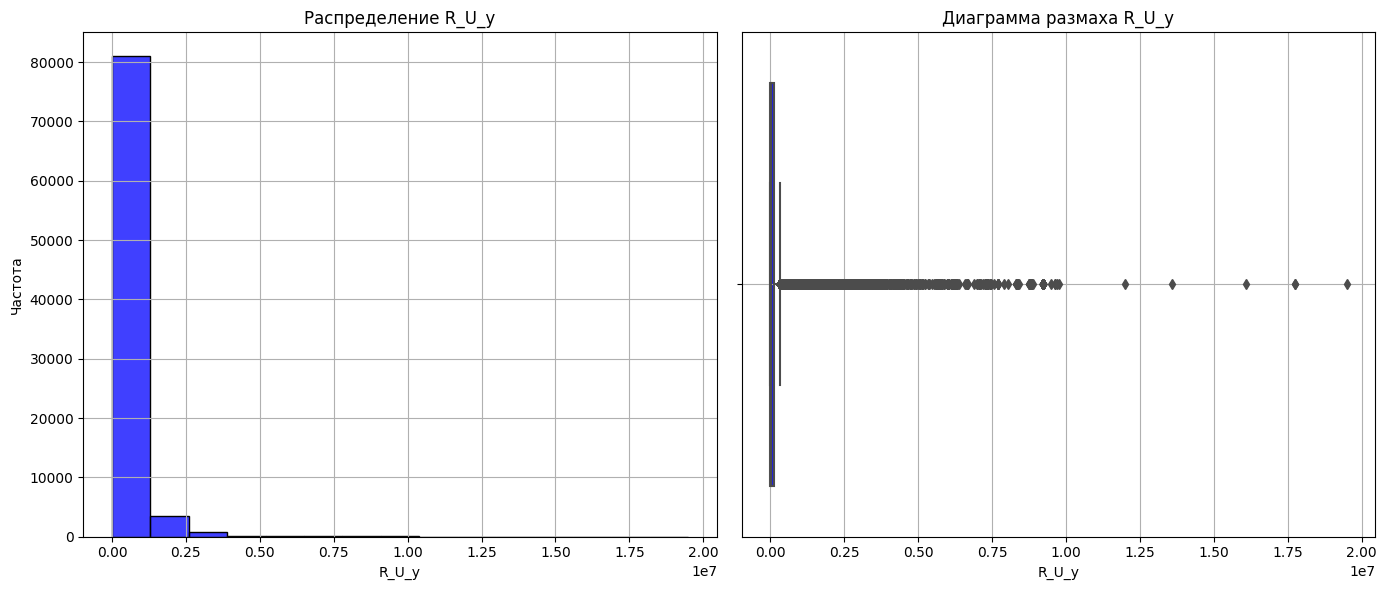

In [128]:
plot_histogram_and_boxplot(df_recipient, 'R_U_y') 

In [129]:
df[df['R_U_y'] > 10000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
10361,10759,96496440,40041433,2019-03-11 16:05:01,0,MOBILEAPI,2019-03-11,0.0,5.0,16.0,0.0,0.0,0.0,0.0,42.0,0.0,40.0,0.0,0.0,0.0,390500.00,8664.0,0.0,0.0,0.0,0.0,123174.52,0.0,358584.00,0.0,0.0,0.0,142.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,70.0,0.0,37.0,0.0,19927728.73,109.00,0.0,0.0,0.0,0.0,516696.02,0.0,16091375.00,0.0,7900013.0
15798,16496,20990197,81139369,2019-03-12 07:58:08,0,MOBILEAPI,2019-03-12,0.0,3.0,1.0,0.0,0.0,0.0,0.0,40.0,0.0,11.0,1.0,14.0,0.0,9500.00,10.0,0.0,0.0,0.0,0.0,47106.46,0.0,137901.00,3828.0,242007.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,2.0,0.0,0.0,0.0,2353825.00,0.00,0.0,0.0,0.0,0.0,1022842.31,0.0,12000000.00,0.0,0.0
18656,19536,44656935,59349220,2019-03-12 10:54:46,0,MOBILEAPI,2019-03-12,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,6.0,0.0,260550.00,0.0,0.0,0.0,0.0,0.0,9700.00,0.0,48500.00,0.0,105003.0,0.0,39.0,1.0,0.0,0.0,0.0,0.0,35.0,0.0,42.0,1.0,163.0,0.0,11463502.00,116.00,0.0,0.0,0.0,0.0,44291.31,0.0,13576002.00,10831.3,16262552.0
58355,61079,MBK5829314,103519358,2019-03-15 11:37:44,0,MOBILEAPI,2019-03-15,0.0,9.0,1.0,0.0,0.0,0.0,0.0,29.0,0.0,24.0,0.0,14.0,0.0,865923.08,45.0,0.0,0.0,0.0,0.0,50639.54,0.0,411534.04,0.0,1168602.0,0.0,288.0,7.0,0.0,0.0,0.0,0.0,15.0,0.0,511.0,0.0,14.0,0.0,17966223.62,6333.24,0.0,0.0,0.0,0.0,284903.41,0.0,19492605.59,0.0,1139706.0
58730,61476,95770089,28619329,2019-03-15 11:54:37,0,MOBILEAPI,2019-03-15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,4.0,0.0,200000.00,0.0,0.0,0.0,0.0,0.0,6370.62,0.0,312250.00,0.0,300002.0,0.0,125.0,6.0,0.0,0.0,0.0,0.0,47.0,0.0,156.0,5.0,0.0,0.0,17163668.00,5792.50,0.0,0.0,0.0,0.0,506124.50,0.0,17750698.00,330.0,0.0
58817,61571,95599735,28619329,2019-03-15 11:59:01,0,MOBILEAPI,2019-03-15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,90000.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,444800.00,0.0,200001.0,0.0,125.0,6.0,0.0,0.0,0.0,0.0,47.0,0.0,156.0,5.0,0.0,0.0,17163668.00,5792.50,0.0,0.0,0.0,0.0,506124.50,0.0,17750698.00,330.0,0.0


### R_X

#### R_X_x

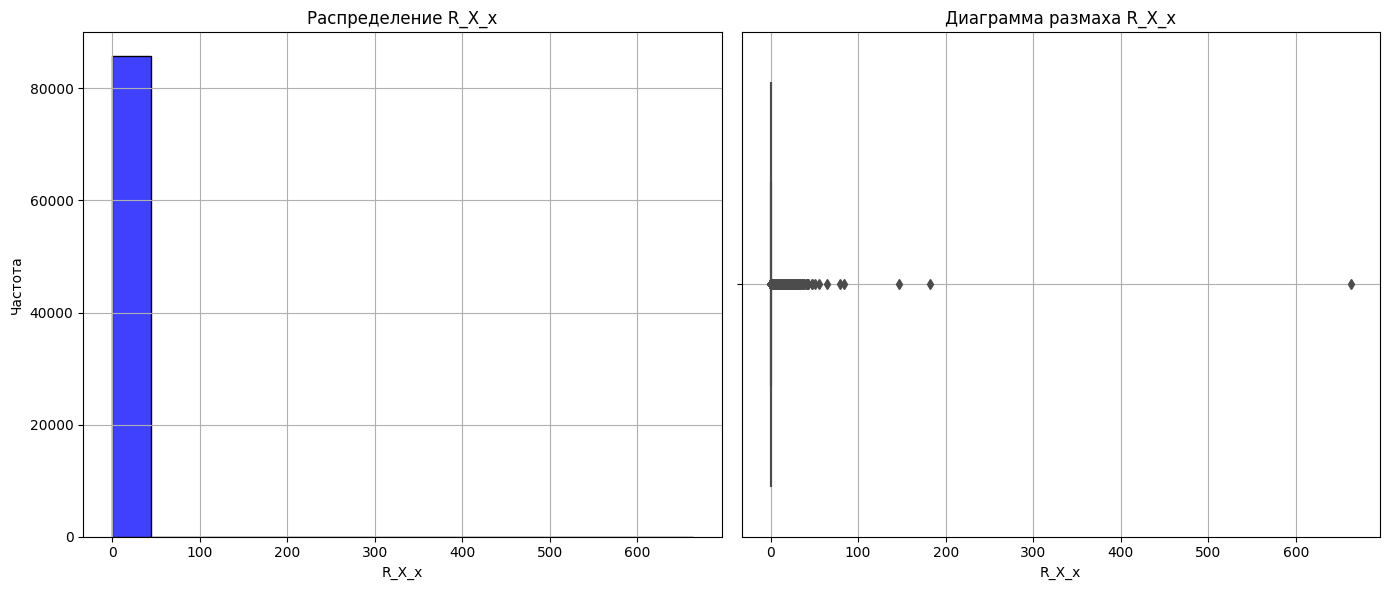

In [130]:
plot_histogram_and_boxplot(df_recipient, 'R_X_x') 

In [131]:
df[df['R_X_x'] > 100]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
23648,24789,12791555,108443930,2019-03-12 17:39:23,0,MOBILEAPI,2019-03-12,0.0,24.0,2.0,0.0,0.0,0.0,0.0,24.0,0.0,11.0,0.0,12.0,0.0,174050.0,674.0,0.0,0.0,0.0,0.0,12566.61,0.0,75360.0,0.0,445500.0,0.0,37.0,3.0,0.0,0.0,0.0,0.0,60.0,0.0,45.0,147.0,32.0,0.0,249424.0,725.0,0.0,0.0,0.0,0.0,5502.37,0.0,2297558.0,3381.0,2098906.0
70885,74282,37803294,32263106,2019-03-16 09:34:54,0,MOBILEAPI,2019-03-16,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,362018.0,0.0,0.0,0.0,0.0,0.0,1137.79,0.0,118270.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,11.0,1.0,8.0,663.0,4.0,0.0,5000.0,300.0,0.0,0.0,0.0,0.0,18640.98,1100.0,153505.0,464100.0,160002.0
73289,76793,38876114,32168542,2019-03-16 12:15:29,0,WEBAPI,2019-03-16,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103250.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,182.0,0.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,11816.00,0.0,25000.0,546000.0,0.0


#### R_X_y

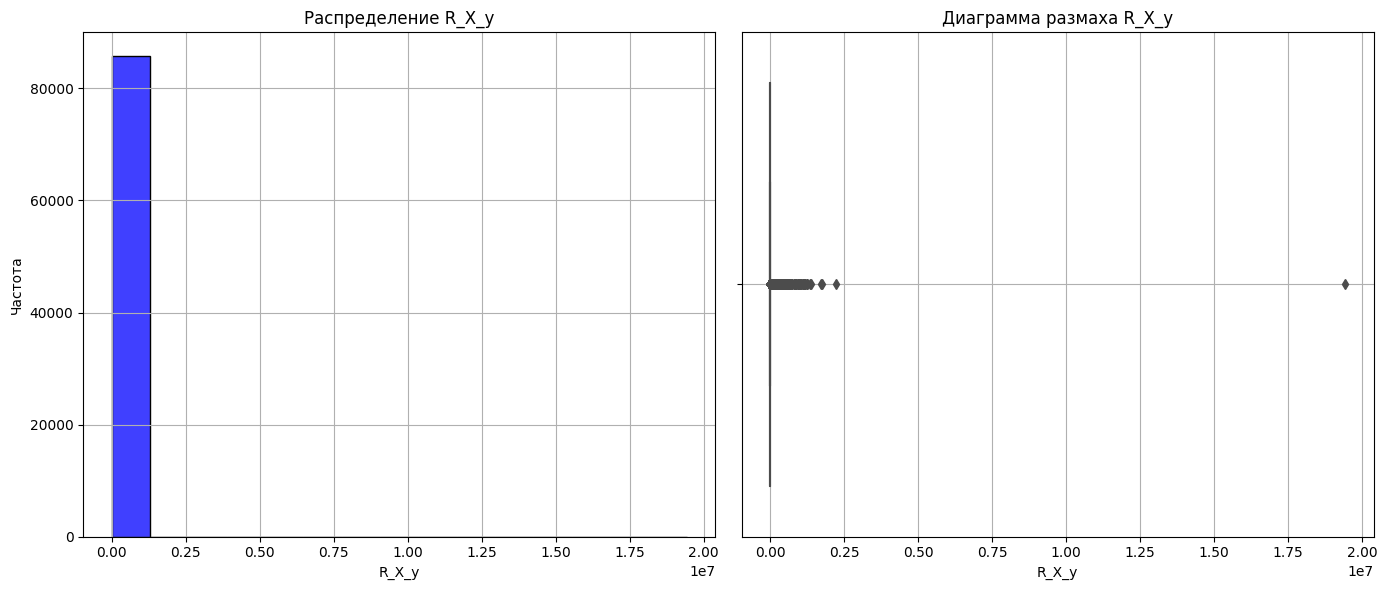

In [132]:
plot_histogram_and_boxplot(df_recipient, 'R_X_y') 

In [133]:
df[df['R_X_y'] > 1500000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
16554,17299,67167786,42064410,2019-03-12 08:47:46,0,MOBILEAPI,2019-03-12,0.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,2.0,1.0,11.0,0.0,1136.00,0.0,0.0,0.0,0.0,0.0,29454.73,0.0,19250.00,1935.96,100155.0,0.0,1.0,9.0,1.0,0.0,0.0,0.0,39.0,0.0,3.0,3.0,4.0,0.00,5000.00,245705.59,1440000.00,0.0,0.0,0.0,259664.05,0.00,7200.0,2215134.00,3501200.0
16746,17501,12892544,3094546,2019-03-12 09:00:07,0,MOBILEAPI,2019-03-12,0.0,0.0,3.0,0.0,0.0,0.0,0.0,19.0,0.0,3.0,0.0,1.0,0.0,0.00,4314.7,0.0,0.0,0.0,0.0,13707.85,0.0,5500.00,0.00,15000.0,6.0,51.0,24.0,3.0,0.0,0.0,0.0,55.0,11.0,76.0,27.0,9.0,1679.89,2423233.39,11965.00,39494.16,0.0,0.0,0.0,146804.99,42161.95,1082694.0,1746367.43,312502.0
68848,72144,6989411,1727730,2019-03-16 07:14:33,0,MOBILEAPI,2019-03-16,0.0,11.0,5.0,2.0,0.0,0.0,0.0,46.0,0.0,12.0,0.0,2.0,0.0,229105.45,4578.9,4900.0,0.0,0.0,0.0,37573.62,0.0,229723.45,0.00,10000.0,0.0,27.0,9.0,0.0,0.0,0.0,0.0,40.0,0.0,26.0,23.0,14.0,0.00,643300.00,7417.40,0.00,0.0,0.0,0.0,27964.40,0.00,550146.0,19417063.00,429006.0
82750,86623,59447024,87991020,2019-03-17 12:42:02,0,MOBILEAPI,2019-03-17,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,210260.00,355.2,0.0,0.0,0.0,0.0,60.00,0.0,5000.00,0.00,0.0,0.0,54.0,7.0,0.0,0.0,0.0,0.0,43.0,1.0,23.0,42.0,0.0,0.00,3110258.00,2486.00,0.00,0.0,0.0,0.0,934481.14,1085.48,896059.0,1718045.00,0.0


### R_Z

#### R_Z_x

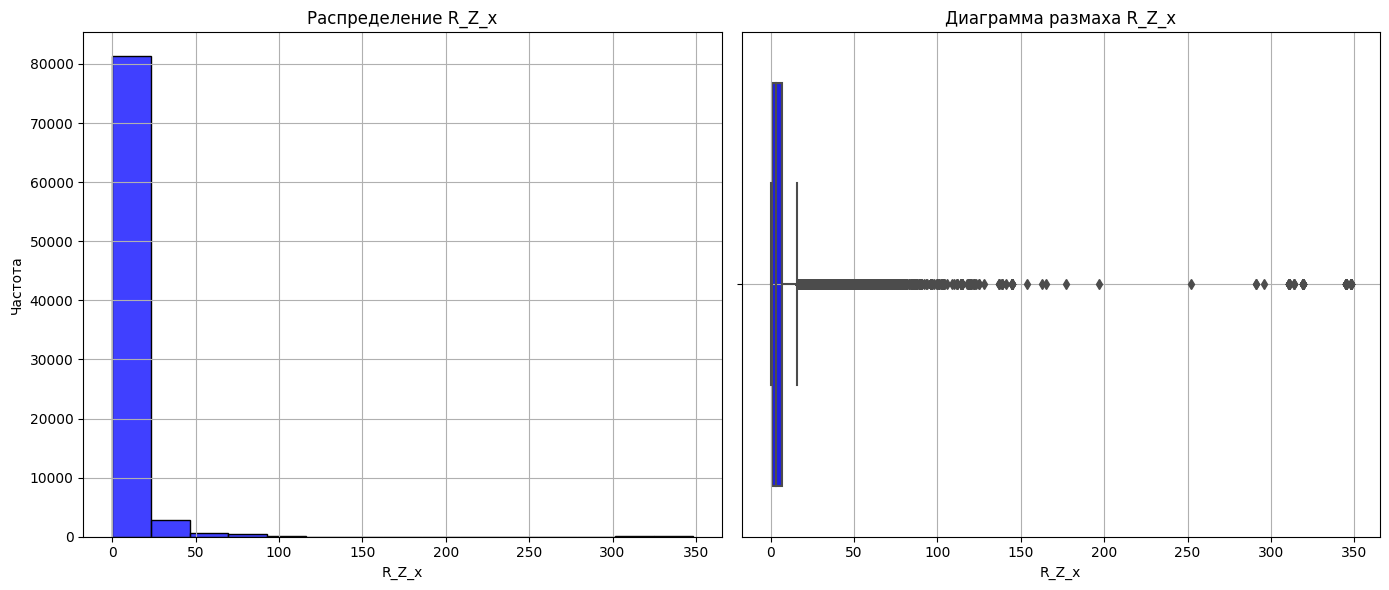

In [134]:
plot_histogram_and_boxplot(df_recipient, 'R_Z_x') 

#### S_Z_y

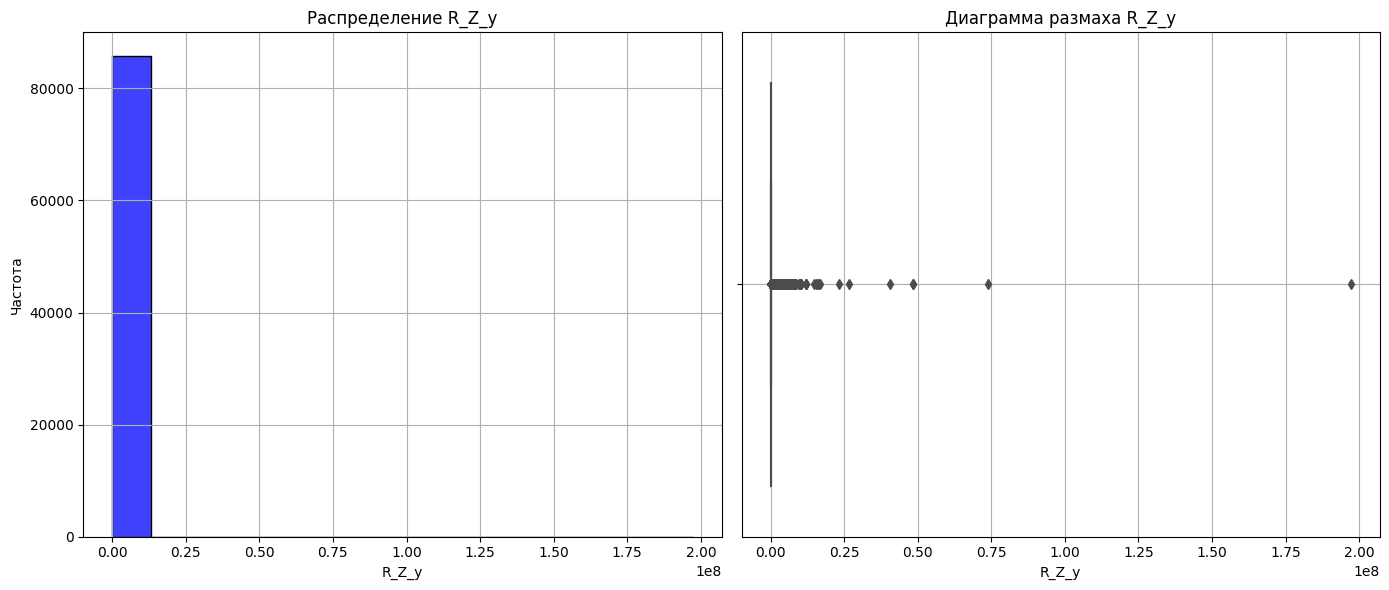

In [135]:
plot_histogram_and_boxplot(df_recipient, 'R_Z_y') 

In [136]:
df[df['R_Z_y'] > 25000000]

,Unnamed: 0,user_id,rec_user_id,date_time,resolution,sub_channel,idate,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_O_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_O_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_O_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_O_y,R_Q_y,R_R_y,R_T_y,R_U_y,R_X_y,R_Z_y
27623,28922,81916544,4666713,2019-03-13 08:45:06,0,MOBILEAPI,2019-03-13,0.0,215.0,5.0,0.0,0.0,0.0,0.0,52.0,1.0,96.0,0.0,1.0,0.0,7891799.79,4892.82,0.0,0.0,0.0,0.0,76516.02,499.0,7184248.6,0.0,500.0,0.0,22.0,17.0,0.0,0.0,0.0,0.0,11.0,0.0,16.0,0.0,66.0,0.0,1927900.00,4297320.0,0.00,0.0,0.0,0.0,6345284.00,0.00,1313000.00,0.00,197199936.0
46763,49005,87854832,76096740,2019-03-14 16:24:48,0,MOBILEAPI,2019-03-14,0.0,39.0,7.0,0.0,0.0,0.0,0.0,83.0,0.0,30.0,0.0,21.0,0.0,633470.00,1454.69,0.0,0.0,0.0,0.0,321639.31,0.0,789488.0,0.0,430202.0,0.0,45.0,30.0,1.0,0.0,0.0,0.0,173.0,0.0,38.0,0.0,141.0,0.0,1300995.87,13750.8,5543.04,0.0,0.0,0.0,967103.06,0.00,1005823.38,0.00,40574803.0
48988,51323,MBK12086296,33970058,2019-03-14 20:20:57,0,MOBILEAPI,2019-03-14,0.0,14.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,6.0,0.0,6.0,0.0,5770.00,0.00,0.0,0.0,0.0,0.0,2847.43,0.0,20868.0,0.0,17153.0,0.0,76.0,15.0,0.0,0.0,0.0,0.0,128.0,4.0,76.0,2.0,71.0,0.0,2351312.92,18301.0,0.00,0.0,0.0,0.0,303068.59,1143.41,1251680.98,55120.00,48238404.0
49328,51674,107641492,33970058,2019-03-14 22:54:47,0,MOBILEAPI,2019-03-14,0.0,69.0,1.0,0.0,0.0,0.0,0.0,276.0,3.0,141.0,0.0,3.0,0.0,817664.00,1374.00,0.0,0.0,0.0,0.0,14184627.00,547.0,2679855.0,0.0,43002.0,0.0,76.0,15.0,0.0,0.0,0.0,0.0,128.0,4.0,76.0,2.0,71.0,0.0,2351312.92,18301.0,0.00,0.0,0.0,0.0,303068.59,1143.41,1251680.98,55120.00,48238404.0
76229,79850,79671965,76096740,2019-03-16 15:48:04,0,MOBILEAPI,2019-03-16,0.0,57.0,1.0,0.0,0.0,0.0,0.0,22.0,0.0,17.0,0.0,0.0,0.0,210992.00,713.00,0.0,0.0,0.0,0.0,7334.52,0.0,151380.0,0.0,0.0,0.0,51.0,40.0,1.0,0.0,0.0,0.0,233.0,0.0,41.0,0.0,252.0,0.0,1660813.07,19549.8,5543.04,0.0,0.0,0.0,1589463.41,0.00,1277247.30,0.00,73874803.0
80620,84423,1602744,14402486,2019-03-17 08:43:31,0,MOBILEAPI,2019-03-17,0.0,16.0,2.0,0.0,0.0,0.0,0.0,41.0,0.0,9.0,0.0,4.0,0.0,129802.00,1764.00,0.0,0.0,0.0,0.0,38901.30,0.0,79400.0,0.0,80002.0,0.0,11.0,6.0,1.0,0.0,0.0,0.0,40.0,0.0,22.0,9.0,17.0,0.0,613060.00,4589.0,1138610.00,0.0,0.0,0.0,224938.22,0.00,1012380.00,497764.38,26575999.0


### Выводы по исследованию признаков получателя

1. Убрать выбросы по Х и У - R_Z, R_X, R_U, R_T,R_R, R_S, R_F, R_C
2. Бинаризировать - R_Q, R_J, R_H, R_A
3. Отбросить - R_O

## Feature engineering

Необходимо обдумать и обоосновать создание новых фичей.

**Общее количество переводов, общая сумма переводов, среднее значение транзакций**. То есть, мы считаем признаки, которые описывают общую статистику карты. Как они нам могут помочь:  
а) Общее количество переводов может указать на некоторые зависимости: Если у пользователя очень много транзакций, или наоборот, очень мало транзакций, то этот пользователь более похож, на мошенника, чем пользователь с средним числом транзакций. Это мы еще раз обработаем в следующей идее  
б) Общая сумма переводов - также сумма переводо пользователя может указывать на то, является он мошенником или нет. Также, дает нам в целом понимании   
в) Среднее значение переводов - укаывает на средий уровент единичной траты пользователя, и информация о сравнении текущего перевода с средним может указывать на мошеннический перевод

**Разбиение пользователей на категории по количеству переводов, общей сумме и среднему значению.** То есть, мы не только будем смотреть на общие метрики по переводам, но и разобъем пользователей на некие категории

**Общие метрики и категории в каждой отдельной категории**  
По аналогии с прошлыми идеями, может подсчитать такие же признаки для каждой категории ТСТ

## Обработка Аномальных Значений

In [137]:
thresholds = {
    'S_C_x': 4000, 'S_C_y': 20000000, 'S_F_x': 80, 'S_F_y': 2000000,
    'S_R_x': 1000, 'S_T_x': 65, 'S_T_y': 400000, 'S_U_x': 1000,
    'S_U_y': 20000000, 'S_X_x': 40, 'S_X_y': 1000000, 'S_Z_x': 150,
    'R_C_x': 6000, 'R_C_y': 15000000, 'R_F_x': 60,'R_F_y': 500000, 
    'R_R_x': 600, 'R_R_y': 10000000, 'R_T_x': 100, 'R_T_y': 500000, 
    'R_U_x': 500, 'R_U_y': 10000000, 'R_X_x': 100, 'R_X_y': 1500000, 'R_Z_y': 2500000
}

# Создание булевых масок для аномальных значений
anomalies = pd.DataFrame({col: df[col] > thresh for col, thresh in thresholds.items()})

anomalies['num_anomalies'] = anomalies.sum(axis=1)

anomaly_counts = anomalies['num_anomalies'].value_counts().sort_index()
anomaly_counts

0    83225
1     2519
2       13
3        2
Name: num_anomalies, dtype: int64

Мы проверили, что для значений, которые мы выделили как аномальные не свойтсвенно принадлежать одному и тому же объекту. Т.е. аномальные значения для каждого из признаков принадлежат разным объектам, что позволяет нам предположить, что это именно выбросы, а не природа данных.

In [138]:
df = df[anomalies['num_anomalies'] == 0]

In [139]:
df.shape

(83225, 55)

## Написание функции для преобразования данных

1. Создать новые признаки S_X, R_X - которые будут являться суммой всех переменных S_*_x (R_*_x соответственно)
2. Создать новыые признаки S_Y, R_Y - которые будут являться суммой всех переменных S_*_y (R_*_y соответственно)
3. Создать новые признаки S_REL, R_REL - которые будут являться отношением S_Y/S_X**
4. **Добавить признак S_Anomaly, R_anomaly равный единице, если для данного объекта есть такой столбец *, что S_*_x = 0, S_*_y > 0
5. Признаки R_Q, R_J, R_H, R_A, S_Q, S_J, S_H, S_A преобразовать следующим образом. Если значение в признаке *_*_x = 0, то новый признак *_* будет содержать значение 0, иначе (>0) - значение 1
6. Отбросить признаки R_O_y, R_O_x, S_O_y, S_O_x
7. В признаках R_Z, R_X, R_U, R_T,R_R, R_S, R_F, R_C, S_Z, S_R, S_X, S_U, S_T, S_F, S_C - получить частные значения аналогичные пунктам 1 - 3 (получить значения S_Z_X, S_Z_Y, S_Z_REL)
8. По признакам S_X,S_Y,S_REL разбить датасет на отдельные категории и создать категориальных признак для каждого из разбиения, после чего, полученные категориальные признаки преобразовать с помощью one hot encoding
9. Также, разбить каждый отдельный подпризнак (S_Z на категории по S_Z_X, S_Z_Y, S_Z_REL) на категории, после чего преобраховать полученные признаки с помощью one hot encoding

In [140]:
def transform_dataset(df):
    # 1. Создание новых признаков S_X, R_X, S_Y, R_Y
    df['S_X'] = df[[col for col in df.columns if col.startswith('S_') and col.endswith('_x')]].sum(axis=1)
    df['R_X'] = df[[col for col in df.columns if col.startswith('R_') and col.endswith('_x')]].sum(axis=1)
    df['S_Y'] = df[[col for col in df.columns if col.startswith('S_') and col.endswith('_y')]].sum(axis=1)
    df['R_Y'] = df[[col for col in df.columns if col.startswith('R_') and col.endswith('_y')]].sum(axis=1)
    
    # 2. Создание новых признаков S_REL, R_REL
    df['S_REL'] = np.where(df['S_X'] != 0, df['S_Y'] / df['S_X'], 0)
    df['R_REL'] = np.where(df['R_X'] != 0, df['R_Y'] / df['R_X'], 0)
    
    # 3. Преобразование признаков R_Q, R_J, R_H, R_A, S_Q, S_J, S_H, S_A
    for prefix in ['R', 'S']:
        for feature in ['Q', 'J', 'H', 'A']:
            df[f'{prefix}_{feature}'] = np.where(df[f'{prefix}_{feature}_x'] > 0, 1, 0)
    
    # 4. Отбрасывание признаков R_O_y, R_O_x, S_O_y, S_O_x
    df.drop(columns=['R_O_y', 'R_O_x', 'S_O_y', 'S_O_x'], inplace=True)
    
    # 5. Получение частных значений для R_Z, R_X, R_U, R_T, R_R, R_F, R_C, S_Z, S_R, S_X, S_U, S_T, S_F, S_C
    for prefix in ['R', 'S']:
        for feature in ['Z', 'R', 'X', 'U', 'T', 'F', 'C']:
            df[f'{prefix}_{feature}_X'] = df[f'{prefix}_{feature}_x']
            df[f'{prefix}_{feature}_Y'] = df[f'{prefix}_{feature}_y']
            df[f'{prefix}_{feature}_REL'] = np.where(df[f'{prefix}_{feature}_X'] != 0,df[f'{prefix}_{feature}_Y'] / df[f'{prefix}_{feature}_X'], 0) 
    
    # 6. Разбиение датасета на категории и создание категориальных признаков для S_X, S_Y, S_REL
    for feature in ['S_X', 'S_Y', 'S_REL']:
        df[f'{feature}_cat'] = pd.qcut(df[feature], q=4, labels=False, duplicates='drop')
        df = pd.get_dummies(df, columns=[f'{feature}_cat'], prefix=feature)
    
    # 7. Разбиение каждого подпризнака (S_Z, S_X, etc.) на категории по S_Z_X, S_Z_Y, S_Z_REL
    for prefix in ['R', 'S']:
        for feature in ['Z', 'R', 'X', 'U', 'T', 'F', 'C']:
            for subfeature in ['X', 'Y', 'REL']:
                new_feature = f'{prefix}_{feature}_{subfeature}'
                cat_feature = f'{new_feature}_cat'
                df[cat_feature] = pd.qcut(df[new_feature], q=4, labels=False, duplicates='drop')
                df = pd.get_dummies(df, columns=[cat_feature], prefix=new_feature)

    # 8. Удаление признаков 'Unnamed: 0', 'user_id', 'rec_user_id', 'idate'
    df.drop(columns=['Unnamed: 0', 'user_id', 'rec_user_id','idate'], inplace=True)

    # 9. Преобразование признака sub_channel ('MOBILEAPI', 'ATMAPI', 'WEBAPI') в категориальный:
    df = pd.get_dummies(df, columns=['sub_channel'], prefix='sub_channel')

    # 10. Удаление столбца date_time 
    df.drop(columns=['date_time'], inplace=True)
        
    return df

In [141]:
df = transform_dataset(df)

## Подготовка датасета к кластеризации

Высокая корреляция между признаками может приводить к избыточности информации и ухудшению обобщающей способности модели. Удаление таких признаков помогает уменьшить мнультиколлинеарность и повысить качество модели. В данном случае, наша задача избавиться от коррелирующих фичей для успешной работы алгоритмов кластеризации. Далее, уже после получения новых фичей с помощью кластеризации, мы проведем отбор на корреляцию еще раз, но уже со всеми новыми и старыми признаками

In [142]:
X = df.drop(columns=['resolution'])

In [143]:
def corr_df(x, corr_val):
    drop_cols = []
    corr_matrix = x.corr()
    
    iters = range(len(corr_matrix.columns) - 1)

    for i in iters:
        for j in range(i):
            # Извлечение значения корреляции между двумя признаками
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values

            # Если корреляция выше или равна заданному порогу, добавляем индекс колонки в список
            if abs(val) >= corr_val:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)
                
    # Удаление колонок, которые сильно коррелируют с другими признаками
    drops = sorted(set(drop_cols))[::-1]

    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

In [144]:
X = corr_df(X, 0.8)

S_U_y | S_C_y | 0.85
R_U_y | R_C_y | 0.92
S_X | S_C_x | 0.86
R_X | R_C_x | 0.99
S_Y | S_R_y | 0.94
R_Y | R_C_y | 0.97
R_Y | R_U_y | 0.92
S_REL | S_R_y | 0.86
S_REL | S_Y | 0.9
S_Q | S_Q_x | 0.83
R_Z_X | R_Z_x | 1.0
R_Z_Y | R_Z_y | 1.0
R_R_X | R_R_x | 1.0
R_R_Y | R_R_y | 1.0
R_X_X | R_X_x | 1.0
R_X_Y | R_X_y | 1.0
R_U_X | R_U_x | 1.0
R_U_Y | R_C_y | 0.92
R_U_Y | R_U_y | 1.0
R_U_Y | R_Y | 0.92
R_T_X | R_T_x | 1.0
R_T_Y | R_T_y | 1.0
R_T_REL | R_T_y | 0.83
R_F_X | R_F_x | 1.0
R_F_Y | R_F_y | 1.0
R_C_X | R_C_x | 1.0
R_C_X | R_X | 0.99
R_C_Y | R_C_y | 1.0
R_C_Y | R_U_y | 0.92
R_C_Y | R_Y | 0.97
R_C_Y | R_U_Y | 0.92
S_Z_X | S_Z_x | 1.0
S_Z_Y | S_Z_y | 1.0
S_Z_REL | S_Y | 0.83
S_Z_REL | S_REL | 0.82
S_R_X | S_R_x | 1.0
S_R_Y | S_R_y | 1.0
S_R_Y | S_Y | 0.94
S_R_Y | S_REL | 0.86
S_R_REL | S_R_y | 0.99
S_R_REL | S_Y | 0.94
S_R_REL | S_REL | 0.86
S_X_X | S_X_x | 1.0
S_X_Y | S_X_y | 1.0
S_U_X | S_U_x | 1.0
S_U_Y | S_C_y | 0.85
S_U_Y | S_U_y | 1.0
S_T_X | S_T_x | 1.0
S_T_Y | S_T_y | 1.0
S_F_X | S_

## Создание новых признаков с помощью алгоритмов кластеризации

In [145]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Алгоритм KMeans

Для начала, нам необходимо определить оптимально число кластеров, на которые будем разбивать наш датасет. Сделаем это с помощью метода Локтя.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

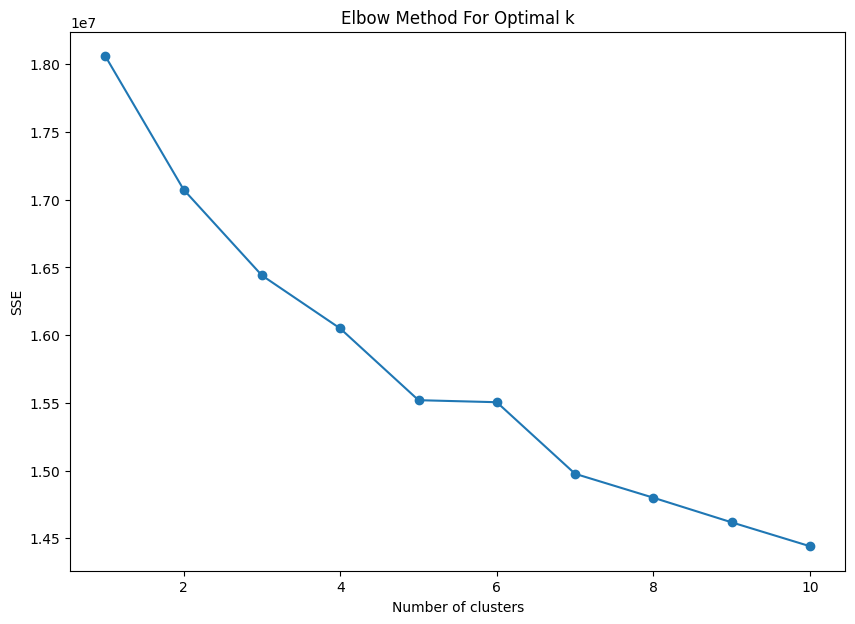

In [146]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 7))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

Теперь, модель на найденном оптимальном числе кластеров. Визуализируем результат и добавим новые признаки в датасет

Optimal number of clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


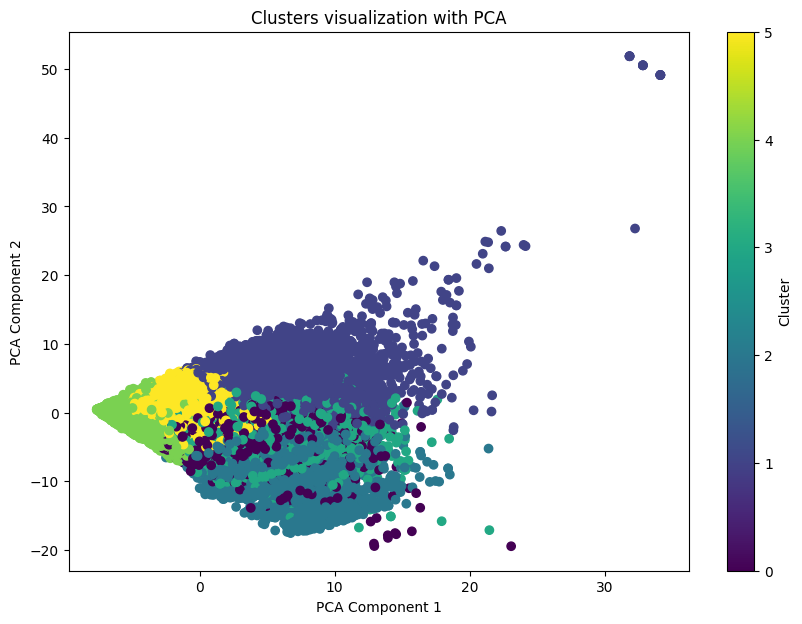

In [147]:
# Определение оптимального числа кластеров
optimal_k = k_range[np.diff(sse, 2).argmin() + 1]
print(f'Optimal number of clusters: {optimal_k}')

# Обучение модели KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

clusters = kmeans.predict(X_scaled)
df['cluster'] = clusters

# Визуализация кластеров с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Продемонстрируем типичных представителей каждого кластера

In [148]:
typical_representation = df.groupby('cluster').mean()
typical_representation

,resolution,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_Q_y,...,S_R_REL_3,S_X_X_0,S_X_Y_0,S_X_REL_0,S_U_X_0,S_U_X_1,S_U_X_2,S_U_X_3,S_U_Y_0,S_U_Y_1,S_U_Y_2,S_U_Y_3,S_U_REL_0,S_U_REL_1,S_U_REL_2,S_U_REL_3,S_T_X_0,S_T_Y_0,S_T_REL_0,S_F_X_0,S_F_X_1,S_F_Y_0,S_F_Y_1,S_F_REL_0,S_F_REL_1,S_C_X_0,S_C_X_1,S_C_X_2,S_C_X_3,S_C_Y_0,S_C_Y_1,S_C_Y_2,S_C_Y_3,S_C_REL_0,S_C_REL_1,S_C_REL_2,S_C_REL_3,sub_channel_ATMAPI,sub_channel_MOBILEAPI,sub_channel_WEBAPI
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.010275,0.191534,7.925705,2.218407,0.066831,0.057258,0.003249,16.810486,0.250110,7.487574,0.515324,4.228155,114.281149,72116.346793,1413.520811,309.218553,254.183945,278.698077,28206.129479,191.899127,80619.239001,1367.125216,67742.317184,0.590761,26.654079,7.788180,0.266708,0.086941,0.018003,39.775446,0.731624,18.150259,1.613419,6.150259,343.142332,2.339054e+05,6639.837167,4765.184185,394.501412,731.597715,...,0.283920,1.0,1.0,1.0,0.209537,0.322297,0.267235,0.200931,0.166067,0.283832,0.328972,0.221129,0.173970,0.274787,0.310442,0.240801,1.0,1.0,1.0,0.731536,0.268464,0.693949,0.306051,0.699043,0.300957,0.286730,0.217792,0.270660,0.224818,0.199438,0.252920,0.317906,0.229736,0.189690,0.259858,0.293668,0.256784,0.121279,0.818828,0.059893
1,0.007505,0.504206,39.546759,5.323850,0.246660,0.084034,0.008742,35.983424,0.553934,29.930068,1.080901,12.296388,300.697467,616774.630208,6756.040924,9398.624965,622.384973,708.312015,399197.664015,883.903163,762390.003411,7120.419177,542327.536289,0.279565,14.348013,1.466683,0.051790,0.036286,0.020699,15.396668,0.263071,9.000660,0.435098,4.886855,166.931305,1.638891e+05,954.330059,292.693272,189.405581,950.048638,...,0.546429,1.0,1.0,1.0,0.009484,0.054923,0.162956,0.772637,0.002721,0.008164,0.071829,0.917285,0.003711,0.030925,0.222497,0.742867,1.0,1.0,1.0,0.472126,0.527874,0.391061,0.608939,0.420666,0.579334,0.061191,0.093518,0.231569,0.613723,0.030760,0.034801,0.107950,0.826489,0.029606,0.071169,0.223899,0.675326,0.052449,0.903266,0.044285
2,0.004000,0.674667,11.869333,2.995200,0.033333,0.025067,0.004267,25.876000,0.351467,12.016800,0.888267,6.045333,287.332077,36778.717795,1659.126232,120.210568,66.871171,58.292533,26756.360355,102.121987,40670.164288,611.229365,30271.781419,0.312800,915.881333,5.785600,0.089067,0.002133,0.003200,44.013067,0.514933,132.013333,1.061067,1.790667,87.155587,2.598654e+06,4313.342891,239.369845,24.688139,65.586933,...,0.129600,1.0,1.0,1.0,0.089333,0.231467,0.296800,0.382400,0.084533,0.426400,0.406133,0.082933,0.118667,0.614400,0.217067,0.049867,1.0,1.0,1.0,0.656267,0.343733,0.666933,0.333067,0.720000,0.280000,0.134667,0.145333,0.285333,0.434667,0.114933,0.377600,0.401333,0.106133,0.130667,0.569067,0.237600,0.062667,0.031467,0.919467,0.049067
3,0.012435,0.149799,10.395625,1.537594,0.047093,0.050892,0.005872,16.598618,0.242142,8.480714,0.421186,5.881174,102.966727,110017.664313,961.983260,662.720991,224.979369,148.676405,32652.505273,201.898788,132364.250548,1100.645291,119135.543657,0.179159,101.176972,1.343120,0.073805,0.039263,0.023374,35.920092,0.304893,17.834312,0.518020,17.462522,102.462808,9.483474e+05,1105.293105,1554.857663,260.195397,2056.017064,...,0.264940,1.0,1.0,1.0,0.171675,0.324352,0.263903,0.240069,0.128728,0.257801,0.309960,0.303512,0.130455,0.270121,0.269085,0.330340,1.0,1.0,1.0,0.809557,0.190443,0.781808,0.218192,0.772136,0.227864,0.247784,0.180771,0.263443,0.308002,0.178469,0.227288,0.291307,0.302936,0.174208,0.263673,0.280368,0.281750,0.126310,0.809442,0.064249
4,0.015389,0.006214,1.198845,0.263848,0.006214,0.020972,0.006068,5.465945,0.077674,0.983057,0.097189,2.039371,81.982036,5749.000705,88.900670,21.161470,56.076964,101.971455,4025.320467,37.769721,4951.046958,166.442040,14078.497888,0.047527,10.344240,0.799602,0.016943,0.062867,0.

In [149]:
df = pd.get_dummies(df, columns=['cluster'], prefix='cluster')

### Алгоритм GMM

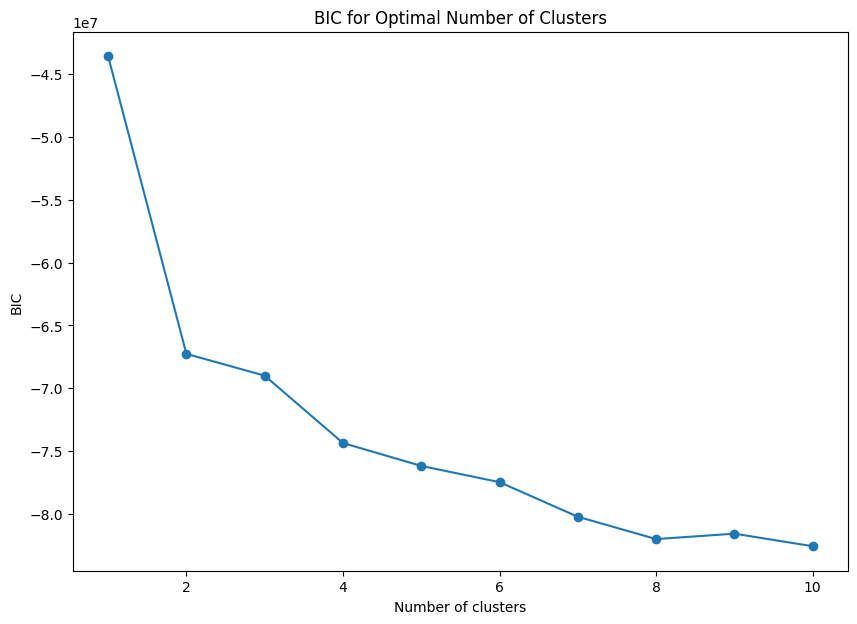

In [150]:
# Определение оптимального числа кластеров с помощью критерия BIC
bic = []
n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

plt.figure(figsize=(10, 7))
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC for Optimal Number of Clusters')
plt.show()

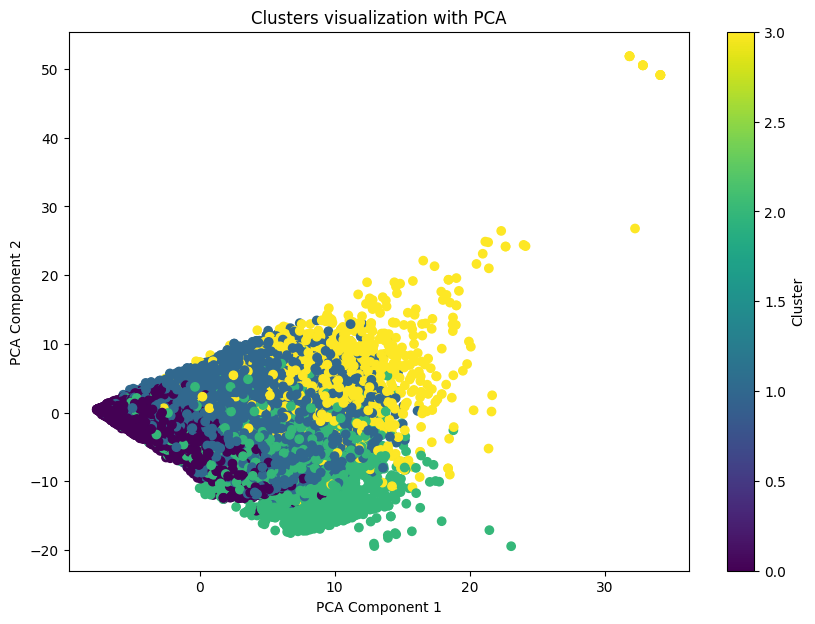

In [151]:
# Выберем по графику подходящее количество кластеров
optimal_n_components = 4

# Обучение модели GMM 
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(X_scaled)

clusters = gmm.predict(X_scaled)
df['cluster'] = clusters

# Визуализация кластеров с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Продемонстрируем типичных представителей каждого кластера

In [152]:
typical_representation = df.groupby('cluster').mean()
typical_representation

,resolution,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_Q_y,...,S_U_X_2,S_U_X_3,S_U_Y_0,S_U_Y_1,S_U_Y_2,S_U_Y_3,S_U_REL_0,S_U_REL_1,S_U_REL_2,S_U_REL_3,S_T_X_0,S_T_Y_0,S_T_REL_0,S_F_X_0,S_F_X_1,S_F_Y_0,S_F_Y_1,S_F_REL_0,S_F_REL_1,S_C_X_0,S_C_X_1,S_C_X_2,S_C_X_3,S_C_Y_0,S_C_Y_1,S_C_Y_2,S_C_Y_3,S_C_REL_0,S_C_REL_1,S_C_REL_2,S_C_REL_3,sub_channel_ATMAPI,sub_channel_MOBILEAPI,sub_channel_WEBAPI,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.018363,0.000000,2.363396,0.515154,0.000000,0.000000,0.004146,8.334470,0.000031,2.335913,0.008629,2.919085,0.000000,8075.583601,165.692419,0.000000,0.000000,39.257802,6.199842e+03,0.030708,8.524376e+03,0.599532,15771.634679,0.000000,37.898265,1.358729,0.006172,0.051006,0.000000,16.482266,0.208690,11.197666,0.318256,4.667557,0.000000,154255.553817,647.560520,1.866357,76.669035,0.000000,...,0.143559,0.000000,0.478919,0.345801,0.175280,0.000000,0.467588,0.272071,0.203838,0.056502,1.0,1.0,1.0,0.933149,0.066851,0.925165,0.074835,0.906495,0.093505,0.542331,0.224689,0.180101,0.052879,0.452234,0.345402,0.202365,0.000000,0.428589,0.290189,0.214678,0.066544,0.160817,0.769753,0.069430,0.096822,0.000000,0.026194,0.053647,0.522586,0.300752
1,0.012310,0.000000,12.945111,2.643573,0.023918,0.059079,0.000000,21.789527,0.361294,13.005231,0.691695,7.068006,0.000000,174305.029130,1669.891197,55.091021,178.319440,0.000000,4.083197e+04,173.278189,2.143522e+05,1481.772117,178550.180581,0.000000,55.989902,1.748666,0.000000,0.000000,0.000000,19.008953,0.185540,14.425500,0.390391,5.639955,0.000000,305756.339199,1054.042472,0.000000,0.000000,0.000000,...,0.249642,0.403821,0.096661,0.184915,0.304974,0.413450,0.106343,0.235614,0.282487,0.375556,1.0,1.0,1.0,0.695078,0.304922,0.653749,0.346251,0.666216,0.333784,0.189600,0.165812,0.270567,0.374021,0.128361,0.172891,0.282721,0.416027,0.128907,0.226921,0.274289,0.369883,0.093225,0.848762,0.058012,0.128907,0.231112,0.040106,0.141217,0.073576,0.385082
2,0.009448,0.742597,8.384261,2.549257,0.141837,0.129278,0.002304,19.436801,0.351999,9.199216,0.667012,4.943427,185.598915,83811.148432,1462.131623,343.063870,397.132690,15.450398,2.951738e+04,197.751214,9.595159e+04,1076.643532,81239.110908,1.387372,222.299113,5.308907,0.534048,0.250490,0.149441,38.851711,1.146676,32.269847,1.802512,9.034451,820.307858,849837.042606,5919.138072,8433.204950,1382.618377,5985.957114,...,0.263394,0.276414,0.160157,0.263510,0.321120,0.255214,0.168337,0.298191,0.289895,0.243576,1.0,1.0,1.0,0.698122,0.301878,0.665054,0.334946,0.675884,0.324116,0.263740,0.185275,0.265699,0.285286,0.197719,0.227446,0.311211,0.263625,0.186427,0.263740,0.284941,0.264892,0.093444,0.844222,0.062334,0.334486,0.099435,0.147022,0.137343,0.079387,0.202327
3,0.011523,2.474705,73.600899,6.336425,0.885048,0.193367,0.071669,43.336987,1.042440,35.856661,1.699831,9.629848,2476.700475,862027.153272,15183.662771,34725.108673,2561.653553,4386.664390,1.170851e+06,3180.006124,1.012749e+06,20746.320548,620416.423904,0.930298,35.497470,3.060708,0.173131,0.042159,0.027263,22.990444,0.413997,15.141934,0.763631,5.562957,301.705846,373824.212870,2795.371147,657.535902,131.960770,1010.954016,...,0.184092,0.626194,0.031478,0.041596,0.166948,0.759978,0.031478,0.063519,0.224283,0.680720,1.0,1.0,1.0,0.473300,0.526700,0.394042,0.605958,0.414559,0.585441,0.149522,0.116920,0.209949,0.523609,0.082631,0.052277,0.153457,0.711636,0.080382,0.106802,0.214727,0.598089,0.041315,0.899101,0.059584,0.106239,0.669758,0.022485,0.089938,0.018269,0.093311


In [153]:
df = pd.get_dummies(df, columns=['cluster'], prefix='cluster')

### Алгоритм DBSCAN

Количество кластеров: 57


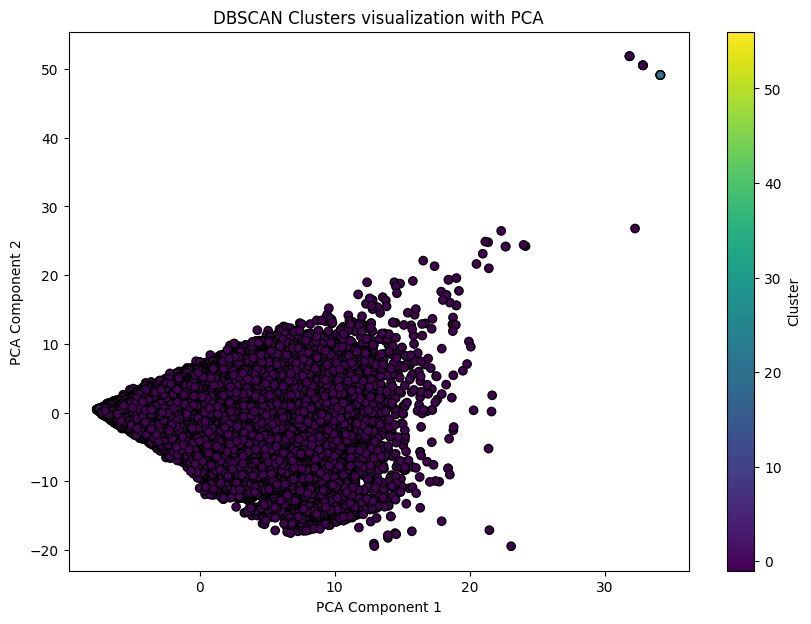

In [154]:
# Применение DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

df['cluster'] = clusters

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f'Количество кластеров: {num_clusters}')

# Визуализация кластеров с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clusters visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Продемонстрируем типичных представителей каждого кластера

In [155]:
typical_representation = df[df['cluster'] != -1].groupby('cluster').mean()
typical_representation

,resolution,S_A_x,S_C_x,S_F_x,S_H_x,S_J_x,S_Q_x,S_R_x,S_T_x,S_U_x,S_X_x,S_Z_x,S_A_y,S_C_y,S_F_y,S_H_y,S_J_y,S_Q_y,S_R_y,S_T_y,S_U_y,S_X_y,S_Z_y,R_A_x,R_C_x,R_F_x,R_H_x,R_J_x,R_Q_x,R_R_x,R_T_x,R_U_x,R_X_x,R_Z_x,R_A_y,R_C_y,R_F_y,R_H_y,R_J_y,R_Q_y,...,S_U_Y_2,S_U_Y_3,S_U_REL_0,S_U_REL_1,S_U_REL_2,S_U_REL_3,S_T_X_0,S_T_Y_0,S_T_REL_0,S_F_X_0,S_F_X_1,S_F_Y_0,S_F_Y_1,S_F_REL_0,S_F_REL_1,S_C_X_0,S_C_X_1,S_C_X_2,S_C_X_3,S_C_Y_0,S_C_Y_1,S_C_Y_2,S_C_Y_3,S_C_REL_0,S_C_REL_1,S_C_REL_2,S_C_REL_3,sub_channel_ATMAPI,sub_channel_MOBILEAPI,sub_channel_WEBAPI,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_0,cluster_1,cluster_2,cluster_3
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.200000,0.0,0.000000,0.000000,0.0,0.0,0.0,6.000000,0.0,0.200000,0.0,2.200000,0.0,0.000000e+00,0.000000,0.0,0.00,0.0,4.764440e+02,0.00,89.890000,0.00,1.920800e+03,0.0,0.800000,0.000000,0.0,0.0,0.0,2.600000,0.0,0.800000,0.0,1.200000,0.0,1.100000e+02,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.000000,0.0,0.00,0.0,9.021850e+02,0.00,0.000000,0.00,0.000000e+00,0.0,0.666667,0.000000,0.0,0.0,0.0,0.833333,0.0,0.000000,0.0,1.000000,0.0,1.250000e+02,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.200000,0.0,8.200000e+02,0.000000,0.0,0.00,0.0,0.000000e+00,0.00,0.000000,0.00,2.000000e+02,0.0,0.800000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.200000,0.0,0.800000,0.0,2.900000e+02,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.0,0.157895,0.000000,0.0,0.0,0.0,2.000000,0.0,0.157895,0.0,0.105263,0.0,4.947368e+01,0.000000,0.0,0.00,0.0,6.900221e+02,0.00,23.684211,0.00,0.000000e+00,0.0,0.473684,0.157895,0.0,0.0,0.0,1.368421,0.0,0.157895,0.0,0.736842,0.0,1.121053e+02,12.842105,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.125000,0.0,0.125000,0.0,0.250000,0.0,0.000000e+00,0.000000,0.0,0.00,0.0,1.216250e+02,0.00,1.250000,0.00,0.000000e+00,0.0,0.250000,0.250000,0.0,0.0,0.0,0.875000,0.0,0.000000,0.0,0.750000,0.0,6.375000e+01,25.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,0.022222,0.0,0.155556,0.044444,0.0,0.0,0.0,1.666667,0.0,0.111111,0.0,0.244444,0.0,1.635556e+01,5.800000,0.0,0.00,0.0,1.744102e+02,0.00,11.333333,0.00,4.444444e+01,0.0,0.266667,0.044444,0.0,0.0,0.0,1.444444,0.0,0.200000,0.0,0.711111,0.0,5.577778e+01,6.933333,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.0,1.400000,0.0,0.000000,0.0,0.266667,0.0,3.133333e+00,0.000000,0.0,0.00,0.0,1.250860e+02,0.00,0.000000,0.00,1.133333e+02,0.0,0.133333,0.066667,0.0,0.0,0.0,5.933333,0.0,0.066667,0.0,0.666667,0.0,6.666667e+01,9.666667,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,0.000000,0.0,11.000000,0.000000,0.0,0.0,0.0,6.000000,0.0,12.000000,0.0,10.000000,0.0,6.362000e+05,0.000000,0.0,0.00,0.0,7.049800e+02,0.00,221999.000000,0.00,6.440040e+05,0.0,0.000000,0.000000,0.0,0.0,0.0,1.00000

In [156]:
df = pd.get_dummies(df, columns=['cluster'], prefix='cluster')

## Отбор фичей

### Отбор коррелирующих между собой фичей

Высокая корреляция между признаками может приводить к избыточности информации и ухудшению обобщающей способности модели. Удаление таких признаков помогает уменьшить мнультиколлинеарность и повысить качество модели.

In [157]:
X = df.drop(columns=['resolution'])

In [158]:
def corr_df(x, corr_val):
    drop_cols = []
    corr_matrix = x.corr()
    
    iters = range(len(corr_matrix.columns) - 1)

    for i in iters:
        for j in range(i):
            # Извлечение значения корреляции между двумя признаками
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values

            # Если корреляция выше или равна заданному порогу, добавляем индекс колонки в список
            if abs(val) >= corr_val:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)
                
    # Удаление колонок, которые сильно коррелируют с другими признаками
    drops = sorted(set(drop_cols))[::-1]

    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

In [159]:
X = corr_df(X, 0.8)

S_U_y | S_C_y | 0.85
R_U_y | R_C_y | 0.92
S_X | S_C_x | 0.86
R_X | R_C_x | 0.99
S_Y | S_R_y | 0.94
R_Y | R_C_y | 0.97
R_Y | R_U_y | 0.92
S_REL | S_R_y | 0.86
S_REL | S_Y | 0.9
S_Q | S_Q_x | 0.83
R_Z_X | R_Z_x | 1.0
R_Z_Y | R_Z_y | 1.0
R_R_X | R_R_x | 1.0
R_R_Y | R_R_y | 1.0
R_X_X | R_X_x | 1.0
R_X_Y | R_X_y | 1.0
R_U_X | R_U_x | 1.0
R_U_Y | R_C_y | 0.92
R_U_Y | R_U_y | 1.0
R_U_Y | R_Y | 0.92
R_T_X | R_T_x | 1.0
R_T_Y | R_T_y | 1.0
R_T_REL | R_T_y | 0.83
R_F_X | R_F_x | 1.0
R_F_Y | R_F_y | 1.0
R_C_X | R_C_x | 1.0
R_C_X | R_X | 0.99
R_C_Y | R_C_y | 1.0
R_C_Y | R_U_y | 0.92
R_C_Y | R_Y | 0.97
R_C_Y | R_U_Y | 0.92
S_Z_X | S_Z_x | 1.0
S_Z_Y | S_Z_y | 1.0
S_Z_REL | S_Y | 0.83
S_Z_REL | S_REL | 0.82
S_R_X | S_R_x | 1.0
S_R_Y | S_R_y | 1.0
S_R_Y | S_Y | 0.94
S_R_Y | S_REL | 0.86
S_R_REL | S_R_y | 0.99
S_R_REL | S_Y | 0.94
S_R_REL | S_REL | 0.86
S_X_X | S_X_x | 1.0
S_X_Y | S_X_y | 1.0
S_U_X | S_U_x | 1.0
S_U_Y | S_C_y | 0.85
S_U_Y | S_U_y | 1.0
S_T_X | S_T_x | 1.0
S_T_Y | S_T_y | 1.0
S_F_X | S_

In [160]:
X.columns

Index(['S_A_x', 'S_C_x', 'S_F_x', 'S_H_x', 'S_J_x', 'S_Q_x', 'S_R_x', 'S_T_x',
       'S_U_x', 'S_X_x',
       ...
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56'],
      dtype='object', length=297)

### Отбор признаков с помощью случайного леса

In [161]:
y = df['resolution']

In [162]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Полученим важность всех признаков
importances = rf.feature_importances_

# Получим топ n самых важных признаков
indices = np.argsort(importances)[-50:]

In [163]:
top_n_feature_names = X.columns[indices]
top_n_feature_names

Index(['S_F_X', 'S_F_x', 'S_F_y', 'S_F_Y', 'S_Z_X', 'S_C_X', 'S_Z_x',
       'S_F_REL', 'R_U_X', 'S_C_x', 'S_U_X', 'R_U_x', 'S_U_x', 'S_R_x',
       'R_C_X', 'S_Z_y', 'R_C_x', 'S_R_X', 'S_C_Y', 'S_Z_Y', 'S_C_REL',
       'S_C_y', 'R_Z_y', 'R_U_Y', 'R_Z_Y', 'R_Z_REL', 'R_Z_X', 'R_R_x',
       'R_C_y', 'S_U_REL', 'R_U_y', 'S_U_Y', 'S_X', 'S_Z_REL', 'R_C_Y',
       'R_Z_x', 'R_R_X', 'R_C_REL', 'R_U_REL', 'R_X', 'S_R_REL', 'S_R_y',
       'S_R_Y', 'S_Y', 'R_Y', 'S_REL', 'R_R_Y', 'R_R_y', 'R_R_REL', 'R_REL'],
      dtype='object')

In [164]:
X = X[top_n_feature_names]

## Обучение модели

Перед обучением модели необходимо обосновать, какую метрику мы будем считать основной и почему. В целом, выбор метрики зависит от требований к модели. Если нам важнее, чтобы модель покрывала как можно больше мошеннических результатов, то мы будем максимизировать recall. Если же мы хотим чтобы наша модель как можно меньше ошибалась, т.е. чтобы среди операций классифицированных нами как мошеннические было как можно меньше ошибок.  
На наш взгляд, правильнее будет требовать, чтобы модель классифицировала верно как больше истинно положительных объектов. Т.е. мы хотим получить максимальное значение полноты (recall).

### Предобработаем данные

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Борьба с дисбалансом классов

Функция для визуализации результатов балансировки классов

In [166]:
def plot_pca_2d_space(X, y, label='Classes'):

    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)
    
    # Определяем цвета и маркеры для классов
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    # Создаем график
    plt.figure(figsize=(10, 8))
    
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X_r[y == l, 0],
            X_r[y == l, 1],
            c=c, label=f'Class {l}', marker=m
        )
    
    # Настройки графика
    plt.title(label)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


Распределение классов до применения методов балансировки: Counter({0: 82031, 1: 1194})


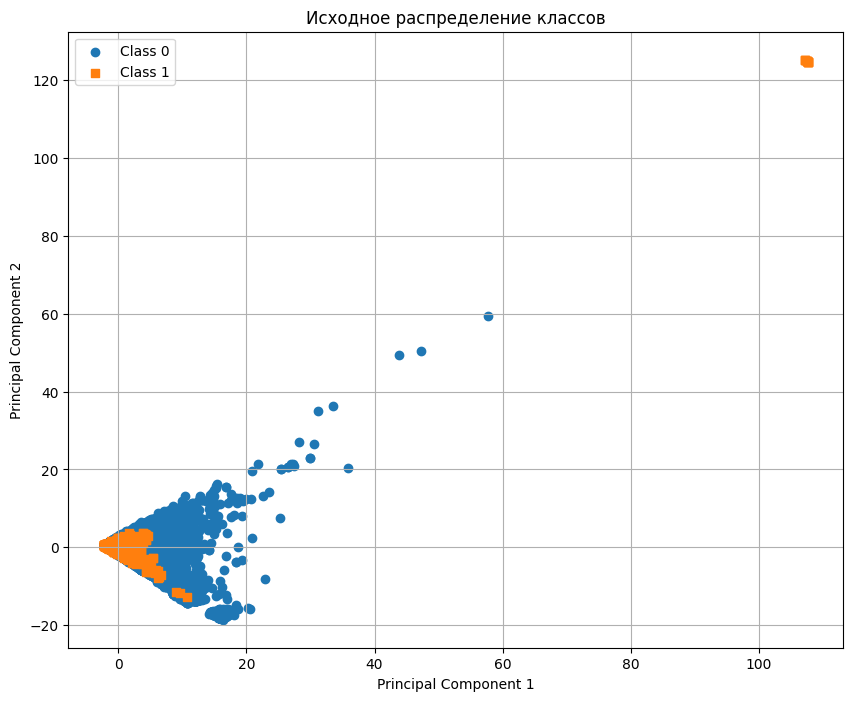

In [167]:
print(f'Распределение классов до применения методов балансировки: {Counter(y)}')
plot_pca_2d_space(X_train_scaled, y_train, 'Исходное распределение классов')

#### Метод 1 - SMOTE

In [168]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

Распределение классов после применения SMOTE: Counter({0: 65610, 1: 65610})


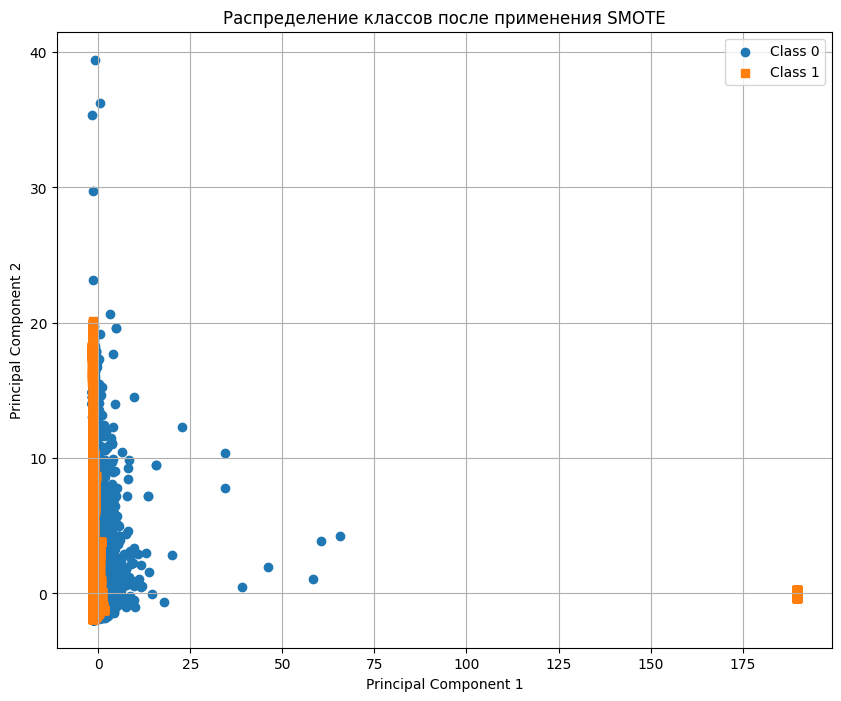

In [169]:
print(f'Распределение классов после применения SMOTE: {Counter(y_train_resampled)}')
plot_pca_2d_space(X_train_resampled, y_train_resampled, 'Распределение классов после применения SMOTE')

#### Метод 2 - ADASYN

Распределение классов после применения ADASYN: Counter({1: 65646, 0: 65610})


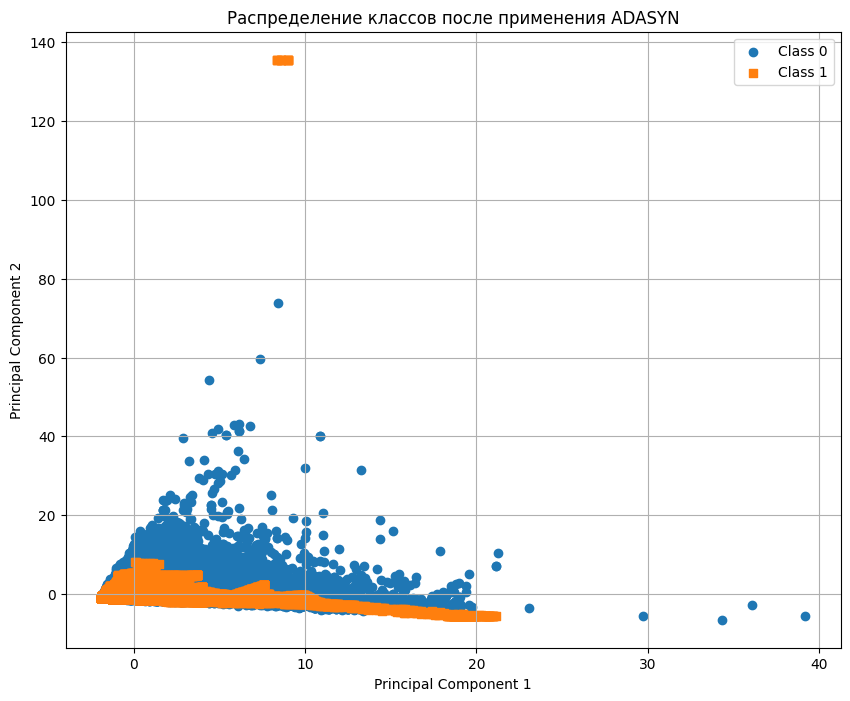

In [170]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
X_train_resampled_2, y_train_resampled_2 = adasyn.fit_resample(X_train_scaled, y_train)

print(f'Распределение классов после применения ADASYN: {Counter(y_train_resampled_2)}')
plot_pca_2d_space(X_train_resampled_2, y_train_resampled_2, 'Распределение классов после применения ADASYN')

### Обучение с балансировкой SMOTE

#### Зададим гиперпараметры для наших моделей, которые будем перебирать

In [173]:
logistic_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [100]
}

rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'bootstrap': [True]
}

catboost_params = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.2],
    'depth': [6]
}


#### Логистическая регрессия

In [174]:
#Инициализация и обучение модели
logistic_model = LogisticRegression(max_iter=1000)
logistic_grid_search = GridSearchCV(logistic_model, logistic_params, cv=5, scoring='recall')
logistic_grid_search.fit(X_train_resampled, y_train_resampled)

#Рассчитаем метрики у лучшей модели
best_logistic_model = logistic_grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
logistic_precision = precision_score(y_test, y_pred_logistic)
logistic_recall = recall_score(y_test, y_pred_logistic)

#Отображение результатов обучения
print("Logistic Regression")
print(classification_report(y_test, y_pred_logistic))
print(f'Best Parameters: {logistic_grid_search.best_params_}')
print(f'Precision: {logistic_precision}')
print(f'Recall: {logistic_recall}')
print()

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.54      0.70     16421
           1       0.02      0.76      0.04       224

    accuracy                           0.54     16645
   macro avg       0.51      0.65      0.37     16645
weighted avg       0.98      0.54      0.69     16645

Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.022150259067357514
Recall: 0.7633928571428571



In [175]:
feature_weights = pd.DataFrame({'Feature': X_train.columns, 'Weight': best_logistic_model.coef_[0]})
feature_weights

,Feature,Weight
0,S_F_X,0.017234
1,S_F_x,0.017234
2,S_F_y,-0.044879
3,S_F_Y,-0.044879
4,S_Z_X,0.001332
5,S_C_X,0.458198
6,S_Z_x,0.001332
7,S_F_REL,-0.099505
8,R_U_X,0.153655
9,S_C_x,0.458198


#### Случайный лес

In [176]:
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring='precision')
rf_grid_search.fit(X_train_resampled, y_train_resampled)

best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(f'Best Parameters: {rf_grid_search.best_params_}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print()

Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16421
           1       0.58      0.31      0.41       224

    accuracy                           0.99     16645
   macro avg       0.79      0.65      0.70     16645
weighted avg       0.99      0.99      0.99     16645

Best Parameters: {'bootstrap': True, 'max_depth': None, 'n_estimators': 150}
Precision: 0.5833333333333334
Recall: 0.3125



#### Градиентный бустинг из реализации catboost

In [177]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)
catboost_grid_search = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='recall')
catboost_grid_search.fit(X_train_resampled, y_train_resampled)

best_catboost_model = catboost_grid_search.best_estimator_
y_pred_catboost = best_catboost_model.predict(X_test_scaled)
catboost_precision = precision_score(y_test, y_pred_catboost)
catboost_recall = recall_score(y_test, y_pred_catboost)

print("CatBoost Classifier")
print(classification_report(y_test, y_pred_catboost))
print(f'Best Parameters: {catboost_grid_search.best_params_}')
print(f'Precision: {catboost_precision}')
print(f'Recall: {catboost_recall}')
print()

CatBoost Classifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16421
           1       0.79      0.17      0.27       224

    accuracy                           0.99     16645
   macro avg       0.89      0.58      0.63     16645
weighted avg       0.99      0.99      0.98     16645

Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.2}
Precision: 0.7872340425531915
Recall: 0.16517857142857142



In [178]:
print("Summary of Model Performance:")
print(f'Logistic Regression - Precision: {logistic_precision}, Recall: {logistic_recall}')
print(f'Random Forest - Precision: {rf_precision}, Recall: {rf_recall}')
print(f'CatBoost Classifier - Precision: {catboost_precision}, Recall: {catboost_recall}')

Summary of Model Performance:
Logistic Regression - Precision: 0.022150259067357514, Recall: 0.7633928571428571
Random Forest - Precision: 0.5833333333333334, Recall: 0.3125
CatBoost Classifier - Precision: 0.7872340425531915, Recall: 0.16517857142857142


### Обучение с балансировкой ADASYN

#### Логистическая регрессия

In [179]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_grid_search = GridSearchCV(logistic_model, logistic_params, cv=5, scoring='recall')
logistic_grid_search.fit(X_train_resampled_2, y_train_resampled_2)

best_logistic_model = logistic_grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
logistic_precision = precision_score(y_test, y_pred_logistic)
logistic_recall = recall_score(y_test, y_pred_logistic)

print("Logistic Regression")
print(classification_report(y_test, y_pred_logistic))
print(f'Best Parameters: {logistic_grid_search.best_params_}')
print(f'Precision: {logistic_precision}')
print(f'Recall: {logistic_recall}')
print()

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     16421
           1       0.02      0.77      0.04       224

    accuracy                           0.53     16645
   macro avg       0.51      0.65      0.37     16645
weighted avg       0.98      0.53      0.68     16645

Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Precision: 0.021788413098236776
Recall: 0.7723214285714286



In [180]:
feature_weights = pd.DataFrame({'Feature': X_train.columns, 'Weight': best_logistic_model.coef_[0]})
feature_weights

,Feature,Weight
0,S_F_X,0.030858
1,S_F_x,0.030858
2,S_F_y,-0.115627
3,S_F_Y,-0.115627
4,S_Z_X,0.011988
5,S_C_X,0.379252
6,S_Z_x,0.011988
7,S_F_REL,0.003642
8,R_U_X,0.167830
9,S_C_x,0.379252


#### Случайный лес

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring='precision')
rf_grid_search.fit(X_train_resampled_2, y_train_resampled_2)

best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(f'Best Parameters: {rf_grid_search.best_params_}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print()

Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16421
           1       0.63      0.31      0.42       224

    accuracy                           0.99     16645
   macro avg       0.81      0.66      0.71     16645
weighted avg       0.99      0.99      0.99     16645

Best Parameters: {'bootstrap': True, 'max_depth': None, 'n_estimators': 150}
Precision: 0.6306306306306306
Recall: 0.3125



#### Градиентный бустинг из реализации catboost

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)
catboost_grid_search = GridSearchCV(catboost_model, catboost_params, cv=5, scoring='recall')
catboost_grid_search.fit(X_train_resampled_2, y_train_resampled_2)

best_catboost_model = catboost_grid_search.best_estimator_
y_pred_catboost = best_catboost_model.predict(X_test_scaled)
catboost_precision = precision_score(y_test, y_pred_catboost)
catboost_recall = recall_score(y_test, y_pred_catboost)

print("CatBoost Classifier")
print(classification_report(y_test, y_pred_catboost))
print(f'Best Parameters: {catboost_grid_search.best_params_}')
print(f'Precision: {catboost_precision}')
print(f'Recall: {catboost_recall}')
print()

CatBoost Classifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16421
           1       0.68      0.15      0.25       224

    accuracy                           0.99     16645
   macro avg       0.83      0.58      0.62     16645
weighted avg       0.98      0.99      0.98     16645

Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.2}
Precision: 0.68
Recall: 0.15178571428571427

